In [156]:
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
import cv2 
from tqdm import tqdm

# Mini-project 1: Dealing with sparse rewards in the Mountain Car environment

# 1 Introduction

### 1.1 Mountain Car Environment

In [157]:
env = gym.make('MountainCar-v0', render_mode="rgb_array")

print(f"Action space: {env.action_space}")
print(f"Observation space: {env.observation_space}")
print(f"Number of actions available: {env.action_space.n}")
print(f"Observation shape: {env.observation_space.shape}")

starting_state, _ = env.reset() 
print(f"Starting state: {starting_state}")

done = False
state, _ = env.reset()
episode_reward = 0
while not done:
    action = env.action_space.sample()
    next_state, reward, terminated, truncated, _ = env.step(action)

    episode_reward += reward

    state = next_state
    done = terminated or truncated

print(f"Episode reward after taking random actions: {episode_reward}")

Action space: Discrete(3)
Observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Number of actions available: 3
Observation shape: (2,)
Starting state: [-0.4103357  0.       ]
Episode reward after taking random actions: -200.0


### 1.2 Agents

In [158]:
class Agents():
    def __init__(self, env):
        self.done = False
        self.env = env

    def observe(self, action, next_state, reward):
        None 
    
    def select_action(self, state):
        None

    def update(self):
        None

# 2. First steps

In [159]:
class RandomAgent(Agents):
    def __init__(self, env):
        super().__init__(env)
    
    def select_action(self, state):
        return self.env.action_space.sample()

In [160]:
def episode(env, agent):
    state, _ = env.reset()
    done = False

    episode_reward = 0
    episode_length = 0
    while not done:
        action = agent.select_action(state)
        next_state, reward, terminated, truncated, _ = env.step(action)

        episode_reward += reward
        episode_length += 1

        state = next_state
        done = terminated or truncated

    return episode_reward, episode_length

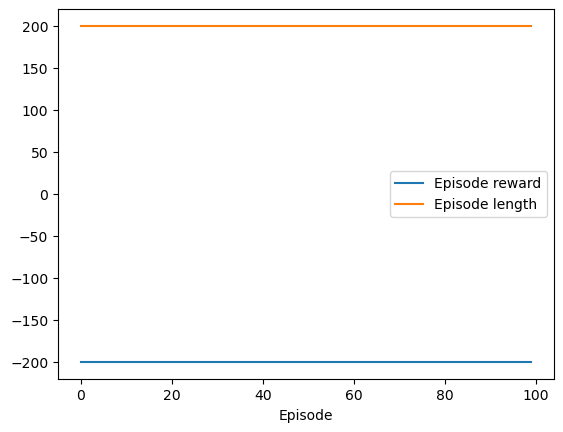

In [161]:
environment = gym.make('MountainCar-v0', render_mode="rgb_array")
agent = RandomAgent(environment)

num_episodes = 100
episode_rewards = np.empty(num_episodes)
episode_lengths = np.empty(num_episodes)
for i in range(num_episodes):
    episode_rewards[i], episode_lengths[i] = episode(environment, agent)

plt.figure()
plt.plot(episode_rewards, label="Episode reward")
plt.plot(episode_lengths, label="Episode length")
plt.xlabel("Episode") 
plt.legend()
plt.show()

Episode rewaard and episode lentgh are always -200 and 200, which is the default value for truncated=True. 

Basically, random sample of actions never solves the problem. 

# 3. DQN

### 3.1 Implementation 

In [162]:
class Q(torch.nn.Module): 
    def __init__(self):
        super(Q, self).__init__()
        
        self.MLP = torch.nn.Sequential(
            torch.nn.Linear(2, 64),
            torch.nn.ReLU(),
            #torch.nn.Linear(64, 64),
            #torch.nn.ReLU(),
            torch.nn.Linear(64, 3))

    def forward(self, state):
        Q_values = self.MLP(state)
        return Q_values

In [163]:
class ReplayBuffer:    
    def __init__(self, capacity=10000):
        self.capacity = capacity
        self.num_samples = 0
        self.buffer = torch.zeros((self.capacity, 7))
        
    def add_observation(self, observation):
        #observation = (state, action, reward, next_state)
        index = self.num_samples % self.capacity

        self.buffer[index] = observation
        self.num_samples += 1

    def sample_batch(self,batch_size=64):
        record_range = min(self.num_samples, self.capacity)
        indices = torch.randint(0,record_range,size=(batch_size,))
        return self.buffer[indices]
    
    def __len__(self):
        return min(self.num_samples, self.capacity)

In [164]:
class DQNAgent(Agents):
    def __init__(self,env, epsilon = 0.9, batch_size=64):
        super().__init__(env)
        self.Q = Q()
        self.discount_factor = 0.99
        self.epsilon = epsilon
        self.batch_size = batch_size
        self.optimizer = torch.optim.AdamW(self.Q.parameters(), lr=1e-3)
        self.replay_buffer = ReplayBuffer()

    def observe(self, state, action, reward, next_state, done):
        self.replay_buffer.add_observation(torch.tensor([state[0], state[1], action, reward, next_state[0], next_state[1], done], dtype=torch.float32))

    def update_epsilon(self):
        self.epsilon *= 0.99
        self.epsilon = max(self.epsilon, 0.05)
    
    def select_action(self, state):
        if random.random() < self.epsilon:
            return self.env.action_space.sample()
        else:
            with torch.no_grad():
                q = self.Q(torch.tensor(state, dtype=torch.float32)).numpy()
                max_indices = np.argwhere(q == q.max())
                return np.random.choice(max_indices[0])
    
    def update(self):
        #batch.shape = (B, (S_x, S_v, A, R, S'_x, S'_v))
        batch = self.replay_buffer.sample_batch(self.batch_size)
        self.optimizer.zero_grad()

        batch_next_state_Q_values = self.Q(batch[:, 4:6]).clone().detach() # shape = (B, 3) 3 is action space
        
        current_Q_value =  torch.gather(self.Q(batch[:, :2]), dim=1, index=batch[:, 2].long().unsqueeze(1)).squeeze(1)
        batch_next_state_max_Q_value = torch.max(batch_next_state_Q_values, dim=1).values
        target_Q_value = batch[:, 3] + self.discount_factor*batch_next_state_max_Q_value*(1-batch[:, 6]) # Only reward if state is done
        loss = torch.functional.F.mse_loss(current_Q_value, target_Q_value)
        
        #batch_max_next_state_Q_value = torch.max(batch_next_state_Q_values, dim=1).values
        #loss = 0.5 * torch.mean((batch[:, 3] + self.discount_factor*batch_max_next_state_Q_value 
        #              - self.Q(batch[:, :2])[:, batch[:, 2].int()])**2)
        
        loss.backward()
        self.optimizer.step()
        return loss.item()    

### 3.2 No auxiliary reward

In [165]:
def run_episode_DQN(agent, render=False, video_path="video.mp4", truncation = 200):

    state, _ = environment.reset()
    done = False
    
    episode_reward = 0
    episode_length = 0
    if render:
        frame = environment.render()
        height, width, _ = frame.shape

        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(video_path, fourcc, 20.0, (width, height))

    while not done:
        if render:
            frame = environment.render()
            frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
            out.write(frame)

        action = agent.select_action(state)
        next_state, reward, terminated, truncated, _ = environment.step(action)
        agent.observe(state, action, reward, next_state, terminated)

        if terminated:
            print("Goal Found:", episode_reward, episode_length)

        if (len(agent.replay_buffer) > agent.batch_size):
            agent.update()
            agent.update_epsilon()
        
        episode_reward += reward
        episode_length += 1
        state = next_state
        done = terminated or (episode_reward - 1 < -truncation)
        
    if render:
        out.release()
    return episode_reward, episode_length

In [166]:
environment = gym.make('MountainCar-v0', render_mode="rgb_array")
agent = DQNAgent(environment)

list_rewards, list_lengths = ([], [])
for episode in tqdm(range(1000)):
    if (episode==999): kwargs = dict(render=True, video_path="video_dqn_3.2_trunc200.mp4")
    else: kwargs = dict(render=False)

    episode_reward, episode_length = run_episode_DQN(agent=agent, **kwargs)
    list_rewards.append(episode_reward)
    list_lengths.append(episode_length)

100%|██████████| 1000/1000 [01:38<00:00, 10.17it/s]


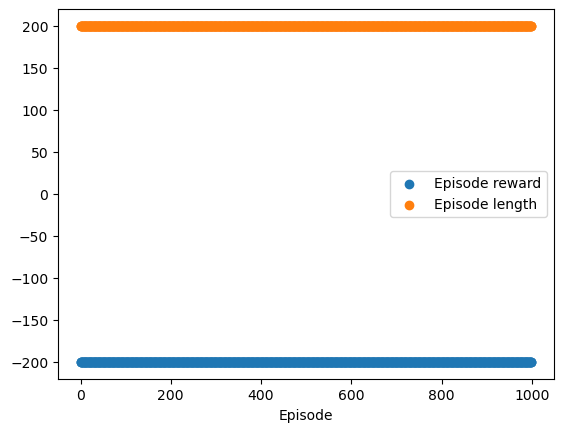

In [167]:
plt.figure()
plt.scatter(np.arange(len(list_rewards)),list_rewards, label="Episode reward")
plt.scatter(np.arange(len(list_lengths)),list_lengths, label="Episode length")
plt.xlabel("Episode") 
plt.legend()
plt.show()

In [168]:
environment = gym.make('MountainCar-v0', render_mode="rgb_array")
agent = DQNAgent(environment)

list_rewards, list_lengths = ([], [])
for episode in tqdm(range(1000)):
    if (episode==999): kwargs = dict(render=True, video_path="video_dqn_3.2_trunc1000.mp4")
    else: kwargs = dict(render=False)

    total_reward, duration = run_episode_DQN(agent=agent, truncation=1000, **kwargs)
    list_rewards.append(total_reward)
    list_lengths.append(duration)

  0%|          | 1/1000 [00:00<03:47,  4.39it/s]

Goal Found: -527.0 527


 19%|█▉        | 190/1000 [01:32<06:24,  2.11it/s]

Goal Found: -926.0 926


 32%|███▏      | 319/1000 [02:34<05:22,  2.11it/s]

Goal Found: -965.0 965


 39%|███▉      | 393/1000 [03:10<04:47,  2.11it/s]

Goal Found: -984.0 984


 39%|███▉      | 394/1000 [03:11<04:45,  2.12it/s]

Goal Found: -979.0 979


 40%|████      | 400/1000 [03:13<03:49,  2.62it/s]

Goal Found: -329.0 329


 41%|████      | 408/1000 [03:17<04:17,  2.30it/s]

Goal Found: -744.0 744


 41%|████      | 410/1000 [03:17<03:28,  2.83it/s]

Goal Found: -945.0 945
Goal Found: -323.0 323


 41%|████      | 411/1000 [03:18<03:28,  2.82it/s]

Goal Found: -757.0 757


 41%|████      | 412/1000 [03:18<03:51,  2.54it/s]

Goal Found: -949.0 949


 42%|████▏     | 420/1000 [03:22<04:17,  2.25it/s]

Goal Found: -822.0 822


 42%|████▏     | 423/1000 [03:23<04:18,  2.24it/s]

Goal Found: -872.0 872


 42%|████▎     | 425/1000 [03:24<03:37,  2.64it/s]

Goal Found: -397.0 397


 43%|████▎     | 427/1000 [03:25<04:01,  2.37it/s]

Goal Found: -997.0 997


 43%|████▎     | 429/1000 [03:25<02:54,  3.27it/s]

Goal Found: -589.0 589
Goal Found: -265.0 265


 43%|████▎     | 430/1000 [03:26<03:19,  2.86it/s]

Goal Found: -958.0 958


 44%|████▎     | 435/1000 [03:28<04:14,  2.22it/s]

Goal Found: -945.0 945


 45%|████▍     | 449/1000 [03:35<03:59,  2.30it/s]

Goal Found: -667.0 667


 45%|████▌     | 450/1000 [03:35<03:33,  2.57it/s]

Goal Found: -590.0 590


 45%|████▌     | 451/1000 [03:36<03:40,  2.49it/s]

Goal Found: -902.0 902


 45%|████▌     | 452/1000 [03:36<03:43,  2.45it/s]

Goal Found: -843.0 843


 45%|████▌     | 454/1000 [03:37<03:47,  2.40it/s]

Goal Found: -783.0 783


 46%|████▌     | 461/1000 [03:40<03:32,  2.54it/s]

Goal Found: -423.0 423


 47%|████▋     | 468/1000 [03:43<03:06,  2.86it/s]

Goal Found: -708.0 708
Goal Found: -396.0 396


 47%|████▋     | 469/1000 [03:43<02:52,  3.08it/s]

Goal Found: -536.0 536


 47%|████▋     | 470/1000 [03:43<02:51,  3.09it/s]

Goal Found: -658.0 658


 47%|████▋     | 471/1000 [03:44<02:58,  2.96it/s]

Goal Found: -764.0 764


 47%|████▋     | 472/1000 [03:44<03:15,  2.70it/s]

Goal Found: -914.0 914


 47%|████▋     | 473/1000 [03:45<03:08,  2.80it/s]

Goal Found: -666.0 666


 49%|████▊     | 487/1000 [03:51<03:23,  2.52it/s]

Goal Found: -444.0 444


 49%|████▉     | 488/1000 [03:51<02:57,  2.88it/s]

Goal Found: -491.0 491


 49%|████▉     | 489/1000 [03:51<02:37,  3.24it/s]

Goal Found: -474.0 474


 49%|████▉     | 490/1000 [03:52<02:27,  3.47it/s]

Goal Found: -516.0 516


 49%|████▉     | 491/1000 [03:52<02:16,  3.72it/s]

Goal Found: -472.0 472


 49%|████▉     | 492/1000 [03:52<02:18,  3.67it/s]

Goal Found: -605.0 605


 49%|████▉     | 494/1000 [03:53<02:22,  3.54it/s]

Goal Found: -365.0 365


 50%|████▉     | 496/1000 [03:53<02:06,  3.97it/s]

Goal Found: -649.0 649
Goal Found: -357.0 357


 50%|████▉     | 497/1000 [03:54<01:53,  4.43it/s]

Goal Found: -343.0 343


 51%|█████     | 506/1000 [03:58<03:23,  2.43it/s]

Goal Found: -650.0 650


 51%|█████     | 511/1000 [04:00<03:18,  2.47it/s]

Goal Found: -571.0 571


 51%|█████     | 512/1000 [04:00<03:07,  2.60it/s]

Goal Found: -687.0 687


 51%|█████▏    | 513/1000 [04:00<02:43,  2.98it/s]

Goal Found: -460.0 460


 51%|█████▏    | 514/1000 [04:01<02:44,  2.95it/s]

Goal Found: -708.0 708


 52%|█████▏    | 516/1000 [04:01<02:52,  2.81it/s]

Goal Found: -594.0 594


 52%|█████▏    | 517/1000 [04:02<02:33,  3.15it/s]

Goal Found: -493.0 493


 52%|█████▏    | 518/1000 [04:02<02:28,  3.25it/s]

Goal Found: -484.0 484


 52%|█████▏    | 519/1000 [04:02<02:51,  2.81it/s]

Goal Found: -976.0 976


 52%|█████▏    | 520/1000 [04:03<03:04,  2.61it/s]

Goal Found: -966.0 966


 52%|█████▏    | 521/1000 [04:03<03:13,  2.48it/s]

Goal Found: -957.0 957


 52%|█████▏    | 524/1000 [04:05<03:35,  2.21it/s]

Goal Found: -991.0 991


 53%|█████▎    | 526/1000 [04:06<03:32,  2.23it/s]

Goal Found: -875.0 875


 53%|█████▎    | 530/1000 [04:07<03:15,  2.41it/s]

Goal Found: -617.0 617


 54%|█████▎    | 535/1000 [04:10<03:01,  2.56it/s]

Goal Found: -381.0 381


 54%|█████▎    | 537/1000 [04:10<03:00,  2.56it/s]

Goal Found: -670.0 670


 54%|█████▍    | 539/1000 [04:11<02:17,  3.35it/s]

Goal Found: -470.0 470
Goal Found: -394.0 394


 54%|█████▍    | 541/1000 [04:11<01:44,  4.39it/s]

Goal Found: -342.0 342
Goal Found: -333.0 333


 55%|█████▍    | 545/1000 [04:12<02:03,  3.67it/s]

Goal Found: -495.0 495
Goal Found: -331.0 331


 55%|█████▍    | 547/1000 [04:13<02:34,  2.94it/s]

Goal Found: -782.0 782


 55%|█████▍    | 549/1000 [04:14<02:04,  3.61it/s]

Goal Found: -581.0 581
Goal Found: -373.0 373


 55%|█████▌    | 551/1000 [04:14<01:40,  4.47it/s]

Goal Found: -561.0 561
Goal Found: -238.0 238


 55%|█████▌    | 552/1000 [04:15<02:04,  3.60it/s]

Goal Found: -770.0 770


 55%|█████▌    | 554/1000 [04:15<02:01,  3.68it/s]

Goal Found: -273.0 273


 56%|█████▌    | 557/1000 [04:16<01:46,  4.15it/s]

Goal Found: -302.0 302
Goal Found: -345.0 345


 56%|█████▌    | 559/1000 [04:16<01:29,  4.93it/s]

Goal Found: -368.0 368
Goal Found: -328.0 328


 56%|█████▌    | 561/1000 [04:17<01:21,  5.41it/s]

Goal Found: -332.0 332
Goal Found: -339.0 339


 57%|█████▋    | 567/1000 [04:19<02:37,  2.75it/s]

Goal Found: -466.0 466


 57%|█████▋    | 568/1000 [04:19<02:28,  2.92it/s]

Goal Found: -633.0 633


 57%|█████▋    | 569/1000 [04:20<02:30,  2.87it/s]

Goal Found: -785.0 785


 57%|█████▋    | 571/1000 [04:21<02:51,  2.51it/s]

Goal Found: -850.0 850


 57%|█████▋    | 572/1000 [04:21<02:42,  2.63it/s]

Goal Found: -722.0 722


 57%|█████▋    | 573/1000 [04:21<02:40,  2.66it/s]

Goal Found: -777.0 777


 57%|█████▋    | 574/1000 [04:22<02:29,  2.85it/s]

Goal Found: -608.0 608


 58%|█████▊    | 576/1000 [04:22<02:00,  3.51it/s]

Goal Found: -564.0 564
Goal Found: -413.0 413


 58%|█████▊    | 577/1000 [04:22<01:49,  3.85it/s]

Goal Found: -429.0 429


 58%|█████▊    | 579/1000 [04:23<01:57,  3.59it/s]

Goal Found: -393.0 393


 58%|█████▊    | 581/1000 [04:24<02:01,  3.45it/s]

Goal Found: -330.0 330


 58%|█████▊    | 583/1000 [04:24<02:13,  3.13it/s]

Goal Found: -474.0 474


 58%|█████▊    | 585/1000 [04:25<02:42,  2.55it/s]

Goal Found: -942.0 942


 59%|█████▊    | 586/1000 [04:26<02:21,  2.93it/s]

Goal Found: -467.0 467


 59%|█████▉    | 588/1000 [04:26<01:54,  3.58it/s]

Goal Found: -789.0 789
Goal Found: -232.0 232


 59%|█████▉    | 590/1000 [04:27<01:46,  3.86it/s]

Goal Found: -698.0 698
Goal Found: -375.0 375


 59%|█████▉    | 591/1000 [04:27<02:09,  3.16it/s]

Goal Found: -948.0 948


 59%|█████▉    | 592/1000 [04:27<01:55,  3.53it/s]

Goal Found: -384.0 384


 60%|█████▉    | 595/1000 [04:28<01:50,  3.67it/s]

Goal Found: -564.0 564
Goal Found: -236.0 236


 60%|█████▉    | 596/1000 [04:28<01:36,  4.18it/s]

Goal Found: -326.0 326


 60%|█████▉    | 597/1000 [04:29<01:52,  3.60it/s]

Goal Found: -770.0 770


 60%|█████▉    | 598/1000 [04:29<01:56,  3.45it/s]

Goal Found: -653.0 653


 60%|██████    | 601/1000 [04:31<02:47,  2.38it/s]

Goal Found: -938.0 938


 60%|██████    | 604/1000 [04:32<02:30,  2.62it/s]

Goal Found: -507.0 507


 60%|██████    | 605/1000 [04:32<02:20,  2.80it/s]

Goal Found: -651.0 651


 61%|██████    | 606/1000 [04:32<02:18,  2.84it/s]

Goal Found: -728.0 728


 61%|██████    | 607/1000 [04:33<02:31,  2.59it/s]

Goal Found: -877.0 877


 61%|██████    | 610/1000 [04:34<01:48,  3.60it/s]

Goal Found: -250.0 250
Goal Found: -323.0 323


 61%|██████    | 611/1000 [04:34<01:38,  3.95it/s]

Goal Found: -379.0 379


 61%|██████    | 612/1000 [04:34<01:36,  4.04it/s]

Goal Found: -480.0 480


 61%|██████▏   | 613/1000 [04:34<01:58,  3.26it/s]

Goal Found: -936.0 936


 61%|██████▏   | 614/1000 [04:35<02:15,  2.85it/s]

Goal Found: -965.0 965


 62%|██████▏   | 615/1000 [04:35<02:24,  2.66it/s]

Goal Found: -928.0 928


 62%|██████▏   | 617/1000 [04:36<01:43,  3.69it/s]

Goal Found: -484.0 484
Goal Found: -265.0 265


 62%|██████▏   | 620/1000 [04:37<01:56,  3.27it/s]

Goal Found: -262.0 262


 62%|██████▏   | 621/1000 [04:37<01:52,  3.36it/s]

Goal Found: -570.0 570


 62%|██████▏   | 622/1000 [04:37<01:51,  3.39it/s]

Goal Found: -620.0 620


 62%|██████▏   | 624/1000 [04:38<01:54,  3.28it/s]

Goal Found: -339.0 339


 63%|██████▎   | 629/1000 [04:41<02:53,  2.14it/s]

Goal Found: -920.0 920


 63%|██████▎   | 631/1000 [04:41<02:06,  2.91it/s]

Goal Found: -593.0 593
Goal Found: -378.0 378


 63%|██████▎   | 632/1000 [04:41<01:55,  3.20it/s]

Goal Found: -488.0 488


 63%|██████▎   | 633/1000 [04:41<01:45,  3.47it/s]

Goal Found: -474.0 474


 63%|██████▎   | 634/1000 [04:42<01:46,  3.42it/s]

Goal Found: -510.0 510


 64%|██████▎   | 637/1000 [04:43<01:30,  4.03it/s]

Goal Found: -262.0 262
Goal Found: -345.0 345


 64%|██████▍   | 638/1000 [04:43<01:15,  4.79it/s]

Goal Found: -232.0 232


 64%|██████▍   | 640/1000 [04:43<01:04,  5.56it/s]

Goal Found: -431.0 431
Goal Found: -232.0 232


 64%|██████▍   | 642/1000 [04:43<01:07,  5.27it/s]

Goal Found: -464.0 464
Goal Found: -380.0 380


 64%|██████▍   | 644/1000 [04:44<00:57,  6.21it/s]

Goal Found: -279.0 279
Goal Found: -277.0 277


 64%|██████▍   | 645/1000 [04:44<00:54,  6.48it/s]

Goal Found: -293.0 293


 65%|██████▍   | 647/1000 [04:44<00:57,  6.15it/s]

Goal Found: -566.0 566
Goal Found: -228.0 228


 65%|██████▍   | 649/1000 [04:44<00:50,  7.01it/s]

Goal Found: -225.0 225
Goal Found: -221.0 221


 65%|██████▌   | 650/1000 [04:45<00:55,  6.32it/s]

Goal Found: -417.0 417


 65%|██████▌   | 651/1000 [04:45<01:14,  4.70it/s]

Goal Found: -736.0 736


 65%|██████▌   | 653/1000 [04:46<01:22,  4.19it/s]

Goal Found: -884.0 884
Goal Found: -333.0 333


 66%|██████▌   | 655/1000 [04:46<01:32,  3.72it/s]

Goal Found: -379.0 379


 66%|██████▌   | 656/1000 [04:47<01:46,  3.24it/s]

Goal Found: -870.0 870


 66%|██████▌   | 659/1000 [04:48<01:53,  3.01it/s]

Goal Found: -445.0 445


 66%|██████▌   | 661/1000 [04:48<01:26,  3.90it/s]

Goal Found: -634.0 634
Goal Found: -221.0 221


 66%|██████▋   | 663/1000 [04:49<01:16,  4.42it/s]

Goal Found: -545.0 545
Goal Found: -229.0 229


 66%|██████▋   | 664/1000 [04:49<01:03,  5.26it/s]

Goal Found: -218.0 218


 66%|██████▋   | 665/1000 [04:49<01:15,  4.46it/s]

Goal Found: -609.0 609


 67%|██████▋   | 667/1000 [04:49<01:05,  5.08it/s]

Goal Found: -478.0 478
Goal Found: -272.0 272


 67%|██████▋   | 669/1000 [04:50<01:09,  4.77it/s]

Goal Found: -788.0 788
Goal Found: -245.0 245


 67%|██████▋   | 670/1000 [04:50<01:17,  4.28it/s]

Goal Found: -567.0 567


 67%|██████▋   | 671/1000 [04:50<01:24,  3.88it/s]

Goal Found: -645.0 645


 68%|██████▊   | 677/1000 [04:53<01:56,  2.77it/s]

Goal Found: -403.0 403


 68%|██████▊   | 678/1000 [04:53<01:48,  2.98it/s]

Goal Found: -565.0 565


 68%|██████▊   | 679/1000 [04:54<01:45,  3.05it/s]

Goal Found: -615.0 615


 68%|██████▊   | 681/1000 [04:54<01:32,  3.43it/s]

Goal Found: -783.0 783
Goal Found: -410.0 410


 68%|██████▊   | 682/1000 [04:54<01:20,  3.93it/s]

Goal Found: -347.0 347


 68%|██████▊   | 683/1000 [04:55<01:28,  3.58it/s]

Goal Found: -701.0 701


 68%|██████▊   | 685/1000 [04:55<01:19,  3.97it/s]

Goal Found: -805.0 805
Goal Found: -239.0 239


 69%|██████▊   | 687/1000 [04:56<01:21,  3.83it/s]

Goal Found: -232.0 232


 69%|██████▉   | 690/1000 [04:57<02:04,  2.50it/s]

Goal Found: -894.0 894


 69%|██████▉   | 692/1000 [04:58<02:12,  2.33it/s]

Goal Found: -896.0 896


 69%|██████▉   | 694/1000 [04:58<01:34,  3.25it/s]

Goal Found: -433.0 433
Goal Found: -367.0 367


 70%|██████▉   | 696/1000 [04:59<01:15,  4.05it/s]

Goal Found: -392.0 392
Goal Found: -398.0 398


 70%|██████▉   | 698/1000 [04:59<00:56,  5.31it/s]

Goal Found: -309.0 309
Goal Found: -228.0 228


 70%|███████   | 700/1000 [04:59<00:56,  5.36it/s]

Goal Found: -591.0 591
Goal Found: -227.0 227


 70%|███████   | 702/1000 [05:00<00:49,  6.07it/s]

Goal Found: -253.0 253
Goal Found: -310.0 310


 70%|███████   | 703/1000 [05:00<00:56,  5.24it/s]

Goal Found: -408.0 408


 70%|███████   | 705/1000 [05:01<01:07,  4.34it/s]

Goal Found: -872.0 872
Goal Found: -333.0 333


 71%|███████   | 706/1000 [05:01<00:57,  5.15it/s]

Goal Found: -233.0 233


 71%|███████   | 707/1000 [05:01<01:10,  4.18it/s]

Goal Found: -694.0 694


 71%|███████   | 710/1000 [05:02<01:28,  3.29it/s]

Goal Found: -359.0 359


 71%|███████▏  | 714/1000 [05:03<01:15,  3.79it/s]

Goal Found: -254.0 254
Goal Found: -312.0 312


 72%|███████▏  | 717/1000 [05:04<01:06,  4.23it/s]

Goal Found: -328.0 328
Goal Found: -322.0 322


 72%|███████▏  | 718/1000 [05:04<01:11,  3.94it/s]

Goal Found: -621.0 621


 72%|███████▏  | 720/1000 [05:05<01:01,  4.55it/s]

Goal Found: -337.0 337
Goal Found: -336.0 336


 72%|███████▏  | 722/1000 [05:05<01:03,  4.35it/s]

Goal Found: -845.0 845
Goal Found: -272.0 272


 72%|███████▏  | 724/1000 [05:06<01:08,  4.03it/s]

Goal Found: -269.0 269


 73%|███████▎  | 726/1000 [05:07<01:28,  3.09it/s]

Goal Found: -668.0 668


 73%|███████▎  | 729/1000 [05:08<01:48,  2.50it/s]

Goal Found: -734.0 734


 73%|███████▎  | 731/1000 [05:09<01:51,  2.42it/s]

Goal Found: -720.0 720


 73%|███████▎  | 732/1000 [05:09<01:39,  2.69it/s]

Goal Found: -568.0 568


 73%|███████▎  | 734/1000 [05:10<01:08,  3.87it/s]

Goal Found: -361.0 361
Goal Found: -238.0 238


 74%|███████▎  | 736/1000 [05:10<00:50,  5.19it/s]

Goal Found: -234.0 234
Goal Found: -259.0 259


 74%|███████▎  | 737/1000 [05:10<00:46,  5.70it/s]

Goal Found: -290.0 290


 74%|███████▍  | 739/1000 [05:10<00:45,  5.78it/s]

Goal Found: -430.0 430
Goal Found: -296.0 296


 74%|███████▍  | 741/1000 [05:11<00:38,  6.79it/s]

Goal Found: -229.0 229
Goal Found: -241.0 241


 74%|███████▍  | 742/1000 [05:11<00:35,  7.32it/s]

Goal Found: -223.0 223


 74%|███████▍  | 744/1000 [05:11<00:39,  6.42it/s]

Goal Found: -483.0 483
Goal Found: -270.0 270


 74%|███████▍  | 745/1000 [05:11<00:53,  4.81it/s]

Goal Found: -584.0 584


 75%|███████▍  | 749/1000 [05:13<00:58,  4.32it/s]

Goal Found: -211.0 211
Goal Found: -215.0 215


 75%|███████▌  | 751/1000 [05:13<00:53,  4.65it/s]

Goal Found: -588.0 588
Goal Found: -287.0 287


 75%|███████▌  | 752/1000 [05:13<01:07,  3.65it/s]

Goal Found: -924.0 924


 76%|███████▌  | 755/1000 [05:15<01:14,  3.29it/s]

Goal Found: -994.0 994
Goal Found: -295.0 295


 76%|███████▌  | 756/1000 [05:15<01:01,  3.94it/s]

Goal Found: -270.0 270


 76%|███████▌  | 758/1000 [05:15<00:54,  4.43it/s]

Goal Found: -560.0 560
Goal Found: -315.0 315


 76%|███████▌  | 759/1000 [05:15<00:47,  5.11it/s]

Goal Found: -230.0 230


 76%|███████▌  | 760/1000 [05:15<00:52,  4.59it/s]

Goal Found: -474.0 474


 76%|███████▌  | 761/1000 [05:16<00:57,  4.16it/s]

Goal Found: -547.0 547


 76%|███████▋  | 763/1000 [05:16<00:48,  4.88it/s]

Goal Found: -538.0 538
Goal Found: -221.0 221


 76%|███████▋  | 765/1000 [05:17<00:44,  5.28it/s]

Goal Found: -570.0 570
Goal Found: -239.0 239


 77%|███████▋  | 767/1000 [05:17<00:37,  6.28it/s]

Goal Found: -302.0 302
Goal Found: -241.0 241


 77%|███████▋  | 769/1000 [05:17<00:54,  4.27it/s]

Goal Found: -416.0 416


 77%|███████▋  | 770/1000 [05:18<00:53,  4.26it/s]

Goal Found: -498.0 498


 77%|███████▋  | 773/1000 [05:19<01:00,  3.75it/s]

Goal Found: -560.0 560
Goal Found: -358.0 358


 78%|███████▊  | 775/1000 [05:19<01:08,  3.29it/s]

Goal Found: -505.0 505


 78%|███████▊  | 777/1000 [05:20<00:55,  4.00it/s]

Goal Found: -694.0 694
Goal Found: -211.0 211


 78%|███████▊  | 779/1000 [05:20<00:43,  5.12it/s]

Goal Found: -393.0 393
Goal Found: -214.0 214


 78%|███████▊  | 781/1000 [05:20<00:33,  6.62it/s]

Goal Found: -229.0 229
Goal Found: -228.0 228


 78%|███████▊  | 783/1000 [05:21<00:28,  7.61it/s]

Goal Found: -240.0 240
Goal Found: -226.0 226


 78%|███████▊  | 785/1000 [05:21<00:40,  5.35it/s]

Goal Found: -813.0 813
Goal Found: -278.0 278


 79%|███████▊  | 786/1000 [05:21<00:39,  5.41it/s]

Goal Found: -376.0 376


 79%|███████▉  | 788/1000 [05:22<00:40,  5.18it/s]

Goal Found: -438.0 438
Goal Found: -332.0 332


 79%|███████▉  | 789/1000 [05:22<00:35,  5.99it/s]

Goal Found: -216.0 216


 79%|███████▉  | 790/1000 [05:22<00:37,  5.62it/s]

Goal Found: -422.0 422


 79%|███████▉  | 791/1000 [05:22<00:55,  3.74it/s]

Goal Found: -207.0 207


 79%|███████▉  | 794/1000 [05:23<00:42,  4.82it/s]

Goal Found: -624.0 624
Goal Found: -242.0 242
Goal Found: -140.0 140


 80%|███████▉  | 799/1000 [05:25<00:55,  3.61it/s]

Goal Found: -220.0 220


 80%|████████  | 801/1000 [05:25<00:48,  4.09it/s]

Goal Found: -648.0 648
Goal Found: -298.0 298


 80%|████████  | 803/1000 [05:25<00:41,  4.74it/s]

Goal Found: -386.0 386
Goal Found: -210.0 210


 80%|████████  | 805/1000 [05:26<00:32,  6.00it/s]

Goal Found: -231.0 231
Goal Found: -264.0 264


 81%|████████  | 806/1000 [05:26<00:28,  6.79it/s]

Goal Found: -216.0 216


 81%|████████  | 808/1000 [05:26<00:38,  5.05it/s]

Goal Found: -826.0 826
Goal Found: -268.0 268


 81%|████████  | 810/1000 [05:26<00:29,  6.41it/s]

Goal Found: -231.0 231
Goal Found: -227.0 227


 81%|████████  | 812/1000 [05:27<00:28,  6.60it/s]

Goal Found: -211.0 211
Goal Found: -351.0 351


 81%|████████▏ | 814/1000 [05:27<00:27,  6.65it/s]

Goal Found: -321.0 321
Goal Found: -296.0 296


 82%|████████▏ | 816/1000 [05:28<00:38,  4.84it/s]

Goal Found: -899.0 899
Goal Found: -217.0 217


 82%|████████▏ | 817/1000 [05:28<00:42,  4.29it/s]

Goal Found: -621.0 621
Goal Found: -175.0 175


 82%|████████▏ | 819/1000 [05:28<00:40,  4.52it/s]

Goal Found: -662.0 662


 82%|████████▏ | 820/1000 [05:29<00:42,  4.27it/s]

Goal Found: -559.0 559


 82%|████████▏ | 823/1000 [05:29<00:39,  4.51it/s]

Goal Found: -240.0 240
Goal Found: -223.0 223


 82%|████████▏ | 824/1000 [05:30<00:45,  3.83it/s]

Goal Found: -750.0 750


 82%|████████▎ | 825/1000 [05:30<00:44,  3.95it/s]

Goal Found: -471.0 471


 83%|████████▎ | 827/1000 [05:30<00:40,  4.23it/s]

Goal Found: -619.0 619
Goal Found: -303.0 303


 83%|████████▎ | 829/1000 [05:31<00:30,  5.62it/s]

Goal Found: -167.0 167
Goal Found: -225.0 225


 83%|████████▎ | 831/1000 [05:31<00:25,  6.67it/s]

Goal Found: -242.0 242
Goal Found: -268.0 268


 83%|████████▎ | 832/1000 [05:31<00:23,  7.19it/s]

Goal Found: -233.0 233


 83%|████████▎ | 834/1000 [05:32<00:29,  5.68it/s]

Goal Found: -699.0 699
Goal Found: -261.0 261


 84%|████████▎ | 835/1000 [05:32<00:26,  6.22it/s]

Goal Found: -269.0 269


 84%|████████▎ | 837/1000 [05:32<00:37,  4.32it/s]

Goal Found: -345.0 345


 84%|████████▍ | 839/1000 [05:33<00:36,  4.43it/s]

Goal Found: -497.0 497
Goal Found: -414.0 414


 84%|████████▍ | 841/1000 [05:33<00:41,  3.87it/s]

Goal Found: -923.0 923
Goal Found: -240.0 240


 84%|████████▍ | 843/1000 [05:34<00:33,  4.69it/s]

Goal Found: -281.0 281
Goal Found: -383.0 383


 85%|████████▍ | 846/1000 [05:35<00:41,  3.75it/s]

Goal Found: -701.0 701
Goal Found: -233.0 233


 85%|████████▍ | 848/1000 [05:35<00:34,  4.42it/s]

Goal Found: -622.0 622
Goal Found: -235.0 235


 85%|████████▍ | 849/1000 [05:36<00:43,  3.46it/s]

Goal Found: -909.0 909


 85%|████████▌ | 851/1000 [05:36<00:32,  4.60it/s]

Goal Found: -229.0 229
Goal Found: -224.0 224


 85%|████████▌ | 853/1000 [05:36<00:25,  5.86it/s]

Goal Found: -321.0 321
Goal Found: -222.0 222


 85%|████████▌ | 854/1000 [05:36<00:22,  6.53it/s]

Goal Found: -235.0 235


 86%|████████▌ | 856/1000 [05:37<00:25,  5.68it/s]

Goal Found: -522.0 522
Goal Found: -259.0 259


 86%|████████▌ | 857/1000 [05:37<00:36,  3.93it/s]

Goal Found: -939.0 939


 86%|████████▌ | 858/1000 [05:38<00:41,  3.42it/s]

Goal Found: -815.0 815


 86%|████████▌ | 860/1000 [05:38<00:35,  3.94it/s]

Goal Found: -624.0 624
Goal Found: -353.0 353


 86%|████████▋ | 863/1000 [05:39<00:32,  4.16it/s]

Goal Found: -462.0 462
Goal Found: -275.0 275


 86%|████████▋ | 864/1000 [05:39<00:28,  4.82it/s]

Goal Found: -241.0 241


 86%|████████▋ | 865/1000 [05:39<00:36,  3.65it/s]

Goal Found: -927.0 927


 87%|████████▋ | 866/1000 [05:40<00:33,  3.94it/s]

Goal Found: -439.0 439


 87%|████████▋ | 867/1000 [05:40<00:32,  4.11it/s]

Goal Found: -323.0 323


 87%|████████▋ | 869/1000 [05:40<00:32,  4.03it/s]

Goal Found: -226.0 226


 87%|████████▋ | 872/1000 [05:41<00:26,  4.82it/s]

Goal Found: -243.0 243
Goal Found: -221.0 221


 87%|████████▋ | 874/1000 [05:41<00:25,  4.86it/s]

Goal Found: -478.0 478
Goal Found: -414.0 414


 88%|████████▊ | 876/1000 [05:42<00:24,  5.08it/s]

Goal Found: -402.0 402
Goal Found: -409.0 409


 88%|████████▊ | 878/1000 [05:43<00:38,  3.19it/s]

Goal Found: -874.0 874


 88%|████████▊ | 881/1000 [05:44<00:34,  3.49it/s]

Goal Found: -686.0 686
Goal Found: -265.0 265


 88%|████████▊ | 882/1000 [05:44<00:33,  3.55it/s]

Goal Found: -579.0 579


 88%|████████▊ | 883/1000 [05:44<00:35,  3.32it/s]

Goal Found: -726.0 726


 88%|████████▊ | 884/1000 [05:44<00:32,  3.56it/s]

Goal Found: -495.0 495


 89%|████████▊ | 886/1000 [05:45<00:26,  4.27it/s]

Goal Found: -472.0 472
Goal Found: -351.0 351


 89%|████████▊ | 887/1000 [05:45<00:29,  3.86it/s]

Goal Found: -678.0 678


 89%|████████▉ | 889/1000 [05:46<00:25,  4.28it/s]

Goal Found: -563.0 563
Goal Found: -229.0 229


 89%|████████▉ | 890/1000 [05:46<00:21,  5.09it/s]

Goal Found: -216.0 216


 89%|████████▉ | 891/1000 [05:46<00:30,  3.59it/s]

Goal Found: -909.0 909


 89%|████████▉ | 893/1000 [05:47<00:29,  3.67it/s]

Goal Found: -286.0 286


 89%|████████▉ | 894/1000 [05:47<00:30,  3.53it/s]

Goal Found: -655.0 655


 90%|████████▉ | 895/1000 [05:47<00:29,  3.54it/s]

Goal Found: -579.0 579


 90%|████████▉ | 897/1000 [05:48<00:29,  3.50it/s]

Goal Found: -344.0 344


 90%|████████▉ | 898/1000 [05:48<00:28,  3.56it/s]

Goal Found: -565.0 565


 90%|█████████ | 900/1000 [05:49<00:22,  4.53it/s]

Goal Found: -529.0 529
Goal Found: -222.0 222


 90%|█████████ | 903/1000 [05:49<00:14,  6.82it/s]

Goal Found: -262.0 262
Goal Found: -174.0 174
Goal Found: -227.0 227


 90%|█████████ | 905/1000 [05:49<00:13,  7.19it/s]

Goal Found: -231.0 231
Goal Found: -280.0 280


 91%|█████████ | 907/1000 [05:50<00:13,  7.06it/s]

Goal Found: -281.0 281
Goal Found: -210.0 210


 91%|█████████ | 908/1000 [05:50<00:12,  7.62it/s]

Goal Found: -209.0 209


 91%|█████████ | 909/1000 [05:50<00:16,  5.43it/s]

Goal Found: -658.0 658


 91%|█████████ | 910/1000 [05:50<00:19,  4.64it/s]

Goal Found: -615.0 615
Goal Found: -152.0 152


 91%|█████████▏| 913/1000 [05:51<00:14,  5.85it/s]

Goal Found: -286.0 286
Goal Found: -390.0 390


 92%|█████████▏| 915/1000 [05:51<00:12,  6.63it/s]

Goal Found: -271.0 271
Goal Found: -267.0 267


 92%|█████████▏| 917/1000 [05:51<00:13,  6.33it/s]

Goal Found: -415.0 415
Goal Found: -294.0 294


 92%|█████████▏| 919/1000 [05:51<00:11,  7.24it/s]

Goal Found: -188.0 188
Goal Found: -278.0 278


 92%|█████████▏| 921/1000 [05:52<00:10,  7.37it/s]

Goal Found: -283.0 283
Goal Found: -251.0 251


 92%|█████████▏| 923/1000 [05:52<00:10,  7.07it/s]

Goal Found: -350.0 350
Goal Found: -285.0 285


 92%|█████████▎| 925/1000 [05:52<00:09,  7.80it/s]

Goal Found: -206.0 206
Goal Found: -255.0 255


 93%|█████████▎| 928/1000 [05:53<00:15,  4.76it/s]

Goal Found: -289.0 289
Goal Found: -410.0 410


 93%|█████████▎| 929/1000 [05:53<00:12,  5.58it/s]

Goal Found: -217.0 217


 93%|█████████▎| 931/1000 [05:54<00:13,  5.25it/s]

Goal Found: -612.0 612
Goal Found: -260.0 260


 93%|█████████▎| 932/1000 [05:54<00:13,  5.13it/s]

Goal Found: -425.0 425


 93%|█████████▎| 933/1000 [05:54<00:13,  5.04it/s]

Goal Found: -436.0 436
Goal Found: -215.0 215


 94%|█████████▎| 936/1000 [05:55<00:12,  5.14it/s]

Goal Found: -608.0 608
Goal Found: -418.0 418


 94%|█████████▍| 938/1000 [05:55<00:14,  4.36it/s]

Goal Found: -266.0 266


 94%|█████████▍| 940/1000 [05:56<00:12,  4.85it/s]

Goal Found: -574.0 574
Goal Found: -221.0 221


 94%|█████████▍| 941/1000 [05:56<00:11,  4.93it/s]

Goal Found: -415.0 415


 94%|█████████▍| 943/1000 [05:56<00:10,  5.55it/s]

Goal Found: -462.0 462
Goal Found: -222.0 222


 94%|█████████▍| 944/1000 [05:56<00:09,  5.74it/s]

Goal Found: -338.0 338


 94%|█████████▍| 945/1000 [05:57<00:10,  5.45it/s]

Goal Found: -426.0 426
Goal Found: -209.0 209


 95%|█████████▍| 947/1000 [05:57<00:07,  6.64it/s]

Goal Found: -259.0 259


 95%|█████████▍| 949/1000 [05:57<00:08,  6.15it/s]

Goal Found: -455.0 455
Goal Found: -219.0 219


 95%|█████████▌| 951/1000 [05:57<00:06,  7.35it/s]

Goal Found: -220.0 220
Goal Found: -217.0 217


 95%|█████████▌| 953/1000 [05:58<00:05,  8.07it/s]

Goal Found: -242.0 242
Goal Found: -218.0 218


 95%|█████████▌| 954/1000 [05:58<00:06,  7.49it/s]

Goal Found: -335.0 335


 96%|█████████▌| 956/1000 [05:58<00:06,  6.33it/s]

Goal Found: -454.0 454
Goal Found: -331.0 331


 96%|█████████▌| 958/1000 [05:59<00:07,  5.66it/s]

Goal Found: -590.0 590
Goal Found: -260.0 260


 96%|█████████▌| 961/1000 [06:00<00:09,  3.95it/s]

Goal Found: -689.0 689
Goal Found: -175.0 175


 96%|█████████▌| 962/1000 [06:00<00:10,  3.74it/s]

Goal Found: -602.0 602


 96%|█████████▋| 965/1000 [06:01<00:11,  3.01it/s]

Goal Found: -524.0 524


 97%|█████████▋| 967/1000 [06:02<00:10,  3.19it/s]

Goal Found: -923.0 923
Goal Found: -381.0 381


 97%|█████████▋| 969/1000 [06:02<00:06,  4.56it/s]

Goal Found: -297.0 297
Goal Found: -245.0 245


 97%|█████████▋| 971/1000 [06:02<00:05,  5.68it/s]

Goal Found: -264.0 264
Goal Found: -263.0 263


 97%|█████████▋| 973/1000 [06:03<00:04,  5.49it/s]

Goal Found: -616.0 616
Goal Found: -223.0 223


 98%|█████████▊| 975/1000 [06:03<00:04,  5.78it/s]

Goal Found: -455.0 455
Goal Found: -249.0 249


 98%|█████████▊| 976/1000 [06:03<00:04,  4.99it/s]

Goal Found: -540.0 540


 98%|█████████▊| 977/1000 [06:03<00:04,  4.61it/s]

Goal Found: -546.0 546


 98%|█████████▊| 978/1000 [06:04<00:05,  4.33it/s]

Goal Found: -557.0 557


 98%|█████████▊| 979/1000 [06:04<00:05,  3.50it/s]

Goal Found: -820.0 820


 98%|█████████▊| 980/1000 [06:05<00:06,  3.01it/s]

Goal Found: -852.0 852


 98%|█████████▊| 982/1000 [06:05<00:05,  3.43it/s]

Goal Found: -919.0 919
Goal Found: -262.0 262


 99%|█████████▊| 986/1000 [06:07<00:04,  3.10it/s]

Goal Found: -208.0 208


 99%|█████████▉| 989/1000 [06:08<00:02,  3.72it/s]

Goal Found: -436.0 436
Goal Found: -332.0 332


 99%|█████████▉| 990/1000 [06:08<00:02,  4.23it/s]

Goal Found: -334.0 334


 99%|█████████▉| 992/1000 [06:08<00:01,  5.12it/s]

Goal Found: -458.0 458
Goal Found: -233.0 233


 99%|█████████▉| 993/1000 [06:08<00:01,  5.78it/s]

Goal Found: -231.0 231


100%|█████████▉| 995/1000 [06:09<00:00,  5.35it/s]

Goal Found: -583.0 583
Goal Found: -306.0 306


100%|█████████▉| 996/1000 [06:09<00:00,  4.69it/s]

Goal Found: -565.0 565


100%|█████████▉| 999/1000 [06:10<00:00,  3.40it/s]

Goal Found: -895.0 895
Goal Found: -383.0 383


100%|██████████| 1000/1000 [06:12<00:00,  2.68it/s]

Goal Found: -919.0 919


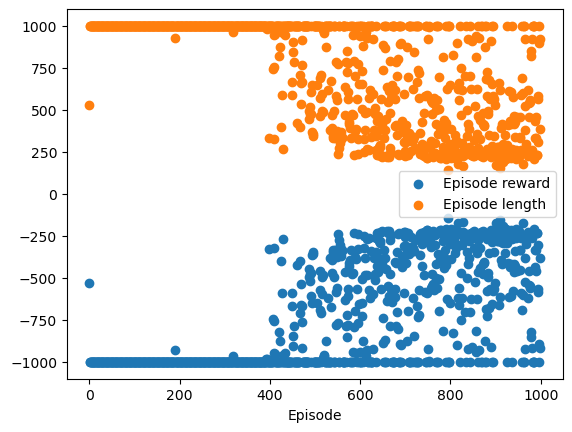

In [169]:
plt.figure()
plt.scatter(np.arange(len(list_rewards)),list_rewards, label="Episode reward")
plt.scatter(np.arange(len(list_lengths)),list_lengths, label="Episode length")
plt.xlabel("Episode") 
plt.legend()
plt.show()

Because of the sparse reward, the agend doesn't solve the task for episodes shorter than approximately 250 steps, tipycally not for the default duration 200 steps. If we allow longer steps, the agent is equivalent to random until it reaches once the goal, and after that it improves (his episode lenghts/episode rewards lowers/augments).

### 3.3 Heuristic reward function

In [170]:
def heuristic_reward_function(next_state):
    position, velocity = next_state

    # favour high speed to be able to climb the hill
    velocity_reward = velocity

    # favour positions close to the goal state 
    goal_position = 0.5
    position_reward = max(position, goal_position)

    # scale each reward 
    heuristic_reward = 0.5 * position_reward + 0.5 * velocity_reward
    return heuristic_reward

In [171]:
def run_episode_heuristic_DQN(agent, render=False, video_path="video.mp4", truncation = 200, heuristic_scaling=3):

    state, _ = environment.reset()
    done = False
    
    episode_reward = 0
    episode_length = 0
    if render:
        frame = environment.render()
        height, width, _ = frame.shape

        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(video_path, fourcc, 20.0, (width, height))

    while not done:
        if render:
            frame = environment.render()
            frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
            out.write(frame)

        action = agent.select_action(state)
        next_state, reward, terminated, truncated, _ = environment.step(action)
        heuristic_reward = heuristic_scaling * heuristic_reward_function(next_state) 
        reward = (heuristic_reward+reward)/(np.sqrt(heuristic_reward**2 + reward**2)) #normalized reward

        agent.observe(state, action, reward, next_state, terminated)

        if terminated:
            print("Goal Found:", episode_reward, episode_length)

        if (len(agent.replay_buffer) > agent.batch_size):
            agent.update()
            agent.update_epsilon()
        
        episode_reward += reward
        episode_length += 1
        state = next_state
        done = terminated or (episode_reward - 1 < -truncation)
        
    if render:
        out.release()
    return episode_reward, episode_length

In [172]:
environment = gym.make('MountainCar-v0', render_mode="rgb_array")
agent = DQNAgent(environment)

list_rewards, list_lengths = ([], [])
for episode in tqdm(range(3000)):
    if (episode==2999): kwargs = dict(render=True, video_path="video_dqn_3.3_trunc200.mp4")
    else: kwargs = dict(render=False)

    total_reward, duration = run_episode_heuristic_DQN(agent=agent,truncation = 200, **kwargs)
    list_rewards.append(total_reward)
    list_lengths.append(duration)

  0%|          | 1/3000 [00:00<17:34,  2.84it/s]

Goal Found: -148.20525259871474 746


  0%|          | 2/3000 [00:00<16:37,  3.01it/s]

Goal Found: -125.02305939223928 631
Goal Found: -39.134489081253044 202


  0%|          | 6/3000 [00:01<07:13,  6.91it/s]

Goal Found: -36.45841414911052 188
Goal Found: -38.68732983589933 200
Goal Found: -36.305695341031594 188


  0%|          | 8/3000 [00:01<07:09,  6.96it/s]

Goal Found: -57.1196231432 292
Goal Found: -51.75957249712392 265


  0%|          | 9/3000 [00:01<06:59,  7.12it/s]

Goal Found: -51.52797644570866 264


  0%|          | 12/3000 [00:02<15:26,  3.23it/s]

Goal Found: -115.39365500158935 582


  0%|          | 13/3000 [00:03<14:35,  3.41it/s]

Goal Found: -104.91083611883624 531


  0%|          | 14/3000 [00:03<14:43,  3.38it/s]

Goal Found: -124.18786562887753 627
Goal Found: -41.55935678126512 214


  1%|          | 17/3000 [00:03<09:17,  5.35it/s]

Goal Found: -45.508529331764905 234
Goal Found: -48.73210472701037 250


  1%|          | 19/3000 [00:04<08:52,  5.60it/s]

Goal Found: -63.61537773398736 324
Goal Found: -60.698409859873976 309


  1%|          | 21/3000 [00:04<08:13,  6.03it/s]

Goal Found: -62.115652678077325 316
Goal Found: -62.005564101674054 316


  1%|          | 23/3000 [00:04<06:54,  7.18it/s]

Goal Found: -44.688906151391045 230
Goal Found: -46.66279178271116 240


  1%|          | 25/3000 [00:04<06:15,  7.93it/s]

Goal Found: -41.72291855042377 215
Goal Found: -49.50616102157244 253


  1%|          | 27/3000 [00:04<05:57,  8.31it/s]

Goal Found: -47.0485448002578 241
Goal Found: -42.58871727487885 219
Goal Found: -31.417351803141628 163


  1%|          | 31/3000 [00:05<05:07,  9.66it/s]

Goal Found: -54.104706889243104 276
Goal Found: -39.57153683136948 204
Goal Found: -30.524019432492505 159


  1%|          | 33/3000 [00:05<05:10,  9.55it/s]

Goal Found: -42.96412127727811 221
Goal Found: -40.74066315333965 210


  1%|          | 36/3000 [00:05<04:35, 10.77it/s]

Goal Found: -45.514209119593986 234
Goal Found: -29.83537498176051 155
Goal Found: -30.778113341440058 160


  1%|▏         | 38/3000 [00:06<04:40, 10.57it/s]

Goal Found: -45.34728924098024 233
Goal Found: -31.079353098258238 161


  1%|▏         | 40/3000 [00:06<05:06,  9.66it/s]

Goal Found: -63.517553737029196 323
Goal Found: -32.23044848241794 167


  1%|▏         | 41/3000 [00:06<07:53,  6.25it/s]

Goal Found: -147.22861993092326 742


  1%|▏         | 43/3000 [00:07<08:28,  5.81it/s]

Goal Found: -86.75682297728343 440
Goal Found: -68.25362364500653 347


  2%|▏         | 45/3000 [00:07<09:43,  5.07it/s]

Goal Found: -141.625968767978 714
Goal Found: -58.607491655025875 299


  2%|▏         | 46/3000 [00:07<09:39,  5.09it/s]

Goal Found: -78.02460136433433 397


  2%|▏         | 49/3000 [00:08<13:17,  3.70it/s]

Goal Found: -173.81403472326042 875
Goal Found: -57.42362883917632 294


  2%|▏         | 51/3000 [00:09<09:35,  5.13it/s]

Goal Found: -51.25672887175742 262
Goal Found: -44.63789577147699 229


  2%|▏         | 53/3000 [00:09<07:52,  6.23it/s]

Goal Found: -53.5103800287892 273
Goal Found: -51.32543819263796 262


  2%|▏         | 55/3000 [00:09<06:48,  7.21it/s]

Goal Found: -49.43222284091287 253
Goal Found: -43.89172596181409 226


  2%|▏         | 57/3000 [00:09<06:13,  7.88it/s]

Goal Found: -52.39593722543921 268
Goal Found: -39.900697535696175 206


  2%|▏         | 59/3000 [00:10<06:01,  8.14it/s]

Goal Found: -39.95523535820111 206
Goal Found: -50.180530594732474 257


  2%|▏         | 61/3000 [00:10<05:43,  8.55it/s]

Goal Found: -43.298061451984395 223
Goal Found: -42.12988756841007 217


  2%|▏         | 62/3000 [00:10<05:36,  8.73it/s]

Goal Found: -41.32569095230558 213
Goal Found: -32.87107245679652 170


  2%|▏         | 64/3000 [00:10<05:40,  8.61it/s]

Goal Found: -48.562228515475454 248
Goal Found: -36.37530803101276 188


  2%|▏         | 67/3000 [00:10<05:19,  9.17it/s]

Goal Found: -46.02675194691639 236
Goal Found: -41.69488710713029 215


  2%|▏         | 69/3000 [00:11<05:52,  8.32it/s]

Goal Found: -40.001443697387515 206
Goal Found: -48.42769733915337 248


  2%|▏         | 72/3000 [00:11<05:27,  8.93it/s]

Goal Found: -47.07236062253318 241
Goal Found: -37.36711993514569 193
Goal Found: -41.90558151903856 216


  2%|▏         | 74/3000 [00:11<05:02,  9.66it/s]

Goal Found: -34.07180272062808 176
Goal Found: -35.46386207352502 183


  3%|▎         | 77/3000 [00:11<04:59,  9.76it/s]

Goal Found: -48.18226519953439 247
Goal Found: -37.51296269145679 194
Goal Found: -37.2365045280764 192


  3%|▎         | 79/3000 [00:12<05:24,  9.01it/s]

Goal Found: -51.9287953334725 266
Goal Found: -41.74916705533192 215


  3%|▎         | 82/3000 [00:12<05:03,  9.62it/s]

Goal Found: -38.9628413728179 201
Goal Found: -37.64722331473207 194
Goal Found: -40.72961190987445 210


  3%|▎         | 84/3000 [00:12<05:24,  8.98it/s]

Goal Found: -39.84626717316492 205
Goal Found: -57.748985313522454 295


  3%|▎         | 86/3000 [00:12<05:03,  9.60it/s]

Goal Found: -28.58586562109131 150
Goal Found: -41.89337963953007 216


  3%|▎         | 88/3000 [00:13<05:12,  9.30it/s]

Goal Found: -47.32191062316699 242
Goal Found: -41.3060709309332 213
Goal Found: -34.05351217003273 176


  3%|▎         | 91/3000 [00:13<04:55,  9.85it/s]

Goal Found: -32.23549186293902 167
Goal Found: -43.528778825759055 224


  3%|▎         | 93/3000 [00:13<05:26,  8.90it/s]

Goal Found: -49.860725273461384 255
Goal Found: -49.853901663634815 255


  3%|▎         | 95/3000 [00:13<04:56,  9.80it/s]

Goal Found: -34.48880228193458 178
Goal Found: -36.305529937874724 188
Goal Found: -32.772791742365776 170


  3%|▎         | 99/3000 [00:14<04:44, 10.20it/s]

Goal Found: -38.443607666498565 198
Goal Found: -39.115934523329464 202
Goal Found: -39.7339849049302 205


  3%|▎         | 101/3000 [00:14<05:32,  8.72it/s]

Goal Found: -70.72606328536045 360
Goal Found: -48.93872317044021 251
Goal Found: -32.23630872258349 167


  4%|▎         | 105/3000 [00:14<04:56,  9.78it/s]

Goal Found: -56.27957644220235 287
Goal Found: -28.36076833327143 148
Goal Found: -34.68602057183604 180


  4%|▎         | 107/3000 [00:15<04:44, 10.16it/s]

Goal Found: -31.425421218557428 163
Goal Found: -40.92739093186786 211
Goal Found: -29.96184947317448 156


  4%|▎         | 111/3000 [00:15<04:13, 11.40it/s]

Goal Found: -31.320810328609582 163
Goal Found: -28.944534981072884 151
Goal Found: -31.904472589252137 165


  4%|▍         | 113/3000 [00:15<04:22, 10.99it/s]

Goal Found: -31.076054497527696 161
Goal Found: -42.495354979026104 219
Goal Found: -29.314386755332276 153


  4%|▍         | 117/3000 [00:15<03:49, 12.55it/s]

Goal Found: -30.519501382050407 158
Goal Found: -28.06298123535342 147
Goal Found: -17.82920742744647 95
Goal Found: -29.011014459302846 151


  4%|▍         | 121/3000 [00:16<03:38, 13.20it/s]

Goal Found: -30.24652577276307 157
Goal Found: -27.949443255070104 146
Goal Found: -27.411985299709695 144
Goal Found: -17.62747397966887 94


  4%|▍         | 125/3000 [00:16<03:28, 13.80it/s]

Goal Found: -32.53583761879211 168
Goal Found: -31.81281571840533 165
Goal Found: -18.399091379567654 98


  4%|▍         | 127/3000 [00:16<03:34, 13.42it/s]

Goal Found: -30.102574443524453 156
Goal Found: -31.506527775715536 163
Goal Found: -27.78234268899786 145


  4%|▍         | 131/3000 [00:16<03:37, 13.22it/s]

Goal Found: -28.65707248464902 150
Goal Found: -30.298643190510067 158
Goal Found: -29.899910631118168 155


  4%|▍         | 133/3000 [00:17<03:33, 13.42it/s]

Goal Found: -27.698306194353375 145
Goal Found: -28.854106052395686 151
Goal Found: -30.294763193708718 157


  5%|▍         | 137/3000 [00:17<03:23, 14.10it/s]

Goal Found: -28.197254093703467 147
Goal Found: -30.15994245021378 156
Goal Found: -18.026860638837892 96


  5%|▍         | 139/3000 [00:17<03:38, 13.10it/s]

Goal Found: -39.9859986106749 206
Goal Found: -29.30418746934565 152
Goal Found: -32.9130197833494 170


  5%|▍         | 143/3000 [00:17<03:23, 14.01it/s]

Goal Found: -22.392393775751394 119
Goal Found: -20.57981569996944 110
Goal Found: -29.38672142165607 153
Goal Found: -21.39380725822611 113


  5%|▍         | 147/3000 [00:18<03:11, 14.88it/s]

Goal Found: -29.358076382797485 153
Goal Found: -17.754813661968228 95
Goal Found: -33.34015127190202 172
Goal Found: -26.660570615287693 140


  5%|▌         | 151/3000 [00:18<03:21, 14.14it/s]

Goal Found: -25.41257649007331 134
Goal Found: -28.26062691781803 147
Goal Found: -33.6109056758062 174


  5%|▌         | 153/3000 [00:18<03:42, 12.80it/s]

Goal Found: -26.968857008647205 141
Goal Found: -31.08497855442672 161
Goal Found: -19.969159324823764 106


  5%|▌         | 157/3000 [00:18<03:25, 13.81it/s]

Goal Found: -31.152095295399448 161
Goal Found: -22.439667497660285 119
Goal Found: -28.65022118359042 150


  5%|▌         | 161/3000 [00:19<03:21, 14.12it/s]

Goal Found: -30.281156814879374 158
Goal Found: -28.108263482086013 147
Goal Found: -28.24330743771864 148
Goal Found: -19.215194341556465 102


  6%|▌         | 165/3000 [00:19<03:09, 14.96it/s]

Goal Found: -20.556561592163177 109
Goal Found: -21.80322748980894 116
Goal Found: -27.752157916547834 145
Goal Found: -27.230006399986323 142


  6%|▌         | 169/3000 [00:19<03:16, 14.44it/s]

Goal Found: -46.59472746448007 239
Goal Found: -16.20792633872037 87
Goal Found: -33.053159439461695 172
Goal Found: -18.178319577452346 97


  6%|▌         | 171/3000 [00:19<03:08, 15.03it/s]

Goal Found: -16.817952895709823 90
Goal Found: -30.89284149563979 160
Goal Found: -33.452541935693915 173


  6%|▌         | 175/3000 [00:20<03:28, 13.54it/s]

Goal Found: -30.204754689320428 157
Goal Found: -32.42251962448463 168
Goal Found: -30.127352729932547 156


  6%|▌         | 177/3000 [00:20<03:29, 13.50it/s]

Goal Found: -26.13475614677946 137
Goal Found: -27.690836139531648 145
Goal Found: -41.348649982053395 213


  6%|▌         | 181/3000 [00:20<03:32, 13.24it/s]

Goal Found: -17.238417881000156 92
Goal Found: -34.10002871697421 176
Goal Found: -21.858750576177922 116
Goal Found: -16.824909598552495 90


  6%|▌         | 183/3000 [00:20<03:29, 13.44it/s]

Goal Found: -40.36437424001482 208
Goal Found: -61.474030437045265 314


  6%|▌         | 187/3000 [00:21<03:32, 13.21it/s]

Goal Found: -30.595579072079893 159
Goal Found: -17.44953399694182 93
Goal Found: -21.50273464724618 114
Goal Found: -32.849130615237684 171


  6%|▋         | 191/3000 [00:21<03:31, 13.28it/s]

Goal Found: -27.86616885441011 146
Goal Found: -30.49589246877955 158
Goal Found: -26.876980500284407 141


  6%|▋         | 195/3000 [00:21<03:11, 14.67it/s]

Goal Found: -27.80807843464497 145
Goal Found: -20.079152354656486 107
Goal Found: -27.024169552320956 141
Goal Found: -18.624239075989646 99


  7%|▋         | 197/3000 [00:21<03:14, 14.40it/s]

Goal Found: -26.41117306606799 138
Goal Found: -29.754489612132566 155
Goal Found: -32.48328172512071 168


  7%|▋         | 201/3000 [00:22<03:24, 13.71it/s]

Goal Found: -25.47275966004316 134
Goal Found: -28.532055842048162 149
Goal Found: -30.046917751810586 157


  7%|▋         | 203/3000 [00:22<03:30, 13.28it/s]

Goal Found: -31.393980208553828 163
Goal Found: -31.32271869015129 163
Goal Found: -30.08127001377316 156


  7%|▋         | 207/3000 [00:22<03:27, 13.44it/s]

Goal Found: -29.582790723378217 154
Goal Found: -30.313218481153584 158
Goal Found: -28.30826047757693 148
Goal Found: -17.196757344143087 92


  7%|▋         | 211/3000 [00:22<03:33, 13.05it/s]

Goal Found: -31.898842697199974 166
Goal Found: -31.77165487082885 165
Goal Found: -38.297613912425504 198


  7%|▋         | 215/3000 [00:23<03:18, 14.04it/s]

Goal Found: -31.155664883320746 162
Goal Found: -31.13038727949144 161
Goal Found: -17.263918333016473 92
Goal Found: -28.057343315425275 147


  7%|▋         | 217/3000 [00:23<03:22, 13.74it/s]

Goal Found: -31.272826046473504 162
Goal Found: -29.35711631050133 153
Goal Found: -23.22025797873166 123


  7%|▋         | 221/3000 [00:23<03:08, 14.78it/s]

Goal Found: -28.162337021303674 147
Goal Found: -17.23532552087787 92
Goal Found: -28.827887612709258 150
Goal Found: -21.416014868445526 114


  8%|▊         | 225/3000 [00:23<03:22, 13.72it/s]

Goal Found: -32.0730806085161 166
Goal Found: -35.514712042560156 184
Goal Found: -29.234268978255844 153


  8%|▊         | 229/3000 [00:24<03:14, 14.22it/s]

Goal Found: -30.4128181454496 159
Goal Found: -27.431918635540562 144
Goal Found: -31.242747362514688 162
Goal Found: -17.215650929906985 92


  8%|▊         | 231/3000 [00:24<03:09, 14.60it/s]

Goal Found: -29.347011221026623 153
Goal Found: -19.324166099553857 103
Goal Found: -45.106195997822546 232


  8%|▊         | 235/3000 [00:24<03:27, 13.30it/s]

Goal Found: -28.354971037354595 148
Goal Found: -30.194499170962843 157
Goal Found: -25.20301055782684 133
Goal Found: -21.26007232938495 113


  8%|▊         | 237/3000 [00:24<03:17, 14.02it/s]

Goal Found: -28.06169652262914 146
Goal Found: -29.972161961130293 156
Goal Found: -30.071892506708572 156


  8%|▊         | 241/3000 [00:24<03:37, 12.67it/s]

Goal Found: -26.8828951875974 141
Goal Found: -29.966041900312906 156
Goal Found: -29.244081990299858 153


  8%|▊         | 245/3000 [00:25<03:39, 12.54it/s]

Goal Found: -22.951608531798257 121
Goal Found: -34.07643802139521 176
Goal Found: -32.740909929959265 169


  8%|▊         | 249/3000 [00:25<03:22, 13.55it/s]

Goal Found: -34.400151340463424 178
Goal Found: -26.743144432366286 140
Goal Found: -30.02961111288728 156
Goal Found: -16.019744764118585 86


  8%|▊         | 251/3000 [00:25<03:27, 13.28it/s]

Goal Found: -30.853121858259946 160
Goal Found: -31.206489261238804 162
Goal Found: -33.39356249221188 173


  8%|▊         | 255/3000 [00:26<03:23, 13.48it/s]

Goal Found: -34.44538349085174 179
Goal Found: -20.028245790570004 107
Goal Found: -30.954965200332705 160
Goal Found: -19.83752429954848 106


  9%|▊         | 259/3000 [00:26<03:04, 14.88it/s]

Goal Found: -26.987161283220335 141
Goal Found: -17.40199003059869 93
Goal Found: -29.482837109712964 153


  9%|▊         | 261/3000 [00:26<03:20, 13.68it/s]

Goal Found: -41.32527699015966 213
Goal Found: -28.68968961244829 150
Goal Found: -28.314788173485116 148


  9%|▉         | 265/3000 [00:26<03:21, 13.57it/s]

Goal Found: -28.208934370272026 147
Goal Found: -29.517789985756984 154
Goal Found: -26.68995358745924 140


  9%|▉         | 269/3000 [00:26<03:03, 14.90it/s]

Goal Found: -29.653708412350046 155
Goal Found: -20.075197801180426 107
Goal Found: -23.88964246173385 126
Goal Found: -22.227244696545792 118


  9%|▉         | 271/3000 [00:27<03:14, 14.05it/s]

Goal Found: -32.53329977111066 168
Goal Found: -30.70326435440857 160
Goal Found: -34.16998981404132 176


  9%|▉         | 275/3000 [00:27<03:34, 12.71it/s]

Goal Found: -28.842610965062697 150
Goal Found: -29.931236971289334 156
Goal Found: -41.488862824313 214


  9%|▉         | 277/3000 [00:27<03:22, 13.48it/s]

Goal Found: -19.020652059764306 101
Goal Found: -28.364829540488575 148
Goal Found: -22.988487238341243 121


  9%|▉         | 281/3000 [00:27<03:32, 12.80it/s]

Goal Found: -29.512226206926943 154
Goal Found: -38.30203878256547 197
Goal Found: -36.11259900710326 186


  9%|▉         | 283/3000 [00:28<03:56, 11.51it/s]

Goal Found: -45.65383883336616 234
Goal Found: -36.84243724217852 191
Goal Found: -29.00132738012934 151


 10%|▉         | 287/3000 [00:28<03:12, 14.07it/s]

Goal Found: -16.017545153944674 86
Goal Found: -20.184419205325916 107
Goal Found: -20.5028666891284 109
Goal Found: -31.455217254809 163


 10%|▉         | 291/3000 [00:28<03:16, 13.80it/s]

Goal Found: -30.425474232935116 158
Goal Found: -28.82293229602419 150
Goal Found: -29.27585259854035 153
Goal Found: -16.618895702737753 89


 10%|▉         | 294/3000 [00:28<02:47, 16.18it/s]

Goal Found: -16.800435423001744 90
Goal Found: -17.625024236818046 94
Goal Found: -26.485628716371608 139


 10%|▉         | 296/3000 [00:28<03:00, 14.97it/s]

Goal Found: -36.20775926613272 187
Goal Found: -46.889948717270386 241


 10%|█         | 300/3000 [00:29<03:23, 13.26it/s]

Goal Found: -34.061799521954086 176
Goal Found: -18.953757820166985 101
Goal Found: -29.18962096363544 152


 10%|█         | 302/3000 [00:29<03:24, 13.17it/s]

Goal Found: -28.330727904286626 148
Goal Found: -29.747979101549422 155
Goal Found: -31.049777041656 161


 10%|█         | 306/3000 [00:29<03:19, 13.53it/s]

Goal Found: -30.19624651283208 157
Goal Found: -27.568530234558956 144
Goal Found: -26.422584880251627 138


 10%|█         | 308/3000 [00:29<03:04, 14.60it/s]

Goal Found: -28.63926887845793 149
Goal Found: -16.812372917393297 90
Goal Found: -33.427868695846726 173


 10%|█         | 312/3000 [00:30<02:59, 14.94it/s]

Goal Found: -30.439992510525457 158
Goal Found: -20.99802903809184 111
Goal Found: -23.323506599219378 123
Goal Found: -30.009580800901855 156


 11%|█         | 316/3000 [00:30<03:08, 14.20it/s]

Goal Found: -23.677683584770165 125
Goal Found: -17.611812134929824 94
Goal Found: -46.88751126567513 241


 11%|█         | 318/3000 [00:30<03:20, 13.38it/s]

Goal Found: -27.090420707154085 142
Goal Found: -41.9433670724612 216
Goal Found: -29.796469281945527 155


 11%|█         | 322/3000 [00:30<03:10, 14.04it/s]

Goal Found: -19.22720915190056 102
Goal Found: -23.524383062186118 124
Goal Found: -31.3653222854226 164


 11%|█         | 324/3000 [00:31<03:08, 14.20it/s]

Goal Found: -29.445978501581557 154
Goal Found: -23.94663639949124 126
Goal Found: -29.69229109560225 155


 11%|█         | 328/3000 [00:31<03:33, 12.51it/s]

Goal Found: -31.83540650334473 165
Goal Found: -33.478950495122795 173
Goal Found: -29.923251636668464 155


 11%|█         | 330/3000 [00:31<03:28, 12.79it/s]

Goal Found: -35.14978032653947 181
Goal Found: -26.488805676445388 139
Goal Found: -28.91288882700275 151


 11%|█         | 334/3000 [00:31<03:37, 12.28it/s]

Goal Found: -34.12847948482929 176
Goal Found: -37.39067640203186 194
Goal Found: -31.725522247630902 165


 11%|█▏        | 338/3000 [00:32<03:07, 14.20it/s]

Goal Found: -28.82383404096782 150
Goal Found: -17.42911776196393 93
Goal Found: -29.64182441573703 155
Goal Found: -15.666576325796497 84


 11%|█▏        | 342/3000 [00:32<03:10, 13.95it/s]

Goal Found: -35.68718732044028 184
Goal Found: -18.97390048467533 101
Goal Found: -28.77795619790666 150
Goal Found: -27.858087154067693 146


 11%|█▏        | 344/3000 [00:32<03:16, 13.52it/s]

Goal Found: -35.42958660241445 184
Goal Found: -28.18658401157817 147
Goal Found: -26.70495614555559 140


 12%|█▏        | 348/3000 [00:32<03:24, 13.00it/s]

Goal Found: -28.61716494298554 149
Goal Found: -25.889359559490916 136
Goal Found: -44.587913304929984 229


 12%|█▏        | 350/3000 [00:33<03:21, 13.15it/s]

Goal Found: -31.392696283772416 163
Goal Found: -29.69461217323828 155
Goal Found: -19.142400529254367 102
Goal Found: -31.4456687161535 163


 12%|█▏        | 354/3000 [00:33<03:12, 13.77it/s]

Goal Found: -29.8169441007894 155
Goal Found: -26.930951075281804 141
Goal Found: -35.452955709686684 184


 12%|█▏        | 358/3000 [00:33<03:18, 13.31it/s]

Goal Found: -27.983864506727926 146
Goal Found: -32.17158519837586 167
Goal Found: -31.822093011445183 165


 12%|█▏        | 360/3000 [00:33<03:21, 13.12it/s]

Goal Found: -36.45796389833455 188
Goal Found: -27.899967619467 146
Goal Found: -27.914333751919294 146


 12%|█▏        | 364/3000 [00:34<03:12, 13.73it/s]

Goal Found: -27.894869784905993 146
Goal Found: -27.108106558966508 142
Goal Found: -27.28433719951123 143


 12%|█▏        | 366/3000 [00:34<03:15, 13.49it/s]

Goal Found: -27.086345992149116 142
Goal Found: -32.59618395967947 169
Goal Found: -30.236727025945715 157


 12%|█▏        | 370/3000 [00:34<03:06, 14.09it/s]

Goal Found: -16.81474762109427 90
Goal Found: -28.79514043111118 151
Goal Found: -30.06686625051401 156


 12%|█▏        | 374/3000 [00:34<02:58, 14.68it/s]

Goal Found: -26.84944379310532 141
Goal Found: -15.463418885025908 83
Goal Found: -27.08211825041778 142
Goal Found: -28.070279354893444 147


 13%|█▎        | 376/3000 [00:34<03:01, 14.43it/s]

Goal Found: -28.179208634748626 147
Goal Found: -27.91907351704205 146
Goal Found: -27.314556176639137 143


 13%|█▎        | 380/3000 [00:35<03:05, 14.12it/s]

Goal Found: -27.726345808884748 145
Goal Found: -28.85028928426774 150
Goal Found: -30.840389328729017 160


 13%|█▎        | 384/3000 [00:35<03:01, 14.38it/s]

Goal Found: -29.261938364769446 152
Goal Found: -26.2852279115734 138
Goal Found: -27.41770698683102 143
Goal Found: -26.137078495055373 137


 13%|█▎        | 388/3000 [00:35<02:51, 15.20it/s]

Goal Found: -32.916944460064926 170
Goal Found: -16.61761513312812 89
Goal Found: -16.241500278527884 87
Goal Found: -33.084750140497285 171


 13%|█▎        | 390/3000 [00:35<03:01, 14.36it/s]

Goal Found: -25.734040357407885 135
Goal Found: -36.0344021366174 186
Goal Found: -33.42305791085738 173


 13%|█▎        | 394/3000 [00:36<03:10, 13.68it/s]

Goal Found: -20.609535928414957 109
Goal Found: -26.637886423263016 140
Goal Found: -34.32548180560432 177


 13%|█▎        | 396/3000 [00:36<03:13, 13.47it/s]

Goal Found: -27.766986324276097 145
Goal Found: -31.727854581986254 164
Goal Found: -30.22625665149762 157


 13%|█▎        | 400/3000 [00:36<03:10, 13.66it/s]

Goal Found: -18.82776012777728 100
Goal Found: -29.82603646466611 155
Goal Found: -29.71043068455581 155


 13%|█▎        | 404/3000 [00:36<02:57, 14.62it/s]

Goal Found: -28.44735427817677 148
Goal Found: -28.76085295472755 150
Goal Found: -27.67893267588896 145
Goal Found: -18.030292361441592 96


 14%|█▎        | 406/3000 [00:36<03:07, 13.81it/s]

Goal Found: -28.144514117036035 147
Goal Found: -33.63584098919384 175
Goal Found: -27.49827167607015 143


 14%|█▎        | 410/3000 [00:37<03:27, 12.48it/s]

Goal Found: -35.38037472468299 182
Goal Found: -29.193290681834448 152
Goal Found: -28.89537167791567 150


 14%|█▎        | 412/3000 [00:37<03:21, 12.85it/s]

Goal Found: -28.668683435652333 149
Goal Found: -27.63964916083265 144
Goal Found: -27.075470868181498 142


 14%|█▍        | 416/3000 [00:37<03:16, 13.14it/s]

Goal Found: -34.496981530435974 178
Goal Found: -32.91214983295979 170
Goal Found: -26.104266047372185 137


 14%|█▍        | 420/3000 [00:38<02:59, 14.38it/s]

Goal Found: -30.563325387909643 158
Goal Found: -16.836958973391628 90
Goal Found: -27.92181010255225 146
Goal Found: -24.635161596623266 130


 14%|█▍        | 422/3000 [00:38<02:58, 14.44it/s]

Goal Found: -28.088609799921763 147
Goal Found: -27.983184289352103 146
Goal Found: -26.128694963720342 137


 14%|█▍        | 426/3000 [00:38<03:07, 13.70it/s]

Goal Found: -28.222793684319427 147
Goal Found: -33.68671963115169 174
Goal Found: -29.78447523843819 155


 14%|█▍        | 428/3000 [00:38<02:58, 14.43it/s]

Goal Found: -16.609109283812963 89
Goal Found: -27.39029068158274 143
Goal Found: -38.49913929437595 198


 14%|█▍        | 432/3000 [00:38<03:12, 13.31it/s]

Goal Found: -29.749103798689195 155
Goal Found: -33.3811879935703 174
Goal Found: -27.32152541790228 143


 14%|█▍        | 434/3000 [00:39<03:11, 13.42it/s]

Goal Found: -26.796053640955297 140
Goal Found: -27.713466937808203 144
Goal Found: -28.683786647621297 150


 15%|█▍        | 438/3000 [00:39<03:00, 14.20it/s]

Goal Found: -27.913305675271452 146
Goal Found: -27.67639436366175 145
Goal Found: -18.947307141447155 101
Goal Found: -27.664096446023898 145


 15%|█▍        | 442/3000 [00:39<03:00, 14.21it/s]

Goal Found: -26.71834556389762 140
Goal Found: -29.435618774819293 153
Goal Found: -27.724478095853673 145


 15%|█▍        | 444/3000 [00:39<03:01, 14.07it/s]

Goal Found: -28.8115423346014 150
Goal Found: -28.547175240147872 149
Goal Found: -29.294079562312945 152


 15%|█▍        | 448/3000 [00:40<03:00, 14.10it/s]

Goal Found: -28.59420597837628 149
Goal Found: -25.08239109401519 132
Goal Found: -29.92966818505946 156


 15%|█▌        | 450/3000 [00:40<03:04, 13.86it/s]

Goal Found: -34.135560476011605 176
Goal Found: -26.553618786328855 139
Goal Found: -28.7431760965325 150


 15%|█▌        | 454/3000 [00:40<03:11, 13.30it/s]

Goal Found: -28.066879058463954 147
Goal Found: -26.46556842227661 139
Goal Found: -30.49422918281685 158


 15%|█▌        | 458/3000 [00:40<02:57, 14.31it/s]

Goal Found: -27.533379704153017 144
Goal Found: -27.484439642039842 143
Goal Found: -20.212867080645402 108
Goal Found: -28.56044998740576 149


 15%|█▌        | 462/3000 [00:41<02:50, 14.85it/s]

Goal Found: -27.785245860923215 145
Goal Found: -31.06240040925575 161
Goal Found: -30.476619579249448 158
Goal Found: -16.05524460571236 86


 15%|█▌        | 464/3000 [00:41<02:56, 14.38it/s]

Goal Found: -22.79238164150649 120
Goal Found: -34.15929859285178 176
Goal Found: -39.81446170477982 206


 16%|█▌        | 468/3000 [00:41<03:19, 12.67it/s]

Goal Found: -45.92525488653455 236
Goal Found: -28.50993160384292 149
Goal Found: -27.219076372647034 142


 16%|█▌        | 470/3000 [00:41<03:18, 12.77it/s]

Goal Found: -29.9214438416532 156
Goal Found: -28.364985213569877 148
Goal Found: -27.97165942831962 146


 16%|█▌        | 474/3000 [00:42<03:11, 13.19it/s]

Goal Found: -29.177557927987685 151
Goal Found: -29.108664187978974 151
Goal Found: -26.87201128974704 140


 16%|█▌        | 476/3000 [00:42<03:24, 12.34it/s]

Goal Found: -26.527776453188004 139
Goal Found: -26.06914386173146 136
Goal Found: -26.629805501874007 139


 16%|█▌        | 480/3000 [00:42<03:09, 13.32it/s]

Goal Found: -33.44389190477957 173
Goal Found: -26.78809399970444 140
Goal Found: -26.034086128042407 137


 16%|█▌        | 482/3000 [00:42<03:12, 13.08it/s]

Goal Found: -30.484159525668233 158
Goal Found: -34.081742790951495 177
Goal Found: -31.936506196793147 165


 16%|█▌        | 486/3000 [00:42<03:06, 13.51it/s]

Goal Found: -27.54054175204212 144
Goal Found: -25.043569334963873 132
Goal Found: -28.707379933172984 150


 16%|█▋        | 488/3000 [00:43<03:03, 13.66it/s]

Goal Found: -27.369756642030165 143
Goal Found: -27.38636230194485 143
Goal Found: -40.52884934484618 208


 16%|█▋        | 492/3000 [00:43<03:13, 12.99it/s]

Goal Found: -26.69386101021909 140
Goal Found: -28.227653551392073 147
Goal Found: -32.52978717091371 169


 16%|█▋        | 494/3000 [00:43<03:03, 13.63it/s]

Goal Found: -21.81599561816049 115
Goal Found: -29.692122436508495 154
Goal Found: -26.19684957254819 137


 17%|█▋        | 498/3000 [00:43<03:02, 13.69it/s]

Goal Found: -30.54201066407583 158
Goal Found: -26.863812320642378 140
Goal Found: -29.857615042878425 155


 17%|█▋        | 502/3000 [00:44<02:49, 14.71it/s]

Goal Found: -27.06723072720211 142
Goal Found: -26.50521063904232 139
Goal Found: -25.302627908022764 133
Goal Found: -20.16890160869673 107


 17%|█▋        | 504/3000 [00:44<02:53, 14.41it/s]

Goal Found: -28.368636466983844 148
Goal Found: -28.85609696173178 150
Goal Found: -30.436209548621438 158


 17%|█▋        | 508/3000 [00:44<02:55, 14.23it/s]

Goal Found: -27.490521416788823 143
Goal Found: -26.932493645738067 141
Goal Found: -30.667354324812337 159
Goal Found: -17.240177213458026 92


 17%|█▋        | 512/3000 [00:44<02:48, 14.76it/s]

Goal Found: -26.644875644479338 139
Goal Found: -29.15088088510092 152
Goal Found: -27.891390510102845 146


 17%|█▋        | 514/3000 [00:44<02:48, 14.79it/s]

Goal Found: -25.805089357279552 135
Goal Found: -27.5899793347482 144
Goal Found: -25.771656482262735 135


 17%|█▋        | 518/3000 [00:45<02:48, 14.70it/s]

Goal Found: -25.40410215126475 133
Goal Found: -25.668130590717094 135
Goal Found: -28.33888872615437 148


 17%|█▋        | 522/3000 [00:45<02:44, 15.09it/s]

Goal Found: -26.29001477463805 138
Goal Found: -25.780258460487936 135
Goal Found: -27.57953320184938 143
Goal Found: -20.273947851207758 108


 17%|█▋        | 524/3000 [00:45<02:38, 15.59it/s]

Goal Found: -16.222759330154442 87
Goal Found: -27.785916448773463 145
Goal Found: -29.354192178653193 153


 18%|█▊        | 528/3000 [00:45<02:53, 14.21it/s]

Goal Found: -27.756919271187677 145
Goal Found: -34.869794052811024 180
Goal Found: -27.886449967231513 146


 18%|█▊        | 530/3000 [00:45<02:55, 14.08it/s]

Goal Found: -29.892595592364533 156
Goal Found: -27.732458239311626 145
Goal Found: -26.39261396600095 138


 18%|█▊        | 534/3000 [00:46<03:10, 12.94it/s]

Goal Found: -26.314562217420402 138
Goal Found: -42.28331050461013 218
Goal Found: -30.235743532392362 158


 18%|█▊        | 536/3000 [00:46<03:28, 11.84it/s]

Goal Found: -29.95240570508125 155
Goal Found: -48.88929031380549 251
Goal Found: -27.94248843428464 146


 18%|█▊        | 540/3000 [00:46<03:14, 12.64it/s]

Goal Found: -30.496124247187772 158
Goal Found: -26.400143990025608 138
Goal Found: -28.39385284841304 148


 18%|█▊        | 544/3000 [00:47<03:00, 13.61it/s]

Goal Found: -30.442178384917828 159
Goal Found: -16.604827466587306 89
Goal Found: -27.442362715903194 144
Goal Found: -29.39274398540153 153


 18%|█▊        | 546/3000 [00:47<02:56, 13.91it/s]

Goal Found: -22.760043023923103 120
Goal Found: -28.69306652923067 150
Goal Found: -26.53579586144984 138


 18%|█▊        | 550/3000 [00:47<03:07, 13.10it/s]

Goal Found: -18.638369031419327 99
Goal Found: -28.81027237667479 150
Goal Found: -26.372764517496325 138


 18%|█▊        | 552/3000 [00:47<03:06, 13.11it/s]

Goal Found: -27.264517580719836 143
Goal Found: -28.50440375829179 149
Goal Found: -28.084772351045476 147


 19%|█▊        | 556/3000 [00:47<02:58, 13.70it/s]

Goal Found: -30.599005113284615 159
Goal Found: -17.98271910491712 96
Goal Found: -29.315401634462646 152
Goal Found: -26.1121760381478 137


 19%|█▊        | 560/3000 [00:48<02:48, 14.48it/s]

Goal Found: -29.21725044944451 152
Goal Found: -21.608748521301692 114
Goal Found: -26.247230868002767 138


 19%|█▊        | 562/3000 [00:48<02:56, 13.82it/s]

Goal Found: -29.35026464450288 153
Goal Found: -30.834486676145055 160
Goal Found: -35.92107894390068 185


 19%|█▉        | 566/3000 [00:48<02:58, 13.66it/s]

Goal Found: -27.905335746871863 146
Goal Found: -26.036611792535865 137
Goal Found: -26.27318794057391 138
Goal Found: -20.220506810381323 107


 19%|█▉        | 570/3000 [00:48<02:53, 14.01it/s]

Goal Found: -32.046584763559395 166
Goal Found: -28.38975658010559 148
Goal Found: -28.893205017487368 150


 19%|█▉        | 574/3000 [00:49<02:45, 14.66it/s]

Goal Found: -35.68843928044014 184
Goal Found: -26.992705400598343 141
Goal Found: -27.64624334462943 144
Goal Found: -18.035595045684985 96


 19%|█▉        | 576/3000 [00:49<02:51, 14.12it/s]

Goal Found: -30.076331946666116 156
Goal Found: -26.59492920113867 139
Goal Found: -28.968970800189553 151


 19%|█▉        | 580/3000 [00:49<02:52, 14.03it/s]

Goal Found: -27.458373425918502 143
Goal Found: -28.234328372732893 147
Goal Found: -28.30006555329192 147


 19%|█▉        | 582/3000 [00:49<02:51, 14.09it/s]

Goal Found: -29.0298342245607 151
Goal Found: -27.75223506027887 145
Goal Found: -25.664589378724905 135


 20%|█▉        | 586/3000 [00:50<02:48, 14.37it/s]

Goal Found: -28.337884213485452 147
Goal Found: -25.095036773038565 132
Goal Found: -27.901003179386887 146


 20%|█▉        | 588/3000 [00:50<02:51, 14.07it/s]

Goal Found: -27.41473996724566 143
Goal Found: -28.888797419113647 151
Goal Found: -27.519387628466074 143


 20%|█▉        | 592/3000 [00:50<03:13, 12.42it/s]

Goal Found: -40.43008958412916 208
Goal Found: -44.919680680647446 230
Goal Found: -30.476083542854365 159


 20%|█▉        | 594/3000 [00:50<03:07, 12.87it/s]

Goal Found: -27.858267033584355 145
Goal Found: -29.478792684051218 153
Goal Found: -26.90614735277935 141


 20%|█▉        | 598/3000 [00:51<03:01, 13.25it/s]

Goal Found: -28.349210773946414 148
Goal Found: -30.462963684662686 158
Goal Found: -25.718812055056805 135


 20%|██        | 600/3000 [00:51<02:57, 13.49it/s]

Goal Found: -27.47139650946851 143
Goal Found: -28.486565149773444 148
Goal Found: -26.109023094543712 137


 20%|██        | 604/3000 [00:51<02:52, 13.88it/s]

Goal Found: -26.371353333471777 138
Goal Found: -28.208826567115867 147
Goal Found: -28.701829040360906 150


 20%|██        | 606/3000 [00:51<02:59, 13.33it/s]

Goal Found: -26.579182998457455 139
Goal Found: -39.08728362535337 201
Goal Found: -24.662004845345766 130


 20%|██        | 610/3000 [00:51<03:02, 13.10it/s]

Goal Found: -24.216252712881033 128
Goal Found: -26.528804306823712 139
Goal Found: -29.594492159711624 154


 20%|██        | 612/3000 [00:52<03:07, 12.73it/s]

Goal Found: -26.146269962927796 137
Goal Found: -40.635640657662485 209
Goal Found: -31.311564636910962 162


 21%|██        | 616/3000 [00:52<03:04, 12.92it/s]

Goal Found: -27.670516716178255 145
Goal Found: -28.698393112390125 150
Goal Found: -27.71498989756681 145


 21%|██        | 618/3000 [00:52<03:01, 13.12it/s]

Goal Found: -24.86426803805449 131
Goal Found: -31.27520835952826 162
Goal Found: -27.63175032441048 144


 21%|██        | 622/3000 [00:52<03:01, 13.10it/s]

Goal Found: -38.60184177766694 199
Goal Found: -26.42757940526766 138
Goal Found: -25.45663078310214 134


 21%|██        | 624/3000 [00:53<02:59, 13.22it/s]

Goal Found: -29.64193045834596 154
Goal Found: -27.33347257281786 143
Goal Found: -28.67354318762291 149


 21%|██        | 628/3000 [00:53<02:49, 14.02it/s]

Goal Found: -22.422157135024342 119
Goal Found: -26.703915954846064 140
Goal Found: -26.28168347200705 138


 21%|██        | 630/3000 [00:53<02:54, 13.56it/s]

Goal Found: -27.938220780862416 146
Goal Found: -27.435549257683064 143
Goal Found: -28.133729427649506 146


 21%|██        | 634/3000 [00:53<02:48, 14.01it/s]

Goal Found: -28.333594555534553 147
Goal Found: -24.250172715441348 128
Goal Found: -28.5263239313937 148


 21%|██        | 636/3000 [00:53<02:51, 13.79it/s]

Goal Found: -31.717271835574067 164
Goal Found: -28.05295636362469 146
Goal Found: -30.936523601627673 160


 21%|██▏       | 640/3000 [00:54<02:47, 14.13it/s]

Goal Found: -25.9397419495006 136
Goal Found: -27.461848145717 143
Goal Found: -24.308345021104852 128


 21%|██▏       | 642/3000 [00:54<02:44, 14.33it/s]

Goal Found: -29.475465707029414 153
Goal Found: -24.24442339988818 128
Goal Found: -29.53259816003907 153


 22%|██▏       | 646/3000 [00:54<02:49, 13.88it/s]

Goal Found: -31.007615881924618 161
Goal Found: -24.0474652382937 127
Goal Found: -28.31218784605092 147


 22%|██▏       | 648/3000 [00:54<02:48, 13.92it/s]

Goal Found: -27.124683152764756 142
Goal Found: -29.74539961179291 154
Goal Found: -27.2264961153545 142


 22%|██▏       | 652/3000 [00:55<02:49, 13.85it/s]

Goal Found: -30.887155779521347 160
Goal Found: -28.005877304180185 146
Goal Found: -26.904699415663817 140


 22%|██▏       | 656/3000 [00:55<02:43, 14.34it/s]

Goal Found: -27.701047063531433 144
Goal Found: -25.82703504754053 136
Goal Found: -25.024926906360353 132
Goal Found: -25.0821316298935 132


 22%|██▏       | 658/3000 [00:55<02:43, 14.36it/s]

Goal Found: -25.993280558262832 136
Goal Found: -25.266612944846955 133
Goal Found: -27.003517742231832 141


 22%|██▏       | 662/3000 [00:55<02:42, 14.41it/s]

Goal Found: -27.497360580108374 143
Goal Found: -30.276949135901884 157
Goal Found: -26.148534427246435 137


 22%|██▏       | 664/3000 [00:55<02:43, 14.25it/s]

Goal Found: -26.68499516182895 139
Goal Found: -28.983624930608265 151
Goal Found: -27.251613267354983 142


 22%|██▏       | 668/3000 [00:56<02:48, 13.86it/s]

Goal Found: -27.020549437215333 141
Goal Found: -28.230679035911034 148
Goal Found: -28.145416183983084 146


 22%|██▏       | 672/3000 [00:56<02:41, 14.42it/s]

Goal Found: -26.450089521492377 138
Goal Found: -27.60043778545672 144
Goal Found: -27.330993372786157 142
Goal Found: -20.4225298117962 109


 22%|██▏       | 674/3000 [00:56<02:41, 14.44it/s]

Goal Found: -28.5563165092888 149
Goal Found: -25.718695837722585 135
Goal Found: -27.190400365694238 142


 23%|██▎       | 678/3000 [00:56<02:48, 13.74it/s]

Goal Found: -27.35833829706822 143
Goal Found: -26.539170417614624 139
Goal Found: -40.211688600685726 207


 23%|██▎       | 680/3000 [00:57<02:54, 13.31it/s]

Goal Found: -33.0812199735917 171
Goal Found: -30.094106672171616 156
Goal Found: -18.193989575931436 97


 23%|██▎       | 684/3000 [00:57<02:51, 13.49it/s]

Goal Found: -24.42179469496945 129
Goal Found: -27.319716048577472 142
Goal Found: -25.852734335277983 136


 23%|██▎       | 686/3000 [00:57<02:50, 13.61it/s]

Goal Found: -27.197512114498277 142
Goal Found: -28.57933456783534 149
Goal Found: -28.234867979272934 147


 23%|██▎       | 690/3000 [00:57<02:50, 13.55it/s]

Goal Found: -25.193233359196494 132
Goal Found: -30.025766639849685 156
Goal Found: -33.35049175657937 173


 23%|██▎       | 692/3000 [00:57<03:04, 12.54it/s]

Goal Found: -35.662675542167534 184
Goal Found: -33.436341599793145 174
Goal Found: -31.904203473918205 166


 23%|██▎       | 696/3000 [00:58<02:51, 13.47it/s]

Goal Found: -16.824459051057165 90
Goal Found: -26.22083411183235 137
Goal Found: -27.683961474900553 144


 23%|██▎       | 698/3000 [00:58<03:00, 12.76it/s]

Goal Found: -29.5202309100039 154
Goal Found: -38.53111732830835 199
Goal Found: -27.74491764418301 144


 23%|██▎       | 700/3000 [00:58<02:54, 13.16it/s]

Goal Found: -25.56901989059251 134
Goal Found: -32.8764497931641 170


 23%|██▎       | 704/3000 [00:58<03:05, 12.35it/s]

Goal Found: -50.47158342450433 259
Goal Found: -22.205020539704268 117
Goal Found: -34.20945005828956 177


 24%|██▎       | 706/3000 [00:59<03:07, 12.21it/s]

Goal Found: -33.12566655978486 172
Goal Found: -34.67680352348795 179
Goal Found: -35.59329513918562 183


 24%|██▎       | 710/3000 [00:59<03:09, 12.10it/s]

Goal Found: -34.00877619506673 176
Goal Found: -33.22495137938652 172
Goal Found: -30.56740992891804 159


 24%|██▎       | 712/3000 [00:59<02:55, 13.05it/s]

Goal Found: -28.21223312888718 147
Goal Found: -17.2245704616377 92
Goal Found: -31.958553265834148 166


 24%|██▍       | 716/3000 [00:59<02:54, 13.09it/s]

Goal Found: -33.05863785606948 172
Goal Found: -28.775682226687398 150
Goal Found: -27.348984080813608 143


 24%|██▍       | 720/3000 [01:00<02:47, 13.63it/s]

Goal Found: -30.501154911842026 158
Goal Found: -16.610842637809426 89
Goal Found: -29.2117881390048 152
Goal Found: -25.470598607942446 134


 24%|██▍       | 722/3000 [01:00<02:38, 14.35it/s]

Goal Found: -28.172697322739044 147
Goal Found: -17.996315418569026 96
Goal Found: -34.661901131380226 179


 24%|██▍       | 726/3000 [01:00<02:45, 13.74it/s]

Goal Found: -28.7735307183693 150
Goal Found: -33.83456121931959 175
Goal Found: -25.710864801315395 135


 24%|██▍       | 730/3000 [01:00<02:37, 14.39it/s]

Goal Found: -26.181035074927454 137
Goal Found: -30.103640373849853 156
Goal Found: -16.40194472603904 88
Goal Found: -30.968415431281098 161


 24%|██▍       | 734/3000 [01:01<02:29, 15.11it/s]

Goal Found: -29.601590770441177 154
Goal Found: -17.834845132540543 95
Goal Found: -21.752965832833098 115
Goal Found: -27.457879567337372 144


 25%|██▍       | 736/3000 [01:01<02:35, 14.52it/s]

Goal Found: -30.011179106824905 156
Goal Found: -28.15469291647035 147
Goal Found: -27.440819053458167 143


 25%|██▍       | 740/3000 [01:01<02:43, 13.86it/s]

Goal Found: -33.695511822702315 174
Goal Found: -29.2588559739094 153
Goal Found: -25.97292103196307 136


 25%|██▍       | 744/3000 [01:01<02:38, 14.26it/s]

Goal Found: -27.607455742535283 144
Goal Found: -16.22865918509487 87
Goal Found: -31.398927843215176 163
Goal Found: -29.67641872514865 154


 25%|██▍       | 746/3000 [01:01<02:42, 13.84it/s]

Goal Found: -27.525676225948004 144
Goal Found: -33.29994461882526 172
Goal Found: -30.36019883953442 158


 25%|██▌       | 750/3000 [01:02<02:47, 13.43it/s]

Goal Found: -27.26062284828874 143
Goal Found: -27.731497537921605 145
Goal Found: -23.629052888378848 125
Goal Found: -22.782899737862422 120


 25%|██▌       | 754/3000 [01:02<02:50, 13.19it/s]

Goal Found: -29.344200611108374 152
Goal Found: -38.11575574494697 197
Goal Found: -29.786910088659305 155


 25%|██▌       | 758/3000 [01:02<02:30, 14.90it/s]

Goal Found: -17.95376921424267 96
Goal Found: -30.675725704634026 160
Goal Found: -16.061574560143352 86
Goal Found: -25.609055216417467 134


 25%|██▌       | 760/3000 [01:02<02:38, 14.14it/s]

Goal Found: -29.762067096492764 155
Goal Found: -32.63776782143634 170
Goal Found: -29.53392397806158 154


 25%|██▌       | 764/3000 [01:03<02:37, 14.19it/s]

Goal Found: -26.89954877394467 140
Goal Found: -27.143630889191872 142
Goal Found: -26.30172696943471 138


 26%|██▌       | 766/3000 [01:03<02:43, 13.69it/s]

Goal Found: -30.407076238371328 158
Goal Found: -26.870783888027287 141
Goal Found: -26.73471762254423 140


 26%|██▌       | 768/3000 [01:03<02:46, 13.42it/s]

Goal Found: -25.883352830254925 136
Goal Found: -29.31944237045428 153


 26%|██▌       | 772/3000 [01:03<03:03, 12.11it/s]

Goal Found: -25.885020028844792 135
Goal Found: -32.10087525213298 166
Goal Found: -28.72561758324168 150


 26%|██▌       | 776/3000 [01:04<02:46, 13.34it/s]

Goal Found: -36.01937176653124 186
Goal Found: -27.395717519466128 143
Goal Found: -28.19146231861085 147
Goal Found: -17.630651870411167 94


 26%|██▌       | 780/3000 [01:04<02:33, 14.50it/s]

Goal Found: -27.498692880912216 144
Goal Found: -16.03800533114744 86
Goal Found: -19.007222879649333 101
Goal Found: -31.827133637333485 165


 26%|██▌       | 784/3000 [01:04<02:31, 14.67it/s]

Goal Found: -30.509643615598343 159
Goal Found: -20.569643272079958 109
Goal Found: -26.33492910471391 137
Goal Found: -25.679246922659164 134


 26%|██▌       | 786/3000 [01:04<02:33, 14.44it/s]

Goal Found: -30.57306930839867 159
Goal Found: -23.243555257605344 123
Goal Found: -25.9973742237496 136


 26%|██▋       | 790/3000 [01:05<02:34, 14.30it/s]

Goal Found: -27.74061907211848 145
Goal Found: -27.725518838839168 145
Goal Found: -25.624586283318013 134


 26%|██▋       | 794/3000 [01:05<02:30, 14.67it/s]

Goal Found: -30.835883331794584 160
Goal Found: -20.641081797223187 110
Goal Found: -26.072345338271543 136
Goal Found: -24.830082631764274 130


 27%|██▋       | 796/3000 [01:05<02:39, 13.82it/s]

Goal Found: -25.84826545456847 136
Goal Found: -34.085798897816645 176
Goal Found: -34.00891405807224 176


 27%|██▋       | 800/3000 [01:05<02:39, 13.75it/s]

Goal Found: -25.684182740583786 135
Goal Found: -29.69397671550181 155
Goal Found: -20.7551575628967 110


 27%|██▋       | 804/3000 [01:06<02:39, 13.73it/s]

Goal Found: -37.967968339489275 196
Goal Found: -24.099131964289906 127
Goal Found: -30.535471719134424 158
Goal Found: -20.23765194281488 108


 27%|██▋       | 806/3000 [01:06<02:46, 13.16it/s]

Goal Found: -36.36515849958127 188
Goal Found: -28.707224185245916 149
Goal Found: -16.807943931387985 90
Goal Found: -31.573870016077695 164


 27%|██▋       | 812/3000 [01:06<02:39, 13.72it/s]

Goal Found: -26.45615258426635 138
Goal Found: -26.104049171742794 137
Goal Found: -24.643049387344817 130
Goal Found: -16.242979230060065 87


 27%|██▋       | 816/3000 [01:07<02:27, 14.78it/s]

Goal Found: -22.32033478277357 118
Goal Found: -25.556490703859403 134
Goal Found: -31.898908172058825 165
Goal Found: -17.822739119083135 95


 27%|██▋       | 820/3000 [01:07<02:17, 15.85it/s]

Goal Found: -27.732755013381656 145
Goal Found: -19.360438568445723 103
Goal Found: -20.98887447774328 111
Goal Found: -25.191529635815467 132


 27%|██▋       | 822/3000 [01:07<02:27, 14.74it/s]

Goal Found: -28.05863984608646 147
Goal Found: -34.647573546492005 179
Goal Found: -20.588393155737798 109


 28%|██▊       | 826/3000 [01:07<02:35, 13.97it/s]

Goal Found: -33.3034483210034 173
Goal Found: -29.974460642646235 156
Goal Found: -33.083898005407285 171


 28%|██▊       | 828/3000 [01:07<02:44, 13.17it/s]

Goal Found: -27.352433509218315 143
Goal Found: -33.18249754445695 172
Goal Found: -30.014327911368618 156


 28%|██▊       | 832/3000 [01:08<02:30, 14.37it/s]

Goal Found: -20.602501515724715 110
Goal Found: -25.825310670557652 135
Goal Found: -16.820447667752255 90
Goal Found: -19.218342577763753 102


 28%|██▊       | 836/3000 [01:08<02:27, 14.68it/s]

Goal Found: -36.91253363939317 190
Goal Found: -27.12074531257509 141
Goal Found: -21.04427667028267 112
Goal Found: -28.34619164843981 147


 28%|██▊       | 840/3000 [01:08<02:39, 13.58it/s]

Goal Found: -32.85616998409458 171
Goal Found: -30.3003810486097 157
Goal Found: -26.574916080108288 139


 28%|██▊       | 842/3000 [01:08<02:47, 12.90it/s]

Goal Found: -32.26017468533385 167
Goal Found: -27.58887531615986 144
Goal Found: -27.270793769128442 143


 28%|██▊       | 846/3000 [01:09<02:44, 13.11it/s]

Goal Found: -25.667474360492967 135
Goal Found: -32.15440250106859 166
Goal Found: -32.229409871025524 167


 28%|██▊       | 848/3000 [01:09<02:40, 13.41it/s]

Goal Found: -26.27076528394582 137
Goal Found: -27.437885946675706 143
Goal Found: -26.73984679884122 140


 28%|██▊       | 852/3000 [01:09<02:38, 13.54it/s]

Goal Found: -25.760000694077334 135
Goal Found: -26.673838850048924 140
Goal Found: -29.003073712806895 151


 29%|██▊       | 856/3000 [01:09<02:28, 14.45it/s]

Goal Found: -27.942129342391993 146
Goal Found: -18.7932116260063 100
Goal Found: -29.034683294215228 152
Goal Found: -24.81377823538745 131


 29%|██▊       | 858/3000 [01:09<02:25, 14.72it/s]

Goal Found: -25.909227614787053 136
Goal Found: -24.725705310914865 130
Goal Found: -30.189268014983234 157


 29%|██▊       | 862/3000 [01:10<02:31, 14.08it/s]

Goal Found: -25.48495643135616 133
Goal Found: -29.575667792669663 154
Goal Found: -29.785754549270656 155


 29%|██▉       | 864/3000 [01:10<02:33, 13.93it/s]

Goal Found: -30.61072512438097 159
Goal Found: -27.513554266124938 144
Goal Found: -30.661753945406907 159


 29%|██▉       | 868/3000 [01:10<02:42, 13.08it/s]

Goal Found: -42.20845865665756 217
Goal Found: -30.657647236017784 159
Goal Found: -29.21635870003701 153


 29%|██▉       | 870/3000 [01:10<02:39, 13.34it/s]

Goal Found: -30.283111624458193 158
Goal Found: -25.664332361873434 135
Goal Found: -26.95390212650866 141


 29%|██▉       | 874/3000 [01:11<02:43, 12.97it/s]

Goal Found: -32.32009906578438 167
Goal Found: -27.00824691930557 141
Goal Found: -39.793286018379185 205


 29%|██▉       | 876/3000 [01:11<02:37, 13.48it/s]

Goal Found: -25.291307011647024 133
Goal Found: -27.36653611783893 143
Goal Found: -27.84380715719915 145


 29%|██▉       | 880/3000 [01:11<02:56, 12.00it/s]

Goal Found: -29.649758350070265 154
Goal Found: -31.271140603773475 162
Goal Found: -40.62795340366572 210


 29%|██▉       | 884/3000 [01:12<02:41, 13.10it/s]

Goal Found: -26.254736951757017 137
Goal Found: -18.428170109324686 98
Goal Found: -26.48249747411053 139
Goal Found: -31.96378410325022 166


 30%|██▉       | 888/3000 [01:12<02:27, 14.29it/s]

Goal Found: -25.928453909147464 136
Goal Found: -16.222615594025108 87
Goal Found: -30.399738800361213 158
Goal Found: -27.701196923701104 144


 30%|██▉       | 890/3000 [01:12<02:29, 14.10it/s]

Goal Found: -28.753383780677993 150
Goal Found: -28.298126049339878 147
Goal Found: -28.679629169100863 150


 30%|██▉       | 894/3000 [01:12<02:26, 14.33it/s]

Goal Found: -29.23478837352741 152
Goal Found: -26.06346902236602 136
Goal Found: -23.416323828082618 124


 30%|██▉       | 896/3000 [01:12<02:46, 12.64it/s]

Goal Found: -39.49921442148842 204
Goal Found: -30.20902263377514 157


 30%|██▉       | 898/3000 [01:13<02:52, 12.20it/s]

Goal Found: -41.316789556120455 213
Goal Found: -24.846473473327084 131
Goal Found: -26.762031863093124 140


 30%|███       | 902/3000 [01:13<02:41, 13.02it/s]

Goal Found: -31.0169874648525 161
Goal Found: -25.738917229686084 135
Goal Found: -25.992877378016637 136


 30%|███       | 904/3000 [01:13<02:55, 11.94it/s]

Goal Found: -36.92297630821469 190
Goal Found: -42.31137683349268 217
Goal Found: -28.607615587888763 149


 30%|███       | 908/3000 [01:13<02:44, 12.73it/s]

Goal Found: -26.317979228743436 137
Goal Found: -29.89593442119621 155
Goal Found: -28.133501626536837 146


 30%|███       | 910/3000 [01:13<02:36, 13.39it/s]

Goal Found: -32.87042303778974 171
Goal Found: -18.22002033764576 97
Goal Found: -29.598043554337234 154


 30%|███       | 914/3000 [01:14<02:46, 12.49it/s]

Goal Found: -34.476370740703196 178
Goal Found: -26.576859751115542 139
Goal Found: -40.90017896457583 210


 31%|███       | 918/3000 [01:14<02:25, 14.26it/s]

Goal Found: -15.645120765096044 84
Goal Found: -32.3855331328825 168
Goal Found: -18.803324786721696 100
Goal Found: -28.43025333601436 148


 31%|███       | 922/3000 [01:14<02:21, 14.73it/s]

Goal Found: -31.178436256499637 162
Goal Found: -25.532982903960466 134
Goal Found: -28.324658727660797 148
Goal Found: -18.825373533465175 100


 31%|███       | 924/3000 [01:14<02:22, 14.56it/s]

Goal Found: -25.26809376562677 133
Goal Found: -25.89157102605181 136
Goal Found: -25.21106134069725 132


 31%|███       | 928/3000 [01:15<02:30, 13.78it/s]

Goal Found: -30.260255421984553 157
Goal Found: -28.079476295947014 147
Goal Found: -33.494389114902674 173


 31%|███       | 930/3000 [01:15<02:40, 12.89it/s]

Goal Found: -30.902278775589977 160
Goal Found: -25.83266182769867 135
Goal Found: -28.771856299651027 150


 31%|███       | 934/3000 [01:15<02:26, 14.06it/s]

Goal Found: -30.785595032241535 160
Goal Found: -16.791460067783216 90
Goal Found: -25.331461090219292 133
Goal Found: -21.036656303076658 112


 31%|███▏      | 938/3000 [01:15<02:15, 15.19it/s]

Goal Found: -20.674955886841296 110
Goal Found: -18.98002098331343 101
Goal Found: -32.2491526857275 167
Goal Found: -26.094278109416592 137


 31%|███▏      | 942/3000 [01:16<02:44, 12.51it/s]

Goal Found: -43.504253303091325 223
Goal Found: -38.469093944759834 199
Goal Found: -30.988251142958532 161


 32%|███▏      | 946/3000 [01:16<02:27, 13.88it/s]

Goal Found: -26.380479222907645 138
Goal Found: -16.057882841960268 86
Goal Found: -24.0269665870203 127
Goal Found: -30.423431151921463 158


 32%|███▏      | 948/3000 [01:16<02:28, 13.86it/s]

Goal Found: -29.2459550821637 152
Goal Found: -26.312332177132756 138
Goal Found: -26.05660947465828 136


 32%|███▏      | 952/3000 [01:17<02:26, 13.95it/s]

Goal Found: -26.863344881705853 141
Goal Found: -27.429264181494734 143
Goal Found: -29.116576090956414 151


 32%|███▏      | 956/3000 [01:17<02:18, 14.73it/s]

Goal Found: -30.92319990578969 161
Goal Found: -26.01144487573195 136
Goal Found: -22.65870696358509 120
Goal Found: -22.247242760730156 118


 32%|███▏      | 958/3000 [01:17<02:26, 13.93it/s]

Goal Found: -32.5260374184243 168
Goal Found: -30.500648249113127 159
Goal Found: -30.731853550511968 160


 32%|███▏      | 962/3000 [01:17<02:19, 14.62it/s]

Goal Found: -28.488395368145653 149
Goal Found: -25.919221369664303 136
Goal Found: -18.815279189436996 100
Goal Found: -30.562750080262884 159


 32%|███▏      | 966/3000 [01:17<02:21, 14.34it/s]

Goal Found: -21.967415783479744 116
Goal Found: -31.997468104015155 165
Goal Found: -27.8612543932236 145
Goal Found: -17.229890700056977 92


 32%|███▏      | 971/3000 [01:18<02:05, 16.22it/s]

Goal Found: -27.868338348988594 146
Goal Found: -17.829508442316293 95
Goal Found: -17.01618223302666 91
Goal Found: -30.151355040205857 157


 32%|███▎      | 975/3000 [01:18<02:12, 15.33it/s]

Goal Found: -36.687070635548366 189
Goal Found: -27.68910367525169 145
Goal Found: -20.17141451638779 107
Goal Found: -28.01270334436724 146


 33%|███▎      | 979/3000 [01:18<02:15, 14.93it/s]

Goal Found: -32.23572594311621 167
Goal Found: -30.174215384192884 157
Goal Found: -28.613200258729368 149
Goal Found: -18.41510392631578 98


 33%|███▎      | 981/3000 [01:18<02:22, 14.21it/s]

Goal Found: -30.269056474319925 157
Goal Found: -29.118205153225436 151
Goal Found: -33.89188461225324 175


 33%|███▎      | 985/3000 [01:19<02:31, 13.28it/s]

Goal Found: -38.200825114029925 197
Goal Found: -32.13627997276968 166
Goal Found: -25.466995202422655 133
Goal Found: -19.763504109639275 105


 33%|███▎      | 989/3000 [01:19<02:18, 14.56it/s]

Goal Found: -31.888910674559536 165
Goal Found: -16.046568961175225 86
Goal Found: -29.429873568395315 153
Goal Found: -31.61153900846905 165


 33%|███▎      | 993/3000 [01:19<02:21, 14.16it/s]

Goal Found: -27.495426126344352 144
Goal Found: -28.081354973653447 147
Goal Found: -24.428333541618482 129


 33%|███▎      | 997/3000 [01:20<02:21, 14.18it/s]

Goal Found: -27.59681477242901 144
Goal Found: -25.095204750466948 132
Goal Found: -19.209548632167447 102
Goal Found: -26.007304455829953 136


 33%|███▎      | 999/3000 [01:20<02:23, 13.93it/s]

Goal Found: -26.654536783725852 139
Goal Found: -33.096642339957064 171
Goal Found: -28.5412814434643 149


 33%|███▎      | 1003/3000 [01:20<02:23, 13.92it/s]

Goal Found: -26.333463754376925 138
Goal Found: -26.281581468612313 137
Goal Found: -30.725575233937736 160


 34%|███▎      | 1005/3000 [01:20<02:18, 14.37it/s]

Goal Found: -24.736255507900676 130
Goal Found: -23.038505164649546 122
Goal Found: -24.989292788739206 131


 34%|███▎      | 1009/3000 [01:21<02:26, 13.63it/s]

Goal Found: -29.66739741591305 155
Goal Found: -36.28975719004048 187
Goal Found: -29.2684944057428 152


 34%|███▎      | 1011/3000 [01:21<02:33, 12.92it/s]

Goal Found: -28.655520665051704 150
Goal Found: -42.01229017079832 216
Goal Found: -33.365098488952604 172


 34%|███▍      | 1015/3000 [01:21<02:27, 13.50it/s]

Goal Found: -18.55222957379442 99
Goal Found: -29.9435562048907 156
Goal Found: -28.591139765167274 149


 34%|███▍      | 1017/3000 [01:21<02:25, 13.59it/s]

Goal Found: -29.28581639781842 153
Goal Found: -25.507185394825253 134
Goal Found: -25.86290565960649 136


 34%|███▍      | 1021/3000 [01:21<02:22, 13.87it/s]

Goal Found: -29.293555534932864 153
Goal Found: -26.267683207363262 138
Goal Found: -29.976417877967013 156


 34%|███▍      | 1023/3000 [01:22<02:38, 12.46it/s]

Goal Found: -40.70645292110342 209
Goal Found: -34.62957157934392 179
Goal Found: -31.48651984270298 163


 34%|███▍      | 1027/3000 [01:22<02:26, 13.48it/s]

Goal Found: -25.24692167913841 132
Goal Found: -23.90752219179969 126
Goal Found: -23.67196091389351 125
Goal Found: -24.733834031705612 130


 34%|███▍      | 1031/3000 [01:22<02:21, 13.95it/s]

Goal Found: -28.775489087573156 150
Goal Found: -38.85741651379818 200
Goal Found: -16.83614286188465 90


 34%|███▍      | 1033/3000 [01:22<02:25, 13.54it/s]

Goal Found: -25.796251284478064 135
Goal Found: -35.550657926736804 183
Goal Found: -25.525932806316344 134


 35%|███▍      | 1037/3000 [01:23<02:19, 14.08it/s]

Goal Found: -31.259692631210083 162
Goal Found: -26.386791889864263 138
Goal Found: -26.028005337602966 136
Goal Found: -20.3518433120357 108


 35%|███▍      | 1041/3000 [01:23<02:20, 13.91it/s]

Goal Found: -41.63552012995983 215
Goal Found: -25.830410561207962 135
Goal Found: -27.87098032224796 145


 35%|███▍      | 1045/3000 [01:23<02:16, 14.31it/s]

Goal Found: -26.12924416520789 136
Goal Found: -19.623967089577754 105
Goal Found: -30.21289035786953 157
Goal Found: -30.647686276933644 159


 35%|███▌      | 1050/3000 [01:23<01:53, 17.18it/s]

Goal Found: -17.630612630590008 94
Goal Found: -18.366587309299653 98
Goal Found: -16.786360342828107 90
Goal Found: -19.232692334563083 102
Goal Found: -20.46680703951843 109


 35%|███▌      | 1054/3000 [01:24<02:06, 15.42it/s]

Goal Found: -21.039640917882252 112
Goal Found: -26.64200139454935 139
Goal Found: -25.974703530864502 136
Goal Found: -20.858637113012026 111


 35%|███▌      | 1056/3000 [01:24<02:10, 14.93it/s]

Goal Found: -27.950009688664338 146
Goal Found: -20.6573998268389 110
Goal Found: -31.012944647758992 161


 35%|███▌      | 1060/3000 [01:24<02:16, 14.23it/s]

Goal Found: -30.229817817168968 157
Goal Found: -28.319042429132956 148
Goal Found: -25.355544712549946 133


 35%|███▌      | 1064/3000 [01:24<02:14, 14.41it/s]

Goal Found: -31.216815637858446 162
Goal Found: -26.23142339749711 138
Goal Found: -27.783751054296207 145
Goal Found: -18.171037725908636 97


 36%|███▌      | 1068/3000 [01:25<02:05, 15.45it/s]

Goal Found: -31.467877407762135 163
Goal Found: -20.92157573410386 111
Goal Found: -17.438955996875283 93
Goal Found: -25.4815601605568 134


 36%|███▌      | 1070/3000 [01:25<02:08, 15.02it/s]

Goal Found: -23.67374494906288 125
Goal Found: -31.11920927559754 161
Goal Found: -30.093613991055665 157


 36%|███▌      | 1074/3000 [01:25<02:03, 15.54it/s]

Goal Found: -25.405861797535554 133
Goal Found: -25.254726009008753 133
Goal Found: -16.83015721298064 90
Goal Found: -17.248325429791343 92


 36%|███▌      | 1078/3000 [01:25<02:00, 15.94it/s]

Goal Found: -24.685005435899292 130
Goal Found: -33.95669471853059 175
Goal Found: -17.231441387799492 92


 36%|███▌      | 1080/3000 [01:25<02:03, 15.50it/s]

Goal Found: -27.83846673127854 145
Goal Found: -26.704530661357047 139
Goal Found: -31.60813226237221 164


 36%|███▌      | 1084/3000 [01:26<02:11, 14.58it/s]

Goal Found: -28.577914279097172 148
Goal Found: -28.11523692611558 147
Goal Found: -25.942603283704425 136
Goal Found: -21.035905918469 112


 36%|███▋      | 1088/3000 [01:26<02:13, 14.32it/s]

Goal Found: -29.75575509792622 155
Goal Found: -32.02546558231245 166
Goal Found: -23.684496620601973 125


 36%|███▋      | 1092/3000 [01:26<02:05, 15.24it/s]

Goal Found: -27.140790271170022 141
Goal Found: -24.752019454791334 130
Goal Found: -21.825548332030223 116
Goal Found: -20.507445785921544 109


 37%|███▋      | 1096/3000 [01:27<02:07, 14.97it/s]

Goal Found: -31.666850341612395 165
Goal Found: -23.053410535946302 122
Goal Found: -25.032835866430368 132
Goal Found: -25.66936751021808 134


 37%|███▋      | 1098/3000 [01:27<02:09, 14.70it/s]

Goal Found: -20.400667025841443 109
Goal Found: -30.33033646493935 158
Goal Found: -25.59956804163004 134


 37%|███▋      | 1102/3000 [01:27<02:00, 15.71it/s]

Goal Found: -21.721911032604194 115
Goal Found: -21.078757003042742 112
Goal Found: -20.90782338159639 111
Goal Found: -20.436977478165986 109


 37%|███▋      | 1106/3000 [01:27<02:01, 15.53it/s]

Goal Found: -35.12839754908893 181
Goal Found: -26.55366542571477 139
Goal Found: -21.037441859974205 112


 37%|███▋      | 1108/3000 [01:27<02:11, 14.34it/s]

Goal Found: -27.13992917837682 142
Goal Found: -24.02333542793003 126
Goal Found: -21.022984463081112 112


 37%|███▋      | 1112/3000 [01:28<02:07, 14.83it/s]

Goal Found: -31.379418453336587 163
Goal Found: -22.854838302624536 121
Goal Found: -26.161166972277393 137


 37%|███▋      | 1116/3000 [01:28<02:02, 15.41it/s]

Goal Found: -30.588532956644844 158
Goal Found: -25.451760613535125 133
Goal Found: -25.01712280750403 131
Goal Found: -18.40336028155585 98


 37%|███▋      | 1118/3000 [01:28<02:05, 15.03it/s]

Goal Found: -25.788108861502998 135
Goal Found: -28.0197566490785 146
Goal Found: -26.552394011436032 139


 37%|███▋      | 1122/3000 [01:28<02:05, 14.92it/s]

Goal Found: -26.8099557767061 140
Goal Found: -29.946516967698226 156
Goal Found: -21.874327187089172 116


 37%|███▋      | 1124/3000 [01:28<02:11, 14.23it/s]

Goal Found: -29.69822213060702 155
Goal Found: -31.607061469978365 164
Goal Found: -29.52783400649765 153


 38%|███▊      | 1128/3000 [01:29<02:05, 14.93it/s]

Goal Found: -19.421322331186445 103
Goal Found: -26.01760890363272 136
Goal Found: -22.353245068394454 118
Goal Found: -18.390361798301345 98


 38%|███▊      | 1132/3000 [01:29<01:59, 15.68it/s]

Goal Found: -29.982331778966845 156
Goal Found: -21.49822244197237 114
Goal Found: -25.28563772535523 133
Goal Found: -30.85764873358181 160


 38%|███▊      | 1136/3000 [01:29<02:08, 14.55it/s]

Goal Found: -30.62036868859843 159
Goal Found: -29.2592740567837 153
Goal Found: -27.83643663785368 145
Goal Found: -19.390881588152844 103


 38%|███▊      | 1140/3000 [01:30<02:14, 13.80it/s]

Goal Found: -30.72951560792039 160
Goal Found: -32.66813831036597 169
Goal Found: -30.74413853968902 160


 38%|███▊      | 1142/3000 [01:30<02:23, 12.96it/s]

Goal Found: -29.413144492530282 153
Goal Found: -31.149697285252618 161
Goal Found: -16.639689405509863 89


 38%|███▊      | 1146/3000 [01:30<02:11, 14.09it/s]

Goal Found: -31.67588038883551 164
Goal Found: -17.427281099150708 93
Goal Found: -24.76719178281485 130
Goal Found: -25.936191782135147 136


 38%|███▊      | 1148/3000 [01:30<03:29,  8.84it/s]

Goal Found: -32.46696701543714 168
Goal Found: -25.676884259596115 135


 38%|███▊      | 1150/3000 [01:31<03:27,  8.90it/s]

Goal Found: -28.095696424347718 146
Goal Found: -37.68964943250638 195


 38%|███▊      | 1153/3000 [01:31<04:03,  7.59it/s]

Goal Found: -18.830876756565075 100
Goal Found: -30.060268889324206 157


 38%|███▊      | 1155/3000 [01:31<03:12,  9.57it/s]

Goal Found: -16.659775996188902 89
Goal Found: -16.653785026644304 89
Goal Found: -29.91047072310215 155


 39%|███▊      | 1159/3000 [01:31<02:48, 10.94it/s]

Goal Found: -31.42208959804936 163
Goal Found: -26.967357786816045 141
Goal Found: -25.34895856185615 133
Goal Found: -18.189714658731837 97


 39%|███▉      | 1163/3000 [01:32<02:39, 11.51it/s]

Goal Found: -34.853344471950116 180
Goal Found: -33.54229300127548 173
Goal Found: -25.3711327939034 133


 39%|███▉      | 1165/3000 [01:32<02:35, 11.77it/s]

Goal Found: -30.756610888826835 160
Goal Found: -30.840942949551625 160
Goal Found: -28.267731108909626 147


 39%|███▉      | 1169/3000 [01:32<02:33, 11.94it/s]

Goal Found: -29.444360770338008 154
Goal Found: -32.46764636169342 168
Goal Found: -28.074797229391514 146


 39%|███▉      | 1171/3000 [01:32<02:30, 12.17it/s]

Goal Found: -19.345387381444645 103
Goal Found: -30.344562715940487 158
Goal Found: -29.114997604326714 152


 39%|███▉      | 1175/3000 [01:33<02:25, 12.53it/s]

Goal Found: -32.60394514029635 169
Goal Found: -25.488886547370274 133
Goal Found: -28.298879469018974 148


 39%|███▉      | 1179/3000 [01:33<02:10, 13.90it/s]

Goal Found: -27.89762706627523 146
Goal Found: -30.77088069299117 160
Goal Found: -21.54765459799592 114
Goal Found: -19.54476259025229 104


 39%|███▉      | 1181/3000 [01:33<02:14, 13.56it/s]

Goal Found: -28.959158745922938 151
Goal Found: -29.869056324259322 155
Goal Found: -20.11709810124407 107


 40%|███▉      | 1185/3000 [01:33<02:11, 13.80it/s]

Goal Found: -25.913736616723487 136
Goal Found: -23.714839230859315 125
Goal Found: -34.312394146062964 177


 40%|███▉      | 1189/3000 [01:34<02:04, 14.51it/s]

Goal Found: -25.1770066456942 132
Goal Found: -21.640309002727545 115
Goal Found: -23.657319354397792 125
Goal Found: -26.263101729885243 138


 40%|███▉      | 1191/3000 [01:34<02:10, 13.88it/s]

Goal Found: -28.985787772494703 151
Goal Found: -32.897046547402404 170
Goal Found: -29.464235265855645 154


 40%|███▉      | 1195/3000 [01:34<02:09, 13.92it/s]

Goal Found: -32.80876870503899 170
Goal Found: -19.790270946302773 105
Goal Found: -23.07495394283086 122
Goal Found: -27.24962899493196 143


 40%|███▉      | 1199/3000 [01:35<02:19, 12.96it/s]

Goal Found: -27.175220982802458 141
Goal Found: -26.258695442053977 138
Goal Found: -24.745541943847503 130
Goal Found: -22.941821543965357 121


 40%|████      | 1203/3000 [01:35<02:07, 14.12it/s]

Goal Found: -28.826617743978403 150
Goal Found: -18.39034101713507 98
Goal Found: -28.816688646327865 151


 40%|████      | 1205/3000 [01:35<02:18, 12.98it/s]

Goal Found: -28.265993638279774 147
Goal Found: -17.798019166435793 95


 40%|████      | 1207/3000 [01:35<02:36, 11.44it/s]

Goal Found: -32.14668466604908 167
Goal Found: -35.40534516564217 183
Goal Found: -29.073841022693088 152


 40%|████      | 1211/3000 [01:36<02:22, 12.53it/s]

Goal Found: -28.462705283285107 148
Goal Found: -19.43997173484328 103
Goal Found: -31.135238818876182 161


 40%|████      | 1215/3000 [01:36<02:19, 12.82it/s]

Goal Found: -18.1563715203481 97
Goal Found: -30.42476753433654 158
Goal Found: -19.6198343105401 104
Goal Found: -16.64184729388219 89


 41%|████      | 1219/3000 [01:36<02:01, 14.66it/s]

Goal Found: -27.934549500356646 146
Goal Found: -20.048275616518968 107
Goal Found: -25.822409049925238 135
Goal Found: -16.658103379603276 89


 41%|████      | 1223/3000 [01:36<01:52, 15.82it/s]

Goal Found: -25.609736392525853 134
Goal Found: -21.741114502085775 115
Goal Found: -21.77359116890718 115
Goal Found: -20.1783135457372 107


 41%|████      | 1227/3000 [01:37<01:47, 16.54it/s]

Goal Found: -20.45762073449223 109
Goal Found: -31.430612787276615 163
Goal Found: -20.585154343776193 109
Goal Found: -16.429440829708806 88


 41%|████      | 1229/3000 [01:37<01:50, 16.00it/s]

Goal Found: -24.02855502480796 126
Goal Found: -27.518169378617724 144


 41%|████      | 1231/3000 [01:37<02:09, 13.68it/s]

Goal Found: -49.082917602662455 251
Goal Found: -19.20655067481106 102
Goal Found: -35.176241898633975 182


 41%|████      | 1235/3000 [01:37<02:38, 11.14it/s]

Goal Found: -31.299877144432028 162
Goal Found: -21.16948947767488 112
Goal Found: -30.017947040094644 156
Goal Found: -25.067157009151906 132


 41%|████▏     | 1239/3000 [01:38<02:18, 12.69it/s]

Goal Found: -27.506145732300222 144
Goal Found: -22.405972645609435 119
Goal Found: -29.617112108962623 154
Goal Found: -20.678332141655275 110


 41%|████▏     | 1242/3000 [01:38<02:06, 13.88it/s]

Goal Found: -16.614098703919446 89
Goal Found: -35.15801912036315 182
Goal Found: -28.874169712250993 151


 42%|████▏     | 1246/3000 [01:38<02:00, 14.51it/s]

Goal Found: -21.994590718662955 116
Goal Found: -35.36426302950212 182
Goal Found: -17.004168943143164 91


 42%|████▏     | 1248/3000 [01:38<02:05, 13.91it/s]

Goal Found: -31.064582991562972 161
Goal Found: -31.08440148707129 161
Goal Found: -28.943067446078704 151


 42%|████▏     | 1252/3000 [01:38<02:02, 14.26it/s]

Goal Found: -29.9574591690296 156
Goal Found: -20.001480412888885 107
Goal Found: -29.57663043800013 154


 42%|████▏     | 1254/3000 [01:39<02:10, 13.35it/s]

Goal Found: -34.338111800079645 178
Goal Found: -34.494611156759774 179
Goal Found: -32.14905138331645 166


 42%|████▏     | 1258/3000 [01:39<02:15, 12.81it/s]

Goal Found: -32.50896727308367 168
Goal Found: -27.238921645785222 143
Goal Found: -35.866983229632496 185


 42%|████▏     | 1260/3000 [01:39<02:29, 11.68it/s]

Goal Found: -53.20968292408695 272
Goal Found: -30.026654782991205 157
Goal Found: -20.258579850497345 108


 42%|████▏     | 1264/3000 [01:40<02:21, 12.24it/s]

Goal Found: -45.39269941399964 233
Goal Found: -26.264962421441194 138
Goal Found: -31.673718106272105 164


 42%|████▏     | 1268/3000 [01:40<02:04, 13.96it/s]

Goal Found: -29.850192657714217 156
Goal Found: -17.0124106795106 91
Goal Found: -18.637002529361762 99
Goal Found: -30.943967630396155 160


 42%|████▏     | 1270/3000 [01:40<01:59, 14.44it/s]

Goal Found: -20.285379996418307 108
Goal Found: -28.969571955996074 151
Goal Found: -32.585207893187594 168


 42%|████▏     | 1274/3000 [01:40<02:08, 13.47it/s]

Goal Found: -36.880865698253444 190
Goal Found: -29.583317100145077 154
Goal Found: -27.824176068241425 146
Goal Found: -19.762175897035938 105


 43%|████▎     | 1278/3000 [01:40<01:57, 14.71it/s]

Goal Found: -28.456005551145886 149
Goal Found: -18.000139251522768 96
Goal Found: -30.850182992396874 160


 43%|████▎     | 1280/3000 [01:41<02:10, 13.20it/s]

Goal Found: -38.62609197556471 200
Goal Found: -29.11965931143675 152
Goal Found: -31.055523699283487 162


 43%|████▎     | 1284/3000 [01:41<02:04, 13.80it/s]

Goal Found: -17.04446887820932 91
Goal Found: -29.11290583814761 152
Goal Found: -29.083233669049363 151


 43%|████▎     | 1288/3000 [01:41<01:58, 14.41it/s]

Goal Found: -27.08869823178766 142
Goal Found: -19.799415491869762 105
Goal Found: -25.72321358963515 135
Goal Found: -17.229383567057575 92


 43%|████▎     | 1290/3000 [01:41<01:55, 14.85it/s]

Goal Found: -30.022168933234436 157
Goal Found: -17.773462672235745 95
Goal Found: -31.237315577000054 162


 43%|████▎     | 1294/3000 [01:42<02:07, 13.34it/s]

Goal Found: -28.751802610125686 150
Goal Found: -29.209220085277288 152
Goal Found: -29.243655394798104 153


 43%|████▎     | 1296/3000 [01:42<02:10, 13.04it/s]

Goal Found: -30.30831596435777 157
Goal Found: -32.69125672867683 169
Goal Found: -26.50611553413804 139


 43%|████▎     | 1300/3000 [01:42<02:00, 14.10it/s]

Goal Found: -29.45024812539987 153
Goal Found: -30.416886053174824 158
Goal Found: -18.188258973446278 97


 43%|████▎     | 1304/3000 [01:42<02:01, 13.96it/s]

Goal Found: -38.7459437473777 199
Goal Found: -18.417761119781677 98
Goal Found: -20.80019668327393 110
Goal Found: -33.687330628048194 175


 44%|████▎     | 1306/3000 [01:42<01:58, 14.28it/s]

Goal Found: -22.610579132216476 119
Goal Found: -29.215538625995862 152
Goal Found: -29.03497730410866 151


 44%|████▎     | 1310/3000 [01:43<01:59, 14.19it/s]

Goal Found: -25.00348814092787 132
Goal Found: -37.15182143270578 192
Goal Found: -16.80811760436966 90


 44%|████▎     | 1312/3000 [01:43<01:59, 14.18it/s]

Goal Found: -28.652866778654708 150
Goal Found: -28.667714607033073 150
Goal Found: -25.52864101212983 134


 44%|████▍     | 1316/3000 [01:43<02:05, 13.39it/s]

Goal Found: -32.14925330016956 167
Goal Found: -29.764713667891403 155
Goal Found: -38.25854408152908 198


 44%|████▍     | 1320/3000 [01:44<02:05, 13.40it/s]

Goal Found: -36.44072734586071 188
Goal Found: -15.862332558100137 85
Goal Found: -27.963361873028234 146
Goal Found: -36.12551789708931 186


 44%|████▍     | 1324/3000 [01:44<02:01, 13.83it/s]

Goal Found: -27.44472079622611 144
Goal Found: -15.627402687216643 84
Goal Found: -30.252676031248015 158
Goal Found: -30.1648573709687 157
Goal Found: -36.280348405286055 188


 44%|████▍     | 1331/3000 [01:46<06:03,  4.59it/s]

Goal Found: -41.08223782486592 212
Goal Found: -38.170625944257054 197
Goal Found: -38.11032602501972 197


 44%|████▍     | 1333/3000 [01:46<04:48,  5.77it/s]

Goal Found: -44.427013936372276 228


 44%|████▍     | 1334/3000 [01:47<06:36,  4.20it/s]

Goal Found: -194.85658962935585 978


 45%|████▍     | 1336/3000 [01:47<05:48,  4.77it/s]

Goal Found: -83.29645793015509 423
Goal Found: -36.907956104798565 190


 45%|████▍     | 1338/3000 [01:47<04:10,  6.64it/s]

Goal Found: -24.45983874239954 129
Goal Found: -28.36922423157823 148
Goal Found: -24.061336089728503 127


 45%|████▍     | 1341/3000 [01:48<04:51,  5.69it/s]

Goal Found: -187.7358476847727 944
Goal Found: -42.54936116485716 219


 45%|████▍     | 1344/3000 [01:48<03:44,  7.39it/s]

Goal Found: -55.30366591213541 282
Goal Found: -30.94657462726334 161
Goal Found: -36.94523301167601 190


 45%|████▍     | 1346/3000 [01:48<03:03,  9.02it/s]

Goal Found: -24.447547575708615 129
Goal Found: -28.223116772595702 147
Goal Found: -35.58422506962233 184


 45%|████▌     | 1350/3000 [01:49<02:22, 11.59it/s]

Goal Found: -26.93077106516703 141
Goal Found: -21.79387218428486 115
Goal Found: -25.0891069027732 132
Goal Found: -31.06263271917718 161


 45%|████▌     | 1354/3000 [01:49<02:06, 13.05it/s]

Goal Found: -33.27432506912495 172
Goal Found: -20.92452166022996 111
Goal Found: -23.021743758962668 122
Goal Found: -17.010235448304364 91


 45%|████▌     | 1358/3000 [01:49<01:55, 14.22it/s]

Goal Found: -26.351817944270305 138
Goal Found: -30.79014802024573 160
Goal Found: -26.60991960047549 139


 45%|████▌     | 1360/3000 [01:49<01:58, 13.81it/s]

Goal Found: -36.93843834067057 191
Goal Found: -25.07302205413579 132
Goal Found: -30.16457420629948 157


 45%|████▌     | 1364/3000 [01:50<02:04, 13.18it/s]

Goal Found: -21.61741855059264 115
Goal Found: -34.14302570342144 177
Goal Found: -27.786360750475964 144


 46%|████▌     | 1368/3000 [01:50<01:58, 13.77it/s]

Goal Found: -33.95544179031999 176
Goal Found: -27.25648832864437 142
Goal Found: -26.357182375194284 138
Goal Found: -21.801013923874173 116


 46%|████▌     | 1370/3000 [01:50<01:58, 13.79it/s]

Goal Found: -26.677578665607214 139
Goal Found: -26.578723808151075 139
Goal Found: -20.222533555164464 107


 46%|████▌     | 1374/3000 [01:50<01:51, 14.60it/s]

Goal Found: -31.30223191331786 162
Goal Found: -22.4435251420069 119
Goal Found: -28.298344696129288 147
Goal Found: -30.263680400101027 158


 46%|████▌     | 1378/3000 [01:51<01:50, 14.63it/s]

Goal Found: -28.985748788383123 151
Goal Found: -25.476573861102246 134
Goal Found: -27.304365710433405 143
Goal Found: -28.465671494695588 148


 46%|████▌     | 1382/3000 [01:51<01:50, 14.66it/s]

Goal Found: -16.452473696212955 88
Goal Found: -28.762631087491567 150
Goal Found: -29.010298569478234 151


 46%|████▌     | 1384/3000 [01:51<01:51, 14.44it/s]

Goal Found: -30.675653664489314 159
Goal Found: -27.785053860517557 145
Goal Found: -21.28119542466548 113


 46%|████▋     | 1388/3000 [01:51<01:48, 14.83it/s]

Goal Found: -33.0789479555045 171
Goal Found: -21.821692144974218 116
Goal Found: -29.048665502013954 152
Goal Found: -26.754994806596976 140


 46%|████▋     | 1392/3000 [01:52<02:00, 13.36it/s]

Goal Found: -28.758108312685692 150
Goal Found: -28.621400755625032 149
Goal Found: -32.896944958505834 170


 46%|████▋     | 1394/3000 [01:52<02:04, 12.91it/s]

Goal Found: -40.078456558853446 207
Goal Found: -27.181838110096695 142
Goal Found: -27.65350076968955 145


 47%|████▋     | 1398/3000 [01:52<02:01, 13.17it/s]

Goal Found: -32.74440266264963 169
Goal Found: -30.06778066993091 156
Goal Found: -26.808383275203365 140
Goal Found: -18.821076372114735 100


 47%|████▋     | 1402/3000 [01:52<01:57, 13.63it/s]

Goal Found: -32.07521938951365 166
Goal Found: -34.06557218742295 176
Goal Found: -22.668909857368615 120


 47%|████▋     | 1404/3000 [01:52<01:59, 13.37it/s]

Goal Found: -28.789671916500218 150
Goal Found: -34.85956948160109 180
Goal Found: -30.0373611654269 156


 47%|████▋     | 1408/3000 [01:53<01:57, 13.60it/s]

Goal Found: -35.886814795447094 185
Goal Found: -17.019562768388134 91
Goal Found: -34.09979746165795 176
Goal Found: -17.195518214656165 92


 47%|████▋     | 1412/3000 [01:53<01:55, 13.71it/s]

Goal Found: -33.271234688694754 173
Goal Found: -28.288413390049413 148
Goal Found: -33.12747459055708 171
Goal Found: -17.244886547001684 92


 47%|████▋     | 1415/3000 [01:53<01:42, 15.44it/s]

Goal Found: -16.643517068712313 89
Goal Found: -26.019377722450223 136
Goal Found: -25.888652024859425 136


 47%|████▋     | 1419/3000 [01:54<01:52, 14.11it/s]

Goal Found: -45.339488272636565 233
Goal Found: -31.088843231319657 162
Goal Found: -25.711054068550524 135


 47%|████▋     | 1421/3000 [01:54<01:53, 13.92it/s]

Goal Found: -31.91712999300626 165
Goal Found: -28.103939987375256 147
Goal Found: -29.0127698076181 151


 48%|████▊     | 1425/3000 [01:54<01:54, 13.79it/s]

Goal Found: -27.993613657979683 146
Goal Found: -28.067528640524923 146
Goal Found: -29.54063909568678 153


 48%|████▊     | 1427/3000 [01:54<02:04, 12.67it/s]

Goal Found: -32.72963130832798 170
Goal Found: -44.18021396987155 227
Goal Found: -32.474702038509434 168


 48%|████▊     | 1431/3000 [01:54<02:02, 12.79it/s]

Goal Found: -29.067786969522242 151
Goal Found: -30.2341633377714 157
Goal Found: -32.065733533649414 166


 48%|████▊     | 1433/3000 [01:55<01:58, 13.26it/s]

Goal Found: -27.914988919274272 146
Goal Found: -28.435714735709382 148
Goal Found: -25.688601734322617 135


 48%|████▊     | 1437/3000 [01:55<01:52, 13.87it/s]

Goal Found: -32.98148551530847 170
Goal Found: -25.917558542256 136
Goal Found: -26.587637693476328 139


 48%|████▊     | 1439/3000 [01:55<02:00, 12.95it/s]

Goal Found: -27.011267539947752 141
Goal Found: -25.284776629695514 133
Goal Found: -26.75065604491277 140


 48%|████▊     | 1443/3000 [01:55<01:55, 13.47it/s]

Goal Found: -29.021339613967204 151
Goal Found: -30.599440415779235 159
Goal Found: -26.484394700522394 138


 48%|████▊     | 1445/3000 [01:55<01:55, 13.51it/s]

Goal Found: -26.686495819581655 139
Goal Found: -32.31563879958608 167
Goal Found: -27.844838657557524 145


 48%|████▊     | 1449/3000 [01:56<01:52, 13.80it/s]

Goal Found: -26.6752290484988 140
Goal Found: -28.25233559442367 147
Goal Found: -27.566824219115013 144


 48%|████▊     | 1451/3000 [01:56<01:50, 13.99it/s]

Goal Found: -26.59993571400909 139
Goal Found: -25.474708482994043 134
Goal Found: -26.45729096214179 138


 48%|████▊     | 1455/3000 [01:56<01:49, 14.12it/s]

Goal Found: -28.643374135151078 150
Goal Found: -28.15613660959024 147
Goal Found: -27.461242448643745 143


 49%|████▊     | 1459/3000 [01:56<01:43, 14.94it/s]

Goal Found: -25.55588990145133 134
Goal Found: -31.463781685064706 163
Goal Found: -28.041436840064417 146
Goal Found: -18.200046101373996 97


 49%|████▊     | 1461/3000 [01:57<01:45, 14.60it/s]

Goal Found: -29.738655867713128 154
Goal Found: -27.249949735724467 143
Goal Found: -32.225382726878635 167


 49%|████▉     | 1465/3000 [01:57<01:58, 12.99it/s]

Goal Found: -41.0890387276012 212
Goal Found: -31.297064074540916 162
Goal Found: -31.82842502097924 165


 49%|████▉     | 1469/3000 [01:57<01:49, 14.00it/s]

Goal Found: -26.69615594189988 140
Goal Found: -26.60579533895165 139
Goal Found: -25.693129486328345 135
Goal Found: -25.07041529720692 132


 49%|████▉     | 1471/3000 [01:57<01:53, 13.44it/s]

Goal Found: -31.38936425673079 162
Goal Found: -31.769993483735558 166
Goal Found: -26.08098514972048 137


 49%|████▉     | 1475/3000 [01:58<01:47, 14.22it/s]

Goal Found: -26.196813187633506 137
Goal Found: -26.808750670182395 140
Goal Found: -25.003925666800516 131
Goal Found: -26.494006545830977 139


 49%|████▉     | 1479/3000 [01:58<01:44, 14.49it/s]

Goal Found: -26.571943164262038 139
Goal Found: -26.403045208175463 138
Goal Found: -27.279401145282037 142


 49%|████▉     | 1481/3000 [01:58<01:55, 13.13it/s]

Goal Found: -29.669185011540087 155
Goal Found: -27.585790832976937 144
Goal Found: -27.311555067517443 143


 50%|████▉     | 1485/3000 [01:58<01:48, 13.97it/s]

Goal Found: -25.96791536473654 136
Goal Found: -25.559150437225526 134
Goal Found: -28.25014346106109 147
Goal Found: -26.537133818383246 139


 50%|████▉     | 1489/3000 [01:59<01:45, 14.39it/s]

Goal Found: -26.532073009076786 139
Goal Found: -27.433315724289326 143
Goal Found: -25.895796850183547 135
Goal Found: -26.751307919944235 140


 50%|████▉     | 1493/3000 [01:59<01:39, 15.16it/s]

Goal Found: -20.191173130575873 107
Goal Found: -26.961771712645174 141
Goal Found: -24.730134215185444 130
Goal Found: -25.295619294126446 133


 50%|████▉     | 1497/3000 [01:59<01:36, 15.56it/s]

Goal Found: -26.444773572080155 139
Goal Found: -22.863402621470282 121
Goal Found: -26.254976321504174 137
Goal Found: -26.646229751799638 140


 50%|█████     | 1501/3000 [01:59<01:37, 15.35it/s]

Goal Found: -26.46551626648454 139
Goal Found: -25.557918646619783 134
Goal Found: -25.85428867352064 135
Goal Found: -25.952696899491656 136


 50%|█████     | 1505/3000 [02:00<01:40, 14.85it/s]

Goal Found: -25.170596859397598 132
Goal Found: -26.6832238832441 139
Goal Found: -31.766022172129695 164


 50%|█████     | 1507/3000 [02:00<01:40, 14.78it/s]

Goal Found: -27.557648407623518 143
Goal Found: -25.676118195330993 134
Goal Found: -29.687317366141677 154


 50%|█████     | 1511/3000 [02:00<01:41, 14.69it/s]

Goal Found: -26.96408135423432 141
Goal Found: -27.50345173681157 144
Goal Found: -26.277135437120112 137


 50%|█████     | 1513/3000 [02:00<01:46, 13.91it/s]

Goal Found: -34.62925184365568 180
Goal Found: -28.97662172301712 151
Goal Found: -31.006066131262873 161


 51%|█████     | 1517/3000 [02:01<01:45, 14.06it/s]

Goal Found: -24.275136415232353 128
Goal Found: -27.477509497400515 143
Goal Found: -26.550305355527424 139
Goal Found: -17.435305026881988 93


 51%|█████     | 1521/3000 [02:01<01:40, 14.69it/s]

Goal Found: -27.065230159016046 142
Goal Found: -28.392095831887445 148
Goal Found: -28.34238538900641 148


 51%|█████     | 1523/3000 [02:01<01:40, 14.69it/s]

Goal Found: -25.32953214314678 133
Goal Found: -26.560935589993605 139
Goal Found: -29.525552170095324 154


 51%|█████     | 1527/3000 [02:01<01:36, 15.28it/s]

Goal Found: -29.911440562922323 155
Goal Found: -24.956759988612944 131
Goal Found: -17.835248413870335 95
Goal Found: -20.87426716455578 111


 51%|█████     | 1531/3000 [02:01<01:36, 15.24it/s]

Goal Found: -22.04827688325028 117
Goal Found: -28.873011652965744 150
Goal Found: -27.055564130943964 142


 51%|█████     | 1533/3000 [02:02<01:42, 14.31it/s]

Goal Found: -42.52271561012744 219
Goal Found: -23.693923664068322 125


 51%|█████     | 1535/3000 [02:02<02:07, 11.47it/s]

Goal Found: -42.63182215666928 219
Goal Found: -42.87358728277021 221
Goal Found: -28.564334883165195 149


 51%|█████▏    | 1539/3000 [02:02<02:00, 12.11it/s]

Goal Found: -33.2167374148373 172
Goal Found: -29.04189271105083 151
Goal Found: -30.445091077361 158


 51%|█████▏    | 1541/3000 [02:02<01:54, 12.73it/s]

Goal Found: -22.350374685671635 118
Goal Found: -32.535274549782976 168
Goal Found: -32.61798248161334 169


 52%|█████▏    | 1545/3000 [02:03<01:40, 14.46it/s]

Goal Found: -25.878035662385503 136
Goal Found: -17.1769182249391 92
Goal Found: -21.954831758207852 116
Goal Found: -17.830678096276795 95


 52%|█████▏    | 1549/3000 [02:03<01:41, 14.24it/s]

Goal Found: -30.20667275418465 157
Goal Found: -32.115243205070946 167
Goal Found: -28.85925484420401 150


 52%|█████▏    | 1551/3000 [02:03<01:44, 13.84it/s]

Goal Found: -30.927853068657694 160
Goal Found: -29.157225941787015 152
Goal Found: -33.21584214630813 172


 52%|█████▏    | 1555/3000 [02:03<01:50, 13.02it/s]

Goal Found: -30.305137182767048 158
Goal Found: -28.509979390110523 148
Goal Found: -35.64940497976458 184


 52%|█████▏    | 1557/3000 [02:03<01:54, 12.57it/s]

Goal Found: -30.87345801643537 160
Goal Found: -28.731781429227414 149
Goal Found: -23.074887577939624 122


 52%|█████▏    | 1561/3000 [02:04<01:56, 12.34it/s]

Goal Found: -29.682805854896937 154
Goal Found: -37.28949094756782 192
Goal Found: -30.627290169984686 158


 52%|█████▏    | 1565/3000 [02:04<01:46, 13.46it/s]

Goal Found: -37.48354995015464 193
Goal Found: -20.933510496022016 111
Goal Found: -20.056399137522877 107
Goal Found: -28.704296204121185 150


 52%|█████▏    | 1567/3000 [02:04<01:47, 13.28it/s]

Goal Found: -30.903713106649132 160
Goal Found: -29.379259931970626 152
Goal Found: -28.697247672355168 149


 52%|█████▏    | 1571/3000 [02:05<01:44, 13.62it/s]

Goal Found: -25.977403323350337 136
Goal Found: -29.167823343998897 152
Goal Found: -26.018208297362897 136
Goal Found: -24.544836351531735 129


 52%|█████▎    | 1575/3000 [02:05<01:34, 15.10it/s]

Goal Found: -26.203426575436772 137
Goal Found: -21.4802673838082 114
Goal Found: -21.479649723171853 114
Goal Found: -32.55915035126938 168


 53%|█████▎    | 1579/3000 [02:05<01:33, 15.25it/s]

Goal Found: -24.505884624709015 129
Goal Found: -26.19063309358558 137
Goal Found: -20.938646187860137 111


 53%|█████▎    | 1583/3000 [02:05<01:35, 14.79it/s]

Goal Found: -26.52833880683115 139
Goal Found: -16.033602266685087 86
Goal Found: -28.421866069827566 148
Goal Found: -20.05059973055765 107


 53%|█████▎    | 1585/3000 [02:05<01:38, 14.31it/s]

Goal Found: -25.112716695772452 132
Goal Found: -34.0512313707437 176
Goal Found: -31.015706496476035 161


 53%|█████▎    | 1589/3000 [02:06<01:34, 14.88it/s]

Goal Found: -27.59792712349943 144
Goal Found: -26.142160360393582 137
Goal Found: -15.825109566772886 85
Goal Found: -29.43731794826698 153


 53%|█████▎    | 1593/3000 [02:06<01:39, 14.19it/s]

Goal Found: -26.242313314047315 138
Goal Found: -20.060969145009697 107
Goal Found: -34.13486704846598 177


 53%|█████▎    | 1597/3000 [02:06<01:29, 15.64it/s]

Goal Found: -25.971819227276463 136
Goal Found: -20.674452470941535 110
Goal Found: -20.463244048475474 109
Goal Found: -17.442694086539863 93


 53%|█████▎    | 1599/3000 [02:06<01:35, 14.69it/s]

Goal Found: -22.095766353927107 117
Goal Found: -39.483702756765304 203
Goal Found: -29.865860070134445 155


 53%|█████▎    | 1603/3000 [02:07<01:30, 15.43it/s]

Goal Found: -17.189936864039876 92
Goal Found: -20.80505986740239 111
Goal Found: -28.17493758592038 147


 54%|█████▎    | 1607/3000 [02:07<01:29, 15.52it/s]

Goal Found: -32.902128137318556 170
Goal Found: -21.615145967310273 114
Goal Found: -17.776617161645564 95
Goal Found: -27.584354875191888 144


 54%|█████▎    | 1609/3000 [02:07<01:36, 14.36it/s]

Goal Found: -21.912410830171844 116
Goal Found: -32.53689261797836 168
Goal Found: -26.575771027805697 139


 54%|█████▍    | 1613/3000 [02:07<01:40, 13.84it/s]

Goal Found: -29.580741204667877 154
Goal Found: -30.374345552288943 158
Goal Found: -26.04635212181837 136


 54%|█████▍    | 1617/3000 [02:08<01:33, 14.83it/s]

Goal Found: -26.212091658866314 137
Goal Found: -19.177339562324867 102
Goal Found: -23.396577284044284 124
Goal Found: -26.891077422123693 141


 54%|█████▍    | 1619/3000 [02:08<01:37, 14.11it/s]

Goal Found: -31.874477063418244 165
Goal Found: -30.49374710389958 158
Goal Found: -32.48364270803711 168


 54%|█████▍    | 1623/3000 [02:08<01:33, 14.75it/s]

Goal Found: -19.874184942352485 106
Goal Found: -18.03186878213795 96
Goal Found: -27.768437398342467 146
Goal Found: -19.6536158445224 105


 54%|█████▍    | 1627/3000 [02:08<01:35, 14.40it/s]

Goal Found: -26.97783196664542 141
Goal Found: -17.03008256073927 91
Goal Found: -24.531164157487815 129


 54%|█████▍    | 1629/3000 [02:08<01:41, 13.56it/s]

Goal Found: -28.312107205962043 148
Goal Found: -33.685143919446965 174
Goal Found: -31.842552517954246 165


 54%|█████▍    | 1633/3000 [02:09<01:46, 12.89it/s]

Goal Found: -46.40605389685378 238
Goal Found: -19.642414283898965 105
Goal Found: -32.2167005562527 167


 55%|█████▍    | 1635/3000 [02:09<01:50, 12.30it/s]

Goal Found: -35.45945217223026 183
Goal Found: -34.96723064676826 181
Goal Found: -25.48376857031778 134


 55%|█████▍    | 1639/3000 [02:09<01:38, 13.86it/s]

Goal Found: -27.410550793275654 143
Goal Found: -18.604865529057424 99
Goal Found: -28.426406765053233 148
Goal Found: -24.280681954009015 128


 55%|█████▍    | 1643/3000 [02:09<01:31, 14.85it/s]

Goal Found: -22.05281662856363 117
Goal Found: -28.178435018482723 147
Goal Found: -21.291750598640736 113


 55%|█████▍    | 1645/3000 [02:10<01:36, 13.98it/s]

Goal Found: -29.639439045552056 154
Goal Found: -25.704379762650582 135
Goal Found: -39.90153351158698 206


 55%|█████▍    | 1649/3000 [02:10<01:34, 14.34it/s]

Goal Found: -23.295968000228687 123
Goal Found: -19.388184860679356 103
Goal Found: -17.799113188266343 95
Goal Found: -26.422769140799993 138


 55%|█████▌    | 1653/3000 [02:10<01:27, 15.48it/s]

Goal Found: -19.660469482660833 105
Goal Found: -18.377138608353363 98
Goal Found: -27.149341115319483 142
Goal Found: -16.825805540584206 90


 55%|█████▌    | 1657/3000 [02:10<01:28, 15.16it/s]

Goal Found: -31.139459028035766 161
Goal Found: -29.995352559016162 156
Goal Found: -27.539204507158427 144


 55%|█████▌    | 1659/3000 [02:11<01:26, 15.47it/s]

Goal Found: -24.504996395581472 129
Goal Found: -25.151601356695945 132
Goal Found: -19.465202285581782 104
Goal Found: -19.644802354782396 105


 55%|█████▌    | 1664/3000 [02:11<01:16, 17.55it/s]

Goal Found: -15.646762296680276 84
Goal Found: -17.65703382072358 94
Goal Found: -23.657264505736656 125
Goal Found: -25.7937300238406 135


 56%|█████▌    | 1668/3000 [02:11<01:22, 16.11it/s]

Goal Found: -30.10389889048832 157
Goal Found: -24.633956681073197 130
Goal Found: -26.519397017839164 138
Goal Found: -17.840075648923857 95


 56%|█████▌    | 1672/3000 [02:11<01:29, 14.92it/s]

Goal Found: -30.963023399214727 160
Goal Found: -34.78478617244113 180
Goal Found: -26.550663748177413 139


 56%|█████▌    | 1674/3000 [02:12<01:46, 12.40it/s]

Goal Found: -23.653711218326546 125
Goal Found: -48.33269629418709 248
Goal Found: -19.612896633033348 105


 56%|█████▌    | 1678/3000 [02:12<01:34, 13.93it/s]

Goal Found: -26.594407297663732 139
Goal Found: -27.853557390453474 145
Goal Found: -24.405227545349735 128
Goal Found: -24.118793745734145 127


 56%|█████▌    | 1682/3000 [02:12<01:29, 14.74it/s]

Goal Found: -25.574421468076736 134
Goal Found: -23.062937918119413 122
Goal Found: -26.413074760183562 138
Goal Found: -26.63166329861339 139


 56%|█████▌    | 1686/3000 [02:12<01:28, 14.79it/s]

Goal Found: -26.204725617163927 137
Goal Found: -24.052926310564295 127
Goal Found: -28.672855480594798 149


 56%|█████▋    | 1688/3000 [02:13<01:29, 14.63it/s]

Goal Found: -26.238526191231024 137
Goal Found: -28.678371798595737 149
Goal Found: -25.570736306431755 134


 56%|█████▋    | 1692/3000 [02:13<01:32, 14.17it/s]

Goal Found: -25.914702992754968 136
Goal Found: -26.796238770428495 140
Goal Found: -35.33643423673288 182


 56%|█████▋    | 1694/3000 [02:13<01:34, 13.85it/s]

Goal Found: -34.35715456042119 177
Goal Found: -27.12051106788308 142
Goal Found: -27.159902225835864 142


 57%|█████▋    | 1698/3000 [02:13<01:30, 14.39it/s]

Goal Found: -31.151223244504017 161
Goal Found: -16.439524083623567 88
Goal Found: -30.903473650794396 160
Goal Found: -26.789620125402813 140


 57%|█████▋    | 1702/3000 [02:14<01:30, 14.38it/s]

Goal Found: -30.426966016268103 158
Goal Found: -29.1292635630014 151
Goal Found: -26.099655096250856 137
Goal Found: -25.517109159690243 134


 57%|█████▋    | 1706/3000 [02:14<01:31, 14.13it/s]

Goal Found: -28.02467476211554 146
Goal Found: -30.330654653378378 157
Goal Found: -31.05205472294222 161


 57%|█████▋    | 1708/3000 [02:14<01:30, 14.31it/s]

Goal Found: -27.148138263821895 142
Goal Found: -27.118337304760814 142
Goal Found: -30.664031781008855 159


 57%|█████▋    | 1712/3000 [02:14<01:33, 13.73it/s]

Goal Found: -27.370234574876264 143
Goal Found: -27.184853642861064 142
Goal Found: -31.048113544990343 161


 57%|█████▋    | 1714/3000 [02:14<01:34, 13.66it/s]

Goal Found: -26.446581157853263 139
Goal Found: -32.283445264142685 167
Goal Found: -29.01397361340571 151


 57%|█████▋    | 1718/3000 [02:15<01:34, 13.58it/s]

Goal Found: -31.3019531201171 162
Goal Found: -28.62723120841161 149
Goal Found: -29.354910246381024 152


 57%|█████▋    | 1720/3000 [02:15<01:42, 12.53it/s]

Goal Found: -45.520762687445874 234
Goal Found: -27.209976225122578 143
Goal Found: -27.111153570549824 142


 57%|█████▋    | 1724/3000 [02:15<01:36, 13.23it/s]

Goal Found: -26.543084536178657 139
Goal Found: -17.234976337483616 92
Goal Found: -27.404966248023083 143


 58%|█████▊    | 1726/3000 [02:15<01:36, 13.26it/s]

Goal Found: -26.598564743858358 139
Goal Found: -26.620353098973688 139
Goal Found: -37.00234177430624 191


 58%|█████▊    | 1730/3000 [02:16<01:34, 13.47it/s]

Goal Found: -25.61414820932889 134
Goal Found: -27.40737194072936 143
Goal Found: -25.901891149907804 136


 58%|█████▊    | 1732/3000 [02:16<01:31, 13.87it/s]

Goal Found: -27.94236534523715 145
Goal Found: -25.421875988403226 133
Goal Found: -29.55178725383236 154


 58%|█████▊    | 1736/3000 [02:16<01:29, 14.14it/s]

Goal Found: -26.906254630095177 140
Goal Found: -26.03649640128654 136
Goal Found: -29.0775692181225 152
Goal Found: -25.184295279018333 132


 58%|█████▊    | 1740/3000 [02:16<01:30, 13.99it/s]

Goal Found: -26.11209300015182 137
Goal Found: -30.763267057292303 159
Goal Found: -28.477001030404455 148


 58%|█████▊    | 1744/3000 [02:17<01:24, 14.89it/s]

Goal Found: -26.06544356386262 136
Goal Found: -28.46916675445054 148
Goal Found: -26.475544268718455 138
Goal Found: -19.605702015519967 105


 58%|█████▊    | 1746/3000 [02:17<01:25, 14.73it/s]

Goal Found: -27.533459752594645 143
Goal Found: -27.78210408042987 144
Goal Found: -37.09235969065741 192


 58%|█████▊    | 1750/3000 [02:17<01:26, 14.42it/s]

Goal Found: -25.136686357004923 132
Goal Found: -27.723155680390214 144
Goal Found: -25.854105041461533 135
Goal Found: -25.97605751831636 136


 58%|█████▊    | 1754/3000 [02:17<01:25, 14.55it/s]

Goal Found: -25.472899587601443 134
Goal Found: -27.27842829763631 142
Goal Found: -26.627296316833323 139


 59%|█████▊    | 1756/3000 [02:17<01:25, 14.58it/s]

Goal Found: -27.890640853282907 146
Goal Found: -26.1221378425062 137
Goal Found: -34.56869835968747 178


 59%|█████▊    | 1760/3000 [02:18<01:35, 13.04it/s]

Goal Found: -27.633355511946057 144
Goal Found: -26.624243953123834 139
Goal Found: -26.183533466132673 137


 59%|█████▊    | 1762/3000 [02:18<01:36, 12.79it/s]

Goal Found: -27.596665074524825 144
Goal Found: -36.12037768153864 187
Goal Found: -28.10081622348282 146


 59%|█████▉    | 1766/3000 [02:18<01:31, 13.53it/s]

Goal Found: -27.889801347929204 145
Goal Found: -27.070542079107575 141
Goal Found: -27.588171201736607 144


 59%|█████▉    | 1770/3000 [02:18<01:26, 14.17it/s]

Goal Found: -27.796433926956 144
Goal Found: -24.650009740982163 130
Goal Found: -26.99748883149182 141
Goal Found: -25.305180936490675 133


 59%|█████▉    | 1772/3000 [02:19<01:24, 14.51it/s]

Goal Found: -25.613936361500983 134
Goal Found: -27.001161267150408 141
Goal Found: -27.72387326222363 144


 59%|█████▉    | 1776/3000 [02:19<01:24, 14.53it/s]

Goal Found: -26.817444466835624 140
Goal Found: -26.81306964926612 140
Goal Found: -26.723316683811234 139
Goal Found: -25.355432042272483 133


 59%|█████▉    | 1780/3000 [02:19<01:25, 14.28it/s]

Goal Found: -27.221752166213125 142
Goal Found: -28.18917733667955 147
Goal Found: -28.57069053248735 149


 59%|█████▉    | 1782/3000 [02:19<01:25, 14.28it/s]

Goal Found: -27.138654724342576 141
Goal Found: -27.103237294115516 141
Goal Found: -35.72571385101696 184


 60%|█████▉    | 1786/3000 [02:20<01:30, 13.49it/s]

Goal Found: -28.942952807763866 151
Goal Found: -26.565221994114367 139
Goal Found: -35.075619100816894 182


 60%|█████▉    | 1790/3000 [02:20<01:24, 14.36it/s]

Goal Found: -25.310560212885104 133
Goal Found: -30.974195249487643 161
Goal Found: -28.186852997423713 147
Goal Found: -20.264251411809735 108


 60%|█████▉    | 1792/3000 [02:20<01:33, 12.99it/s]

Goal Found: -26.875028707439924 141
Goal Found: -47.114215375737615 241
Goal Found: -22.446369176243365 119


 60%|█████▉    | 1796/3000 [02:20<01:26, 13.94it/s]

Goal Found: -43.21898690749834 222
Goal Found: -22.200677348946318 118
Goal Found: -20.6319105845204 110
Goal Found: -29.286589875934414 153


 60%|██████    | 1800/3000 [02:21<01:27, 13.64it/s]

Goal Found: -46.32126075385212 238
Goal Found: -29.222111352183102 152
Goal Found: -20.718642006045556 110
Goal Found: -25.765972192001605 135


 60%|██████    | 1804/3000 [02:21<01:33, 12.75it/s]

Goal Found: -34.53970080289528 178
Goal Found: -40.291275535273556 208
Goal Found: -31.182166566949572 162


 60%|██████    | 1806/3000 [02:21<01:36, 12.36it/s]

Goal Found: -27.001071699416052 141
Goal Found: -42.69221303711757 219
Goal Found: -20.546067583605602 109


 60%|██████    | 1808/3000 [02:21<01:31, 13.00it/s]

Goal Found: -32.821261016626494 170
Goal Found: -36.177343078204935 187


 60%|██████    | 1812/3000 [02:22<01:32, 12.90it/s]

Goal Found: -31.946729131580295 166
Goal Found: -15.672123351043048 84
Goal Found: -31.297650536719264 162
Goal Found: -33.218675092410855 172


 61%|██████    | 1816/3000 [02:22<01:27, 13.50it/s]

Goal Found: -28.074379430500503 146
Goal Found: -34.41509923798474 178
Goal Found: -17.59083902279224 94


 61%|██████    | 1818/3000 [02:22<01:30, 12.99it/s]

Goal Found: -36.399470280441435 188
Goal Found: -28.71778055736629 150
Goal Found: -30.241013391988787 157


 61%|██████    | 1822/3000 [02:22<01:28, 13.26it/s]

Goal Found: -29.174181715623966 152
Goal Found: -24.463803135000227 129
Goal Found: -31.783210967037867 165


 61%|██████    | 1824/3000 [02:22<01:27, 13.47it/s]

Goal Found: -33.58041267497752 174
Goal Found: -23.892573846733487 126
Goal Found: -36.85883627417076 190


 61%|██████    | 1828/3000 [02:23<01:25, 13.67it/s]

Goal Found: -29.431552929444553 153
Goal Found: -28.243434308876857 148
Goal Found: -23.61836217542328 125


 61%|██████    | 1832/3000 [02:23<01:22, 14.17it/s]

Goal Found: -31.307067620324474 163
Goal Found: -28.441916275370843 148
Goal Found: -31.15349372582132 162
Goal Found: -17.822979738058695 95


 61%|██████    | 1834/3000 [02:23<01:23, 13.95it/s]

Goal Found: -31.446208518619656 163
Goal Found: -28.542291461390604 149
Goal Found: -34.84847270459734 180


 61%|██████▏   | 1838/3000 [02:24<01:31, 12.69it/s]

Goal Found: -36.16000658199642 187
Goal Found: -34.774541056035936 179
Goal Found: -33.91170455378465 175


 61%|██████▏   | 1840/3000 [02:24<01:29, 12.95it/s]

Goal Found: -28.355871802397935 148
Goal Found: -27.75703237209083 145
Goal Found: -30.209110175876205 157


 61%|██████▏   | 1844/3000 [02:24<01:30, 12.78it/s]

Goal Found: -33.33526189860422 173
Goal Found: -31.297173799951914 162
Goal Found: -17.574653494611617 94


 62%|██████▏   | 1846/3000 [02:24<01:24, 13.70it/s]

Goal Found: -32.93923833024657 171
Goal Found: -15.842174011076951 85
Goal Found: -43.083529408347644 222


 62%|██████▏   | 1850/3000 [02:24<01:24, 13.64it/s]

Goal Found: -29.470735468738308 153
Goal Found: -29.66271710991272 155
Goal Found: -17.197305293133635 92
Goal Found: -18.008755634074117 96


 62%|██████▏   | 1853/3000 [02:25<01:16, 15.03it/s]

Goal Found: -16.651065151854876 89
Goal Found: -30.58783221036032 159
Goal Found: -28.905682838176666 150


 62%|██████▏   | 1858/3000 [02:25<01:13, 15.47it/s]

Goal Found: -40.304648040154966 208
Goal Found: -16.62907962759149 89
Goal Found: -15.848725094027913 85
Goal Found: -28.742703636805278 150


 62%|██████▏   | 1862/3000 [02:25<01:13, 15.53it/s]

Goal Found: -22.83878822444034 121
Goal Found: -29.79468555395642 155
Goal Found: -17.440844014015738 93
Goal Found: -30.71650371783891 160


 62%|██████▏   | 1864/3000 [02:25<01:17, 14.74it/s]

Goal Found: -30.349001652187397 158
Goal Found: -30.097388768274698 157
Goal Found: -31.05462206324346 162


 62%|██████▏   | 1869/3000 [02:26<01:11, 15.91it/s]

Goal Found: -30.747334328936347 160
Goal Found: -15.825606233984768 85
Goal Found: -17.013152724270153 91
Goal Found: -17.012315044811874 91


 62%|██████▏   | 1871/3000 [02:26<01:14, 15.06it/s]

Goal Found: -30.406864595985798 158
Goal Found: -27.812792756005145 145
Goal Found: -28.466753716853223 149


 62%|██████▎   | 1875/3000 [02:26<01:26, 13.06it/s]

Goal Found: -29.965939746817583 156
Goal Found: -47.465271687232594 244
Goal Found: -26.660689358682138 139


 63%|██████▎   | 1877/3000 [02:26<01:24, 13.34it/s]

Goal Found: -27.263219781570776 142
Goal Found: -29.358627643828335 153
Goal Found: -36.462737089990895 188


 63%|██████▎   | 1881/3000 [02:27<01:25, 13.11it/s]

Goal Found: -21.738989881675028 115
Goal Found: -29.423075831976362 153
Goal Found: -28.815940203800885 150


 63%|██████▎   | 1883/3000 [02:27<01:22, 13.56it/s]

Goal Found: -27.16073111117911 142
Goal Found: -26.513659113390517 139
Goal Found: -23.348246038852434 123


 63%|██████▎   | 1887/3000 [02:27<01:14, 14.94it/s]

Goal Found: -30.72114708229425 160
Goal Found: -16.812544933688724 90
Goal Found: -16.804183991044503 90
Goal Found: -17.19999123386423 92


 63%|██████▎   | 1891/3000 [02:27<01:22, 13.39it/s]

Goal Found: -29.041681231613026 151
Goal Found: -27.929455672561232 146
Goal Found: -31.016703752675024 161


 63%|██████▎   | 1893/3000 [02:27<01:23, 13.31it/s]

Goal Found: -27.416497068145784 143
Goal Found: -26.914354035672428 141
Goal Found: -27.97440460892483 146


 63%|██████▎   | 1897/3000 [02:28<01:21, 13.54it/s]

Goal Found: -27.231528460105046 142
Goal Found: -30.65479208602675 159
Goal Found: -25.595293806588423 134


 63%|██████▎   | 1899/3000 [02:28<01:19, 13.86it/s]

Goal Found: -22.070919002972 117
Goal Found: -29.534939827222022 153


 63%|██████▎   | 1901/3000 [02:28<01:36, 11.35it/s]

Goal Found: -16.620859091988937 89
Goal Found: -26.4207451222917 138


 63%|██████▎   | 1903/3000 [02:28<01:39, 11.02it/s]

Goal Found: -33.69750575670497 174
Goal Found: -28.853348364652934 150
Goal Found: -26.51949838321356 139


 64%|██████▎   | 1907/3000 [02:29<01:29, 12.18it/s]

Goal Found: -30.589471614077734 159
Goal Found: -23.114122276724668 122
Goal Found: -26.34644168301405 138


 64%|██████▎   | 1909/3000 [02:29<01:30, 12.06it/s]

Goal Found: -28.333092002469126 148
Goal Found: -26.777673831865787 140
Goal Found: -18.35657646145331 98


 64%|██████▍   | 1913/3000 [02:29<01:25, 12.73it/s]

Goal Found: -30.256915190538226 157
Goal Found: -27.927473793294567 146
Goal Found: -35.94312468973503 185


 64%|██████▍   | 1915/3000 [02:29<01:28, 12.26it/s]

Goal Found: -41.39039553343517 213
Goal Found: -19.852925137366693 106
Goal Found: -31.42423149490773 163


 64%|██████▍   | 1919/3000 [02:30<01:22, 13.08it/s]

Goal Found: -30.641397733494575 159
Goal Found: -27.383487115311627 143
Goal Found: -20.44097668152611 109
Goal Found: -16.233972566765104 87


 64%|██████▍   | 1923/3000 [02:30<01:18, 13.68it/s]

Goal Found: -31.186145724660747 162
Goal Found: -26.971453410502367 141
Goal Found: -30.45491860268046 158


 64%|██████▍   | 1925/3000 [02:30<01:29, 11.99it/s]

Goal Found: -30.344339234989047 157
Goal Found: -18.99177066800592 101
Goal Found: -26.181361481538342 137


 64%|██████▍   | 1929/3000 [02:30<01:21, 13.07it/s]

Goal Found: -28.176235135479455 147
Goal Found: -26.06137920111836 136
Goal Found: -26.050927685163547 136


 64%|██████▍   | 1933/3000 [02:31<01:19, 13.37it/s]

Goal Found: -29.658673301368896 154
Goal Found: -15.65528197400971 84
Goal Found: -16.815617317266607 90
Goal Found: -26.34762043783292 138


 65%|██████▍   | 1937/3000 [02:31<01:13, 14.44it/s]

Goal Found: -26.25948052906745 138
Goal Found: -24.551743614564703 129
Goal Found: -16.78978381980975 90
Goal Found: -30.71537671726307 159


 65%|██████▍   | 1939/3000 [02:31<01:17, 13.66it/s]

Goal Found: -31.82882348460033 165
Goal Found: -28.218244670505122 147
Goal Found: -16.233802446003413 87


 65%|██████▍   | 1943/3000 [02:31<01:17, 13.63it/s]

Goal Found: -31.683393852940227 164
Goal Found: -18.4289570581983 98
Goal Found: -30.846620259187585 160


 65%|██████▍   | 1945/3000 [02:32<01:20, 13.14it/s]

Goal Found: -34.32919518475172 177
Goal Found: -28.108164220340228 147
Goal Found: -26.434955181175365 138


 65%|██████▍   | 1949/3000 [02:32<01:18, 13.35it/s]

Goal Found: -29.670518073039865 154
Goal Found: -28.968787514712183 150
Goal Found: -28.93085780646018 150


 65%|██████▌   | 1951/3000 [02:32<01:18, 13.43it/s]

Goal Found: -28.74112245149284 150
Goal Found: -28.51834147878065 149
Goal Found: -41.780255844440916 215


 65%|██████▌   | 1955/3000 [02:32<01:22, 12.62it/s]

Goal Found: -30.226853434784687 157
Goal Found: -28.754843441159064 150
Goal Found: -32.36533695655458 168


 65%|██████▌   | 1957/3000 [02:32<01:27, 11.91it/s]

Goal Found: -28.987588164349965 151
Goal Found: -45.04819278560868 232


 65%|██████▌   | 1959/3000 [02:33<01:27, 11.94it/s]

Goal Found: -36.19991724991143 188
Goal Found: -30.496262176609537 159
Goal Found: -30.686110679905514 159


 65%|██████▌   | 1963/3000 [02:33<01:29, 11.61it/s]

Goal Found: -34.000034176255454 176
Goal Found: -17.79441944033507 95
Goal Found: -29.78430991859871 155


 66%|██████▌   | 1965/3000 [02:33<01:26, 11.90it/s]

Goal Found: -18.572021051547555 99
Goal Found: -44.98273479598087 231
Goal Found: -30.359391464634953 158


 66%|██████▌   | 1969/3000 [02:33<01:24, 12.22it/s]

Goal Found: -32.437951202373526 169
Goal Found: -35.22489888431967 182
Goal Found: -28.93406879139816 151


 66%|██████▌   | 1971/3000 [02:34<01:26, 11.96it/s]

Goal Found: -29.008460238495285 151
Goal Found: -36.32071909246567 187
Goal Found: -30.658649005203728 159


 66%|██████▌   | 1975/3000 [02:34<01:25, 12.03it/s]

Goal Found: -30.384347246968353 158
Goal Found: -32.64479813061467 169
Goal Found: -29.177396388592854 152


 66%|██████▌   | 1979/3000 [02:34<01:17, 13.10it/s]

Goal Found: -30.782668621612988 160
Goal Found: -28.18048756915197 147
Goal Found: -25.938578290909813 136
Goal Found: -21.409454008722708 113


 66%|██████▌   | 1981/3000 [02:34<01:20, 12.62it/s]

Goal Found: -31.83686367487838 166
Goal Found: -31.19237014133653 161


 66%|██████▌   | 1983/3000 [02:35<01:35, 10.66it/s]

Goal Found: -32.84019282359493 170
Goal Found: -41.57228182641868 214


 66%|██████▌   | 1985/3000 [02:35<01:37, 10.40it/s]

Goal Found: -39.47981195120637 203
Goal Found: -29.55382912445687 154
Goal Found: -22.75386510847792 120


 66%|██████▋   | 1989/3000 [02:35<01:30, 11.21it/s]

Goal Found: -31.204745383823095 162
Goal Found: -28.096835280435577 147
Goal Found: -36.54103345532607 188


 66%|██████▋   | 1991/3000 [02:35<01:35, 10.58it/s]

Goal Found: -31.315013434650222 162
Goal Found: -33.97837829043275 176
Goal Found: -20.226262887485063 107


 66%|██████▋   | 1993/3000 [02:36<01:32, 10.93it/s]

Goal Found: -39.61286869576162 204
Goal Found: -20.65716102480801 110


 67%|██████▋   | 1997/3000 [02:36<01:32, 10.82it/s]

Goal Found: -28.164875998336317 147
Goal Found: -27.689831546132485 145
Goal Found: -35.82958936208593 185


 67%|██████▋   | 1999/3000 [02:36<01:30, 11.04it/s]

Goal Found: -32.40847640325955 168
Goal Found: -30.651548701027735 159


 67%|██████▋   | 2001/3000 [02:36<01:30, 10.98it/s]

Goal Found: -44.3782464014168 228
Goal Found: -21.86420498843146 116
Goal Found: -42.94949297934634 220


 67%|██████▋   | 2005/3000 [02:37<01:30, 10.96it/s]

Goal Found: -34.54253700261502 178
Goal Found: -34.87422863287469 180
Goal Found: -29.685387896826718 155


 67%|██████▋   | 2009/3000 [02:37<01:19, 12.43it/s]

Goal Found: -35.62901937159077 184
Goal Found: -19.628694844033745 104
Goal Found: -28.016805858558143 146
Goal Found: -21.032316418308064 112


 67%|██████▋   | 2011/3000 [02:37<01:20, 12.28it/s]

Goal Found: -30.818626635222977 160
Goal Found: -31.53677711108773 164
Goal Found: -33.7138713229971 175


 67%|██████▋   | 2015/3000 [02:38<01:22, 11.97it/s]

Goal Found: -28.11529390664993 147
Goal Found: -28.52352763802843 149
Goal Found: -31.571440584328567 163


 67%|██████▋   | 2017/3000 [02:38<01:16, 12.85it/s]

Goal Found: -29.23299640375125 152
Goal Found: -17.796392031045908 95
Goal Found: -20.2291651764519 107


 67%|██████▋   | 2021/3000 [02:38<01:15, 13.05it/s]

Goal Found: -39.11496733179823 201
Goal Found: -32.251813294318374 167
Goal Found: -20.63858418613561 110
Goal Found: -17.611184098212387 94


 68%|██████▊   | 2025/3000 [02:38<01:16, 12.66it/s]

Goal Found: -43.93185651479845 225
Goal Found: -30.351837004668184 158
Goal Found: -28.17717217282013 147


 68%|██████▊   | 2027/3000 [02:38<01:12, 13.47it/s]

Goal Found: -16.22883786966149 87
Goal Found: -30.301696780216094 158
Goal Found: -36.706241113995496 189


 68%|██████▊   | 2031/3000 [02:39<01:12, 13.30it/s]

Goal Found: -17.04135070345583 91
Goal Found: -28.61766956001383 150
Goal Found: -29.899293487822085 155


 68%|██████▊   | 2033/3000 [02:39<01:28, 10.87it/s]

Goal Found: -29.661491323935284 154
Goal Found: -47.45136028415849 243
Goal Found: -26.665104759814035 140


 68%|██████▊   | 2035/3000 [02:39<01:24, 11.37it/s]

Goal Found: -29.18478596305596 152
Goal Found: -29.813088780495647 155


 68%|██████▊   | 2039/3000 [02:39<01:26, 11.12it/s]

Goal Found: -41.49788550434602 214
Goal Found: -26.80083230063351 140
Goal Found: -28.138770938597233 147


 68%|██████▊   | 2041/3000 [02:40<01:30, 10.65it/s]

Goal Found: -33.87970638141056 175
Goal Found: -34.08578403458731 176
Goal Found: -27.796212702074268 145


 68%|██████▊   | 2045/3000 [02:40<01:25, 11.22it/s]

Goal Found: -21.943745624763892 116
Goal Found: -26.692410985567044 140
Goal Found: -26.758790550245422 140


 68%|██████▊   | 2049/3000 [02:40<01:14, 12.76it/s]

Goal Found: -29.768764534337308 155
Goal Found: -21.20804279525392 112
Goal Found: -20.10978222993115 107
Goal Found: -27.370517068943926 143


 68%|██████▊   | 2053/3000 [02:41<01:08, 13.93it/s]

Goal Found: -28.717843925168328 150
Goal Found: -19.200485010413093 102
Goal Found: -26.875094834279174 140
Goal Found: -22.952712449385277 121


 68%|██████▊   | 2055/3000 [02:41<01:08, 13.79it/s]

Goal Found: -30.534227812246304 158
Goal Found: -27.78979157752439 145
Goal Found: -20.39842306832731 108


 69%|██████▊   | 2059/3000 [02:41<01:06, 14.05it/s]

Goal Found: -31.045348661906292 161
Goal Found: -20.66420761561744 110
Goal Found: -29.973793164198785 156
Goal Found: -17.97598663629983 96


 69%|██████▉   | 2064/3000 [02:41<00:57, 16.22it/s]

Goal Found: -29.525180051295223 154
Goal Found: -15.647675864445699 84
Goal Found: -20.40759209395936 108
Goal Found: -22.222693920710213 118


 69%|██████▉   | 2068/3000 [02:42<00:59, 15.59it/s]

Goal Found: -25.942460773946827 136
Goal Found: -26.095066410175246 137
Goal Found: -27.69931360034489 145
Goal Found: -17.422799127942042 93


 69%|██████▉   | 2072/3000 [02:42<01:00, 15.46it/s]

Goal Found: -33.84301959412272 175
Goal Found: -17.42155003935915 93
Goal Found: -27.658199556109896 145
Goal Found: -16.235816347861615 87


 69%|██████▉   | 2074/3000 [02:42<00:59, 15.50it/s]

Goal Found: -28.81574984681815 150
Goal Found: -19.99308116758109 106
Goal Found: -31.628719370320667 164


 69%|██████▉   | 2078/3000 [02:42<01:05, 14.08it/s]

Goal Found: -30.964840766880364 161
Goal Found: -28.534860046682294 149
Goal Found: -30.217919787362526 157


 69%|██████▉   | 2082/3000 [02:43<01:02, 14.69it/s]

Goal Found: -23.332587985844835 123
Goal Found: -28.72269694222485 149
Goal Found: -29.02438858697945 151
Goal Found: -19.916913917691865 106


 69%|██████▉   | 2084/3000 [02:43<01:01, 14.78it/s]

Goal Found: -29.768872321878717 155
Goal Found: -21.494969880494754 114
Goal Found: -27.501494225959547 144


 70%|██████▉   | 2088/3000 [02:43<01:11, 12.72it/s]

Goal Found: -30.289512442061877 157
Goal Found: -20.747084859389613 110
Goal Found: -41.70685830887645 215


 70%|██████▉   | 2090/3000 [02:43<01:07, 13.38it/s]

Goal Found: -28.055985321091985 147
Goal Found: -20.560104035923203 109
Goal Found: -28.45805238394388 148


 70%|██████▉   | 2094/3000 [02:43<01:05, 13.92it/s]

Goal Found: -29.823323714022052 155
Goal Found: -27.153376613266808 142
Goal Found: -24.98842285989483 131
Goal Found: -20.836133796823013 111


 70%|██████▉   | 2098/3000 [02:44<01:04, 13.89it/s]

Goal Found: -27.918140559377665 146
Goal Found: -20.153677923600828 107
Goal Found: -31.0375471040555 161


 70%|███████   | 2100/3000 [02:44<01:07, 13.41it/s]

Goal Found: -33.89866805475841 175
Goal Found: -21.3029235107017 113
Goal Found: -30.05067664264754 156


 70%|███████   | 2104/3000 [02:44<01:07, 13.24it/s]

Goal Found: -30.993103007978725 161
Goal Found: -32.11940942202104 166
Goal Found: -21.50070206823652 114


 70%|███████   | 2106/3000 [02:44<01:06, 13.47it/s]

Goal Found: -29.285956146508898 153
Goal Found: -25.238695606722914 132
Goal Found: -28.155273253901814 147


 70%|███████   | 2110/3000 [02:45<01:11, 12.42it/s]

Goal Found: -29.037805540159013 151
Goal Found: -33.82236362870763 175
Goal Found: -28.407825555000354 148
Goal Found: -24.984491793859615 131


 70%|███████   | 2112/3000 [02:45<01:32,  9.61it/s]

Goal Found: -28.058509614179417 147
Goal Found: -29.060049129799378 152


 71%|███████   | 2116/3000 [02:45<01:38,  8.96it/s]

Goal Found: -35.0353000196665 181
Goal Found: -28.44210707464777 148
Goal Found: -31.03064430806444 161


 71%|███████   | 2118/3000 [02:46<01:32,  9.54it/s]

Goal Found: -30.67512939963848 159
Goal Found: -31.44347840744199 163
Goal Found: -17.82784032551448 95


 71%|███████   | 2122/3000 [02:46<01:19, 11.07it/s]

Goal Found: -31.56653244293097 164
Goal Found: -31.918054820314765 166
Goal Found: -29.80445203899099 155


 71%|███████   | 2124/3000 [02:46<01:17, 11.25it/s]

Goal Found: -37.89609946929544 195
Goal Found: -28.343256208660957 148
Goal Found: -31.184698568327168 162


 71%|███████   | 2128/3000 [02:46<01:14, 11.65it/s]

Goal Found: -31.954070468100515 166
Goal Found: -31.464264803292554 163
Goal Found: -31.183247537790805 162


 71%|███████   | 2130/3000 [02:47<01:11, 12.12it/s]

Goal Found: -28.100556597783207 146
Goal Found: -27.812921652801297 146
Goal Found: -20.643799715239794 110


 71%|███████   | 2134/3000 [02:47<01:13, 11.86it/s]

Goal Found: -29.716308463874103 154
Goal Found: -29.4663686970101 154
Goal Found: -29.89666893618926 155


 71%|███████   | 2136/3000 [02:47<01:07, 12.75it/s]

Goal Found: -20.6435509382474 110
Goal Found: -26.67975315266967 140
Goal Found: -29.616231077477174 154


 71%|███████▏  | 2140/3000 [02:47<01:07, 12.69it/s]

Goal Found: -18.042467920458343 96
Goal Found: -26.74631123101548 140
Goal Found: -31.891060538163988 165


 71%|███████▏  | 2142/3000 [02:48<01:07, 12.77it/s]

Goal Found: -28.264460250521385 147
Goal Found: -27.50401941250923 144
Goal Found: -29.34702517621307 153


 72%|███████▏  | 2146/3000 [02:48<01:06, 12.88it/s]

Goal Found: -27.07274577071107 142
Goal Found: -25.460775514171463 134
Goal Found: -30.385989737702484 158


 72%|███████▏  | 2148/3000 [02:48<01:06, 12.89it/s]

Goal Found: -26.941886266615125 141
Goal Found: -29.130639567120504 151
Goal Found: -25.934141775896144 136


 72%|███████▏  | 2152/3000 [02:48<01:04, 13.16it/s]

Goal Found: -25.215785580217297 132
Goal Found: -26.131983081759664 137
Goal Found: -31.019012568066685 161


 72%|███████▏  | 2154/3000 [02:48<01:05, 12.96it/s]

Goal Found: -30.832483727277857 160
Goal Found: -27.862876473656005 145
Goal Found: -28.61874451028483 149


 72%|███████▏  | 2158/3000 [02:49<01:05, 12.85it/s]

Goal Found: -27.70702193760214 145
Goal Found: -28.247452205890667 147
Goal Found: -29.667055719148568 154


 72%|███████▏  | 2160/3000 [02:49<01:06, 12.64it/s]

Goal Found: -30.63222217315382 159
Goal Found: -29.821442656987738 155
Goal Found: -29.215260570806368 152


 72%|███████▏  | 2164/3000 [02:49<01:04, 13.01it/s]

Goal Found: -28.549290949077253 148
Goal Found: -22.97510884687139 121
Goal Found: -30.05511509501893 156


 72%|███████▏  | 2166/3000 [02:49<01:02, 13.36it/s]

Goal Found: -30.652582292689473 160
Goal Found: -19.382920650717395 103
Goal Found: -28.48894960766721 149


 72%|███████▏  | 2168/3000 [02:50<01:02, 13.37it/s]

Goal Found: -27.352975251889085 143
Goal Found: -41.74317452680434 215


 72%|███████▏  | 2172/3000 [02:50<01:05, 12.71it/s]

Goal Found: -34.85579917115037 180
Goal Found: -24.11048387313295 127
Goal Found: -25.094011135332185 132


 72%|███████▏  | 2174/3000 [02:50<01:06, 12.41it/s]

Goal Found: -42.442497744982326 218
Goal Found: -20.9517646421284 111
Goal Found: -33.29935134105189 173


 73%|███████▎  | 2178/3000 [02:50<01:06, 12.29it/s]

Goal Found: -30.46573867918822 158
Goal Found: -29.714629081400382 154
Goal Found: -28.41092704157103 148


 73%|███████▎  | 2180/3000 [02:51<01:14, 11.01it/s]

Goal Found: -33.865527651577715 175
Goal Found: -16.039951679658927 86
Goal Found: -29.50464830786493 153


 73%|███████▎  | 2184/3000 [02:51<01:11, 11.47it/s]

Goal Found: -29.27983472308254 152
Goal Found: -36.41127354716801 188
Goal Found: -28.77284534217162 150


 73%|███████▎  | 2186/3000 [02:51<01:08, 11.91it/s]

Goal Found: -30.311543896908724 158
Goal Found: -21.798561517409148 116
Goal Found: -31.813191293668133 165


 73%|███████▎  | 2190/3000 [02:51<01:09, 11.67it/s]

Goal Found: -31.43447782783101 163
Goal Found: -16.79259048591136 90
Goal Found: -47.603337332591614 244


 73%|███████▎  | 2192/3000 [02:52<01:11, 11.32it/s]

Goal Found: -31.409729920452012 163
Goal Found: -38.306206633904374 197
Goal Found: -23.02223518271893 122


 73%|███████▎  | 2196/3000 [02:52<01:05, 12.21it/s]

Goal Found: -31.03887167131802 161
Goal Found: -30.11615549275019 157
Goal Found: -28.316036847092725 148


 73%|███████▎  | 2198/3000 [02:52<01:06, 12.13it/s]

Goal Found: -23.24080758148224 123
Goal Found: -21.502122245635533 114
Goal Found: -21.341535388595652 113


 73%|███████▎  | 2202/3000 [02:52<00:57, 13.98it/s]

Goal Found: -24.039581839286257 127
Goal Found: -16.24333443465185 87
Goal Found: -22.894063205826974 121
Goal Found: -22.581856184186982 119


 74%|███████▎  | 2206/3000 [02:53<00:50, 15.59it/s]

Goal Found: -21.492886738305142 114
Goal Found: -20.233118802810893 107
Goal Found: -17.643058389627285 94
Goal Found: -21.57700692241634 114


 74%|███████▎  | 2210/3000 [02:53<00:50, 15.61it/s]

Goal Found: -20.805968296668592 110
Goal Found: -23.27568074377665 123
Goal Found: -23.31801927844459 123
Goal Found: -21.571904193461037 114


 74%|███████▍  | 2214/3000 [02:53<00:50, 15.50it/s]

Goal Found: -22.817048441973586 120
Goal Found: -20.932329746074497 111
Goal Found: -22.32329961029604 118
Goal Found: -25.234440945305668 132


 74%|███████▍  | 2218/3000 [02:53<00:55, 14.10it/s]

Goal Found: -22.245017102464914 118
Goal Found: -23.137083129035883 122
Goal Found: -22.120071922622948 117


 74%|███████▍  | 2220/3000 [02:53<00:52, 14.78it/s]

Goal Found: -23.146263496266368 122
Goal Found: -21.473300741725083 114
Goal Found: -31.298444420316795 162


 74%|███████▍  | 2224/3000 [02:54<00:54, 14.28it/s]

Goal Found: -34.134301519732446 176
Goal Found: -23.558972793229525 124
Goal Found: -22.05967232664502 117
Goal Found: -22.725948358867015 120


 74%|███████▍  | 2228/3000 [02:54<00:48, 16.03it/s]

Goal Found: -22.834669566594663 120
Goal Found: -22.084124226345715 117
Goal Found: -17.43814980445711 93
Goal Found: -20.5552582870793 109


 74%|███████▍  | 2232/3000 [02:54<00:46, 16.67it/s]

Goal Found: -23.37862781503446 123
Goal Found: -21.314422429019118 113
Goal Found: -21.37215340261729 113
Goal Found: -21.234838822590177 112


 75%|███████▍  | 2236/3000 [02:55<00:48, 15.67it/s]

Goal Found: -22.47579497640673 119
Goal Found: -31.270438572993115 162
Goal Found: -25.198743721003776 132


 75%|███████▍  | 2238/3000 [02:55<00:51, 14.85it/s]

Goal Found: -20.82530008732354 111
Goal Found: -29.397500730530943 152
Goal Found: -21.09455074070301 112


 75%|███████▍  | 2242/3000 [02:55<00:51, 14.82it/s]

Goal Found: -20.892460177632234 111
Goal Found: -22.29180921593387 118
Goal Found: -22.368271845535638 118
Goal Found: -30.338996708163535 158


 75%|███████▍  | 2246/3000 [02:55<00:47, 15.77it/s]

Goal Found: -19.41218563226209 103
Goal Found: -22.38897828693416 118
Goal Found: -16.8330618259552 90
Goal Found: -29.495006326676293 153


 75%|███████▌  | 2250/3000 [02:55<00:51, 14.61it/s]

Goal Found: -22.73097756014535 120
Goal Found: -25.240418489603513 132
Goal Found: -36.117499620469985 186


 75%|███████▌  | 2252/3000 [02:56<00:54, 13.72it/s]

Goal Found: -29.18722356457726 152
Goal Found: -32.69521795060126 170
Goal Found: -32.93523562774893 170


 75%|███████▌  | 2256/3000 [02:56<00:55, 13.49it/s]

Goal Found: -22.31974345279263 118
Goal Found: -29.711437771090708 155
Goal Found: -30.20240596819761 157
Goal Found: -16.054510386871566 86


 75%|███████▌  | 2260/3000 [02:56<00:56, 13.18it/s]

Goal Found: -23.152260575613035 122
Goal Found: -31.898221230337274 165
Goal Found: -30.875253878620434 161


 75%|███████▌  | 2264/3000 [02:57<00:51, 14.39it/s]

Goal Found: -30.848272549952977 161
Goal Found: -20.00192806212322 106
Goal Found: -24.9620811338234 131
Goal Found: -22.747001211518917 120


 76%|███████▌  | 2266/3000 [02:57<00:51, 14.19it/s]

Goal Found: -25.578496236241442 134
Goal Found: -30.595042494446584 159
Goal Found: -31.165585723672034 162


 76%|███████▌  | 2270/3000 [02:57<00:51, 14.10it/s]

Goal Found: -19.20804650713431 102
Goal Found: -37.573265868196586 194
Goal Found: -22.965154166065656 121


 76%|███████▌  | 2272/3000 [02:57<00:54, 13.48it/s]

Goal Found: -30.323455243183975 158
Goal Found: -31.592616850603584 164
Goal Found: -19.052388097793266 101


 76%|███████▌  | 2276/3000 [02:57<00:54, 13.18it/s]

Goal Found: -33.441877925718686 174
Goal Found: -29.485509628802927 154
Goal Found: -31.791557152468442 165


 76%|███████▌  | 2278/3000 [02:58<00:56, 12.88it/s]

Goal Found: -17.017261756159794 91
Goal Found: -23.917908880112932 126
Goal Found: -30.352000952354388 158


 76%|███████▌  | 2282/3000 [02:58<00:47, 14.98it/s]

Goal Found: -17.001702978045255 91
Goal Found: -22.095931828064156 117
Goal Found: -16.650612105950106 89
Goal Found: -28.96702218172234 151


 76%|███████▌  | 2286/3000 [02:58<00:47, 15.13it/s]

Goal Found: -22.31765256346435 118
Goal Found: -30.246672137770453 157
Goal Found: -19.190775162097346 102
Goal Found: -18.226249071383506 97


 76%|███████▋  | 2290/3000 [02:58<00:48, 14.59it/s]

Goal Found: -30.441978833593748 158
Goal Found: -25.955057527975242 136
Goal Found: -30.17649561098658 157


 76%|███████▋  | 2294/3000 [02:59<00:47, 14.74it/s]

Goal Found: -26.49342127509968 138
Goal Found: -21.937881953141467 116
Goal Found: -21.730813090247437 115
Goal Found: -30.26955328807881 158


 77%|███████▋  | 2296/3000 [02:59<00:52, 13.38it/s]

Goal Found: -33.8830999255717 176
Goal Found: -30.759952529638866 160
Goal Found: -30.094084242898127 157


 77%|███████▋  | 2300/3000 [02:59<00:55, 12.53it/s]

Goal Found: -35.52439113651804 183
Goal Found: -32.036594402275554 166
Goal Found: -21.393387513475034 113
Goal Found: -21.621445051057556 114


 77%|███████▋  | 2304/3000 [02:59<00:54, 12.74it/s]

Goal Found: -28.931504076997182 151
Goal Found: -32.13862982014161 167
Goal Found: -33.67218358749171 174


 77%|███████▋  | 2306/3000 [03:00<00:51, 13.46it/s]

Goal Found: -19.374775845644294 103
Goal Found: -29.917967885818356 156
Goal Found: -35.13551465148588 181


 77%|███████▋  | 2310/3000 [03:00<00:48, 14.28it/s]

Goal Found: -16.815748739184976 90
Goal Found: -29.93957597451944 156
Goal Found: -19.37184917328505 103


 77%|███████▋  | 2312/3000 [03:00<00:50, 13.61it/s]

Goal Found: -35.55075172501356 183
Goal Found: -29.821717217635605 155
Goal Found: -22.93616559212639 121


 77%|███████▋  | 2314/3000 [03:00<00:50, 13.49it/s]

Goal Found: -31.817809882893158 165
Goal Found: -27.891051910163533 146


 77%|███████▋  | 2318/3000 [03:00<00:53, 12.81it/s]

Goal Found: -38.221411279647576 197
Goal Found: -27.437754942220188 143
Goal Found: -20.760704892817653 110
Goal Found: -17.213434854847122 92


 77%|███████▋  | 2322/3000 [03:01<00:49, 13.72it/s]

Goal Found: -28.704465394908517 149
Goal Found: -27.93458727660508 145
Goal Found: -30.672836217772083 159
Goal Found: -16.851169954355004 90


 78%|███████▊  | 2326/3000 [03:01<00:49, 13.73it/s]

Goal Found: -40.57487365606335 209
Goal Found: -26.283279604133803 138
Goal Found: -27.063970355470275 142
Goal Found: -15.863002141334851 85


 78%|███████▊  | 2329/3000 [03:01<00:46, 14.53it/s]

Goal Found: -16.621924151274833 89
Goal Found: -39.8663548236935 205
Goal Found: -30.523543365042165 158


 78%|███████▊  | 2333/3000 [03:02<00:46, 14.25it/s]

Goal Found: -28.69488228232207 150
Goal Found: -22.237939706671632 118
Goal Found: -28.269252319086 147


 78%|███████▊  | 2335/3000 [03:02<00:51, 12.79it/s]

Goal Found: -29.683333255548096 155
Goal Found: -27.953156344362995 146
Goal Found: -27.544345226918377 144


 78%|███████▊  | 2339/3000 [03:02<00:50, 13.09it/s]

Goal Found: -27.812591477765352 145
Goal Found: -32.17794973114307 167
Goal Found: -27.959883068653117 146


 78%|███████▊  | 2341/3000 [03:02<00:51, 12.89it/s]

Goal Found: -29.06532158711289 151
Goal Found: -29.706427643275273 154
Goal Found: -30.024388004113845 156


 78%|███████▊  | 2345/3000 [03:02<00:45, 14.43it/s]

Goal Found: -28.720748861669804 150
Goal Found: -21.14497876054554 112
Goal Found: -15.838905853614017 85
Goal Found: -17.39823766043225 93


 78%|███████▊  | 2349/3000 [03:03<00:43, 14.84it/s]

Goal Found: -36.26362951299181 188
Goal Found: -17.980191943429613 96
Goal Found: -29.56306977034889 154
Goal Found: -21.508704566710367 114


 78%|███████▊  | 2353/3000 [03:03<00:47, 13.50it/s]

Goal Found: -29.034072013569848 151
Goal Found: -28.309758103393683 148
Goal Found: -24.455456867874336 129


 78%|███████▊  | 2355/3000 [03:03<00:45, 14.09it/s]

Goal Found: -27.27357194319188 143
Goal Found: -21.851024751256176 116
Goal Found: -28.174397365826565 147
Goal Found: -27.819451484852614 145


 79%|███████▊  | 2359/3000 [03:03<00:47, 13.39it/s]

Goal Found: -28.02166467457021 146
Goal Found: -28.8723675052185 150
Goal Found: -31.52515532922068 164


 79%|███████▉  | 2363/3000 [03:04<00:44, 14.29it/s]

Goal Found: -17.197373286793706 92
Goal Found: -21.76551791480034 115
Goal Found: -22.195573199962986 117


 79%|███████▉  | 2367/3000 [03:04<00:43, 14.52it/s]

Goal Found: -34.48249233890349 178
Goal Found: -35.08147606607463 181
Goal Found: -16.244806173546703 87
Goal Found: -22.185037943310093 117


 79%|███████▉  | 2369/3000 [03:04<00:46, 13.49it/s]

Goal Found: -22.294957480628792 118
Goal Found: -27.549801599187063 144
Goal Found: -16.6237646526738 89


 79%|███████▉  | 2373/3000 [03:04<00:43, 14.32it/s]

Goal Found: -28.327459448538626 147
Goal Found: -17.56292907152814 94
Goal Found: -33.11151933560337 171


 79%|███████▉  | 2375/3000 [03:05<00:50, 12.46it/s]

Goal Found: -31.386310384520996 163
Goal Found: -29.146558522310222 152
Goal Found: -29.995603845085622 156


 79%|███████▉  | 2379/3000 [03:05<00:54, 11.47it/s]

Goal Found: -30.07923649727283 156
Goal Found: -29.735966806867488 155
Goal Found: -41.62266930302392 215


 79%|███████▉  | 2381/3000 [03:05<00:48, 12.71it/s]

Goal Found: -16.222916262799227 87
Goal Found: -28.519602340377183 149
Goal Found: -28.3860110585433 148


 80%|███████▉  | 2385/3000 [03:05<00:46, 13.35it/s]

Goal Found: -27.557908456759066 144
Goal Found: -28.397170913171426 148
Goal Found: -20.205806052483652 107


 80%|███████▉  | 2389/3000 [03:06<00:43, 14.00it/s]

Goal Found: -30.605435740074356 159
Goal Found: -27.30196351342964 143
Goal Found: -16.231445671578623 87
Goal Found: -29.596854497472677 154


 80%|███████▉  | 2391/3000 [03:06<00:43, 13.97it/s]

Goal Found: -27.36310817902941 143
Goal Found: -27.259241479864123 142
Goal Found: -19.91286526388171 106


 80%|███████▉  | 2395/3000 [03:06<00:44, 13.64it/s]

Goal Found: -33.98954123780527 175
Goal Found: -28.134644684420135 147
Goal Found: -27.92214392266709 146


 80%|███████▉  | 2397/3000 [03:06<00:44, 13.50it/s]

Goal Found: -28.59316317648819 149
Goal Found: -29.089126080744574 152
Goal Found: -30.584615523364562 159


 80%|████████  | 2401/3000 [03:07<00:47, 12.68it/s]

Goal Found: -21.100578315039662 112
Goal Found: -30.87667526174293 161
Goal Found: -30.593777603719264 159


 80%|████████  | 2403/3000 [03:07<00:48, 12.21it/s]

Goal Found: -26.937171748433563 141
Goal Found: -30.813405428926025 160
Goal Found: -19.39298881754028 103


 80%|████████  | 2405/3000 [03:07<00:48, 12.21it/s]

Goal Found: -30.801923104866635 160
Goal Found: -29.57849626567717 154


 80%|████████  | 2409/3000 [03:07<00:51, 11.47it/s]

Goal Found: -28.732672021395146 150
Goal Found: -28.529935163486847 149
Goal Found: -27.98400095692294 146


 80%|████████  | 2411/3000 [03:08<00:50, 11.72it/s]

Goal Found: -19.007825157150318 101
Goal Found: -32.66279282485561 169
Goal Found: -22.275119025372994 118


 80%|████████  | 2415/3000 [03:08<00:55, 10.48it/s]

Goal Found: -31.70750700481794 165
Goal Found: -29.97489763367461 156
Goal Found: -21.86466915560943 116


 81%|████████  | 2417/3000 [03:08<00:55, 10.50it/s]

Goal Found: -30.532619858788188 159
Goal Found: -26.708985625685674 140
Goal Found: -28.978374862502886 151


 81%|████████  | 2419/3000 [03:08<00:55, 10.45it/s]

Goal Found: -32.945991318980106 170
Goal Found: -32.30158276411007 167


 81%|████████  | 2423/3000 [03:09<00:52, 10.94it/s]

Goal Found: -22.69085379402144 120
Goal Found: -26.314520294273997 138
Goal Found: -29.83803812759763 155


 81%|████████  | 2427/3000 [03:09<00:44, 12.90it/s]

Goal Found: -27.298326066556086 143
Goal Found: -29.124007453266536 152
Goal Found: -21.083688488176104 112
Goal Found: -17.962894425735588 96


 81%|████████  | 2429/3000 [03:09<00:43, 13.14it/s]

Goal Found: -28.13427249597271 147
Goal Found: -28.131870573453135 147
Goal Found: -39.761767908060214 205


 81%|████████  | 2433/3000 [03:09<00:48, 11.70it/s]

Goal Found: -27.492503056143846 143
Goal Found: -30.293102539194443 157
Goal Found: -51.37127780148464 262


 81%|████████  | 2435/3000 [03:10<00:47, 11.98it/s]

Goal Found: -37.83036859142017 195
Goal Found: -24.32313886474655 128
Goal Found: -46.27882710690643 238


 81%|████████▏ | 2439/3000 [03:10<00:44, 12.71it/s]

Goal Found: -37.6975312241661 194
Goal Found: -23.542300899012844 124
Goal Found: -17.234916863142708 92
Goal Found: -30.344194413874714 157


 81%|████████▏ | 2443/3000 [03:10<00:40, 13.69it/s]

Goal Found: -34.34662308290519 177
Goal Found: -22.678721595571933 120
Goal Found: -21.82084522731883 116


 82%|████████▏ | 2445/3000 [03:10<00:42, 13.12it/s]

Goal Found: -35.681908611732766 184
Goal Found: -30.24433056679325 157
Goal Found: -30.220697234231835 157


 82%|████████▏ | 2449/3000 [03:11<00:41, 13.23it/s]

Goal Found: -22.035589400235583 117
Goal Found: -21.27271690557789 113
Goal Found: -24.537659509738134 129


 82%|████████▏ | 2453/3000 [03:11<00:36, 15.06it/s]

Goal Found: -22.482808543314306 119
Goal Found: -16.65195836842366 89
Goal Found: -30.370148469120313 158
Goal Found: -18.0045595922651 96


 82%|████████▏ | 2457/3000 [03:11<00:34, 15.74it/s]

Goal Found: -29.462387857985938 153
Goal Found: -27.593028402820096 144
Goal Found: -20.87087664436035 111
Goal Found: -20.198292956832148 107


 82%|████████▏ | 2461/3000 [03:11<00:33, 16.09it/s]

Goal Found: -28.273085798107235 147
Goal Found: -21.074964007311692 112
Goal Found: -21.704422691477895 115
Goal Found: -16.259269404969746 87


 82%|████████▏ | 2463/3000 [03:12<00:39, 13.60it/s]

Goal Found: -31.09491890229958 161
Goal Found: -29.63709503966267 154
Goal Found: -21.698413079329615 115


 82%|████████▏ | 2467/3000 [03:12<00:44, 12.10it/s]

Goal Found: -31.016203148018445 161
Goal Found: -25.679549507747787 135
Goal Found: -31.06380068882807 162


 82%|████████▏ | 2469/3000 [03:12<00:40, 12.98it/s]

Goal Found: -16.835730904713852 90
Goal Found: -30.1857826439902 157
Goal Found: -29.590641263093328 154


 82%|████████▏ | 2473/3000 [03:12<00:41, 12.68it/s]

Goal Found: -30.38335916049607 158
Goal Found: -15.654556168697969 84
Goal Found: -32.87706755425018 170


 82%|████████▎ | 2475/3000 [03:13<00:42, 12.48it/s]

Goal Found: -32.79216209844571 170
Goal Found: -30.351277797978952 158
Goal Found: -25.475273267641594 134


 83%|████████▎ | 2479/3000 [03:13<00:41, 12.42it/s]

Goal Found: -28.480168675298817 148
Goal Found: -36.63965854226104 189
Goal Found: -31.84161105279034 165


 83%|████████▎ | 2481/3000 [03:13<00:44, 11.59it/s]

Goal Found: -42.99549402543997 221
Goal Found: -34.39049120115091 178
Goal Found: -30.9609104088144 160


 83%|████████▎ | 2485/3000 [03:13<00:40, 12.57it/s]

Goal Found: -31.877071666086128 165
Goal Found: -30.758720047577288 160
Goal Found: -22.120776464472833 117


 83%|████████▎ | 2487/3000 [03:14<00:41, 12.45it/s]

Goal Found: -30.417215234996817 158
Goal Found: -35.66593672307646 184
Goal Found: -32.03013731823683 166


 83%|████████▎ | 2491/3000 [03:14<00:37, 13.62it/s]

Goal Found: -25.160834949105574 132
Goal Found: -18.009776452686467 96
Goal Found: -29.523409298271442 153


 83%|████████▎ | 2493/3000 [03:14<00:38, 13.01it/s]

Goal Found: -30.709745024415422 160
Goal Found: -32.279714047336746 167
Goal Found: -27.475019374854575 144


 83%|████████▎ | 2497/3000 [03:14<00:35, 14.29it/s]

Goal Found: -18.200321845630867 97
Goal Found: -18.174114706213743 97
Goal Found: -20.47674515864618 109


 83%|████████▎ | 2501/3000 [03:15<00:32, 15.24it/s]

Goal Found: -30.21102816031708 157
Goal Found: -17.607432835350874 94
Goal Found: -28.15891305804311 147
Goal Found: -15.829352755365202 85


 83%|████████▎ | 2503/3000 [03:15<00:34, 14.42it/s]

Goal Found: -32.54806997488766 169
Goal Found: -29.845918054732408 155
Goal Found: -30.210186156125946 157


 84%|████████▎ | 2507/3000 [03:15<00:36, 13.60it/s]

Goal Found: -27.1984892186956 142
Goal Found: -31.125701192876683 161
Goal Found: -30.9535770648502 161
Goal Found: -15.852545408363614 85


 84%|████████▎ | 2511/3000 [03:15<00:31, 15.70it/s]

Goal Found: -29.342354205029658 153
Goal Found: -20.622622469387753 110
Goal Found: -17.600704154576054 94
Goal Found: -18.838451942529563 100


 84%|████████▍ | 2515/3000 [03:15<00:34, 14.19it/s]

Goal Found: -25.440927408140634 134
Goal Found: -28.329083339602647 148
Goal Found: -27.87480370627498 145


 84%|████████▍ | 2519/3000 [03:16<00:32, 14.84it/s]

Goal Found: -26.95336968718268 141
Goal Found: -15.865592105030629 85
Goal Found: -23.04721612093802 122
Goal Found: -30.432602927168254 158


 84%|████████▍ | 2521/3000 [03:16<00:34, 14.00it/s]

Goal Found: -32.53090350911981 169
Goal Found: -29.443845586065187 154
Goal Found: -31.09837426376184 161


 84%|████████▍ | 2525/3000 [03:16<00:32, 14.72it/s]

Goal Found: -29.291466643580147 153
Goal Found: -16.388977050545943 88
Goal Found: -27.715516414862222 145
Goal Found: -17.764725060199623 95


 84%|████████▍ | 2529/3000 [03:17<00:36, 12.88it/s]

Goal Found: -29.59714396680108 154
Goal Found: -37.06209214944086 191
Goal Found: -32.853071423201136 171


 84%|████████▍ | 2533/3000 [03:17<00:31, 14.60it/s]

Goal Found: -16.603131676939253 89
Goal Found: -26.01977374521156 136
Goal Found: -29.757415429742018 155
Goal Found: -18.55448710136259 99


 84%|████████▍ | 2535/3000 [03:17<00:33, 13.92it/s]

Goal Found: -30.390813253796818 158
Goal Found: -30.67209565309151 159
Goal Found: -26.207113275579406 137


 85%|████████▍ | 2539/3000 [03:17<00:33, 13.64it/s]

Goal Found: -28.330923523274656 148
Goal Found: -29.058410948051208 151
Goal Found: -29.432355202182762 153


 85%|████████▍ | 2543/3000 [03:17<00:30, 14.77it/s]

Goal Found: -28.316882209792553 147
Goal Found: -29.33464715465486 153
Goal Found: -16.05489975096498 86
Goal Found: -27.86487514264157 146


 85%|████████▍ | 2547/3000 [03:18<00:31, 14.61it/s]

Goal Found: -36.44370264772764 189
Goal Found: -16.62533184271259 89
Goal Found: -22.852177889596362 121
Goal Found: -30.854514325650957 160


 85%|████████▌ | 2551/3000 [03:18<00:28, 16.00it/s]

Goal Found: -28.096036338627172 147
Goal Found: -24.02152446457681 127
Goal Found: -21.108881861393602 112
Goal Found: -16.261779925236592 87


 85%|████████▌ | 2553/3000 [03:18<00:29, 15.28it/s]

Goal Found: -26.981649624496853 141
Goal Found: -30.27020984149151 158
Goal Found: -33.05410462886078 171


 85%|████████▌ | 2557/3000 [03:18<00:31, 14.13it/s]

Goal Found: -30.596997251682645 159
Goal Found: -18.37248824692672 98
Goal Found: -30.74802363373275 160


 85%|████████▌ | 2559/3000 [03:19<00:33, 13.33it/s]

Goal Found: -16.977729675079473 91
Goal Found: -29.483249870522265 154
Goal Found: -28.874026816894638 151


 85%|████████▌ | 2563/3000 [03:19<00:33, 13.17it/s]

Goal Found: -32.037055236289916 166
Goal Found: -27.32489324312115 143
Goal Found: -27.02315105136793 141


 86%|████████▌ | 2567/3000 [03:19<00:30, 14.17it/s]

Goal Found: -27.656957498128868 145
Goal Found: -20.421884499924182 109
Goal Found: -19.95105005930487 106
Goal Found: -31.123011332649824 161


 86%|████████▌ | 2569/3000 [03:19<00:28, 15.18it/s]

Goal Found: -16.046217531704595 86
Goal Found: -25.878624733661287 136
Goal Found: -26.597831457196673 139


 86%|████████▌ | 2573/3000 [03:20<00:28, 14.82it/s]

Goal Found: -32.297787739937355 167
Goal Found: -26.721415444545976 140
Goal Found: -22.149520915222734 117
Goal Found: -27.035458588704003 142


 86%|████████▌ | 2577/3000 [03:20<00:29, 14.25it/s]

Goal Found: -31.005742860288443 161
Goal Found: -28.38173145352804 148
Goal Found: -27.908098053627633 145


 86%|████████▌ | 2581/3000 [03:20<00:28, 14.86it/s]

Goal Found: -28.856519227991964 150
Goal Found: -26.243366851125664 138
Goal Found: -28.62426311305286 149
Goal Found: -18.195890608438535 97


 86%|████████▌ | 2583/3000 [03:20<00:27, 15.41it/s]

Goal Found: -18.176068634865565 97
Goal Found: -25.996577085556616 136
Goal Found: -26.98897048412051 141


 86%|████████▌ | 2587/3000 [03:21<00:30, 13.41it/s]

Goal Found: -38.07116395894825 196
Goal Found: -23.230118491638297 122
Goal Found: -29.152478790156064 151


 86%|████████▋ | 2589/3000 [03:21<00:30, 13.43it/s]

Goal Found: -30.691275342329178 160
Goal Found: -28.370757348975534 148
Goal Found: -40.2623307755189 207


 86%|████████▋ | 2593/3000 [03:21<00:32, 12.67it/s]

Goal Found: -30.16496349877442 157
Goal Found: -35.34699182583492 183
Goal Found: -27.907578887371614 146


 87%|████████▋ | 2597/3000 [03:21<00:28, 13.90it/s]

Goal Found: -27.50813771847252 144
Goal Found: -28.72685797787811 149
Goal Found: -18.8011206210856 100
Goal Found: -27.4976327086409 144


 87%|████████▋ | 2599/3000 [03:21<00:27, 14.61it/s]

Goal Found: -26.975663436966915 141
Goal Found: -20.92753689599221 111
Goal Found: -26.503035851248967 139


 87%|████████▋ | 2603/3000 [03:22<00:28, 14.18it/s]

Goal Found: -30.63118911129777 159
Goal Found: -28.151772048429745 147
Goal Found: -27.293258101937926 143


 87%|████████▋ | 2607/3000 [03:22<00:27, 14.37it/s]

Goal Found: -28.843127317772947 150
Goal Found: -16.61801155610725 89
Goal Found: -27.095695529258677 142
Goal Found: -30.46687077844458 158


 87%|████████▋ | 2609/3000 [03:22<00:27, 14.15it/s]

Goal Found: -29.568065467809546 154
Goal Found: -28.463650111108752 148
Goal Found: -18.77305616861427 100
Goal Found: -16.604759319110066 89


 87%|████████▋ | 2614/3000 [03:23<00:27, 14.03it/s]

Goal Found: -28.177960416677266 147
Goal Found: -27.088646164017174 142
Goal Found: -27.947773503201777 146


 87%|████████▋ | 2616/3000 [03:23<00:28, 13.56it/s]

Goal Found: -29.254470970258925 152
Goal Found: -32.088146000560094 167
Goal Found: -15.835790766425779 85


 87%|████████▋ | 2620/3000 [03:23<00:26, 14.52it/s]

Goal Found: -30.422614110472992 158
Goal Found: -30.25444390642563 157
Goal Found: -20.001388279776588 106


 87%|████████▋ | 2624/3000 [03:23<00:27, 13.89it/s]

Goal Found: -45.36664073027947 233
Goal Found: -20.00818746111338 106
Goal Found: -26.275953464602434 138
Goal Found: -27.545930364342077 144


 88%|████████▊ | 2626/3000 [03:23<00:27, 13.69it/s]

Goal Found: -30.97091364705642 161
Goal Found: -28.053261071605355 147
Goal Found: -27.946749953764368 146


 88%|████████▊ | 2630/3000 [03:24<00:28, 12.78it/s]

Goal Found: -43.92423653471771 226
Goal Found: -28.702161523050417 149
Goal Found: -28.352817465613974 148
Goal Found: -15.433201251861922 83


 88%|████████▊ | 2634/3000 [03:24<00:26, 13.66it/s]

Goal Found: -30.415305524755535 158
Goal Found: -29.838394071910365 155
Goal Found: -28.65486227314866 149


 88%|████████▊ | 2638/3000 [03:24<00:25, 14.14it/s]

Goal Found: -29.48060034085953 153
Goal Found: -27.97034309025075 146
Goal Found: -22.22228439427219 118
Goal Found: -30.28782203087148 157


 88%|████████▊ | 2640/3000 [03:24<00:27, 12.90it/s]

Goal Found: -28.425018820921334 148
Goal Found: -29.040707399776018 151
Goal Found: -30.066937165746 156


 88%|████████▊ | 2644/3000 [03:25<00:25, 14.06it/s]

Goal Found: -21.565387554448453 114
Goal Found: -21.268855980660046 113
Goal Found: -28.129855801000524 147
Goal Found: -20.03211953283944 106


 88%|████████▊ | 2648/3000 [03:25<00:24, 14.11it/s]

Goal Found: -30.080145915859717 156
Goal Found: -26.966508418816804 141
Goal Found: -29.41223508100832 153


 88%|████████▊ | 2650/3000 [03:25<00:25, 13.63it/s]

Goal Found: -28.55452522456414 149
Goal Found: -32.54239636260505 169
Goal Found: -33.68316147707118 174


 88%|████████▊ | 2654/3000 [03:25<00:24, 14.25it/s]

Goal Found: -15.8444333309967 85
Goal Found: -24.62977760881329 129
Goal Found: -29.8802585967001 155


 89%|████████▊ | 2656/3000 [03:26<00:23, 14.83it/s]

Goal Found: -28.233900622020183 147
Goal Found: -18.59255147847935 99
Goal Found: -35.924849009606554 185


 89%|████████▊ | 2660/3000 [03:26<00:25, 13.31it/s]

Goal Found: -26.98373016855686 141
Goal Found: -31.01896681389203 161
Goal Found: -35.47579514809351 184


 89%|████████▊ | 2662/3000 [03:26<00:25, 13.43it/s]

Goal Found: -28.66922856619911 150
Goal Found: -29.50351270224161 154
Goal Found: -21.15767228041793 112


 89%|████████▉ | 2666/3000 [03:26<00:25, 12.91it/s]

Goal Found: -30.13168734350524 157
Goal Found: -27.494361584929386 144
Goal Found: -29.80737303793017 155


 89%|████████▉ | 2668/3000 [03:27<00:26, 12.53it/s]

Goal Found: -30.30062129706209 157
Goal Found: -27.78521225409458 145
Goal Found: -33.44534493226088 173


 89%|████████▉ | 2672/3000 [03:27<00:25, 12.63it/s]

Goal Found: -22.01082086552143 116
Goal Found: -28.5960848148164 149
Goal Found: -35.88479857957981 185


 89%|████████▉ | 2674/3000 [03:27<00:23, 13.65it/s]

Goal Found: -19.14125218819445 102
Goal Found: -27.964979447960157 146
Goal Found: -31.121201915247184 161


 89%|████████▉ | 2678/3000 [03:27<00:23, 13.79it/s]

Goal Found: -23.5002659754177 124
Goal Found: -28.12722767122476 147
Goal Found: -28.879883454764894 150


 89%|████████▉ | 2680/3000 [03:27<00:22, 14.15it/s]

Goal Found: -23.898255670043394 126
Goal Found: -25.874758124275743 136
Goal Found: -27.569521991767598 144


 89%|████████▉ | 2684/3000 [03:28<00:23, 13.37it/s]

Goal Found: -38.754981066533695 200
Goal Found: -16.85022814781424 90
Goal Found: -36.93956803839172 191


 90%|████████▉ | 2686/3000 [03:28<00:23, 13.19it/s]

Goal Found: -27.38821387661912 143
Goal Found: -33.61084480161108 174


 90%|████████▉ | 2688/3000 [03:28<00:26, 11.80it/s]

Goal Found: -28.69583553306075 149
Goal Found: -32.92175682790248 171
Goal Found: -30.857503838481655 160


 90%|████████▉ | 2692/3000 [03:28<00:24, 12.61it/s]

Goal Found: -42.91323667560431 221
Goal Found: -16.040346045339724 86
Goal Found: -28.929791429819176 151
Goal Found: -29.193135390184967 152


 90%|████████▉ | 2696/3000 [03:29<00:22, 13.50it/s]

Goal Found: -26.685322828036885 140
Goal Found: -23.95726674364964 126
Goal Found: -30.00356159241131 156


 90%|█████████ | 2700/3000 [03:29<00:21, 13.93it/s]

Goal Found: -31.01056536151055 161
Goal Found: -16.20985563648743 87
Goal Found: -30.995351246739638 161
Goal Found: -26.298437312974478 137


 90%|█████████ | 2702/3000 [03:29<00:22, 13.41it/s]

Goal Found: -33.707376518844676 174
Goal Found: -29.10946268941382 152
Goal Found: -27.263297743816707 142


 90%|█████████ | 2707/3000 [03:29<00:19, 14.95it/s]

Goal Found: -29.7777986835239 155
Goal Found: -16.987558926976096 91
Goal Found: -18.53669329147332 99
Goal Found: -27.88616571426926 146


 90%|█████████ | 2709/3000 [03:30<00:21, 13.31it/s]

Goal Found: -26.878866259966838 141
Goal Found: -30.220304821204817 157
Goal Found: -30.696639106336484 160


 90%|█████████ | 2713/3000 [03:30<00:20, 13.70it/s]

Goal Found: -29.067218716570125 152
Goal Found: -17.812583592241857 95
Goal Found: -30.974252358010755 161


 90%|█████████ | 2715/3000 [03:30<00:21, 13.56it/s]

Goal Found: -31.437702929645074 163
Goal Found: -28.51314217927886 148
Goal Found: -16.447417572287502 88
Goal Found: -19.204031065629515 102


 91%|█████████ | 2720/3000 [03:30<00:18, 15.44it/s]

Goal Found: -26.36570113857907 138
Goal Found: -28.929113402386324 151
Goal Found: -16.42424319099141 88
Goal Found: -29.03161034565104 151


 91%|█████████ | 2724/3000 [03:31<00:18, 14.90it/s]

Goal Found: -25.978946987415092 136
Goal Found: -25.294252635074788 133
Goal Found: -30.150525043234094 157


 91%|█████████ | 2726/3000 [03:31<00:18, 14.60it/s]

Goal Found: -26.8856431992356 141
Goal Found: -30.416034264492463 158
Goal Found: -40.9485018941014 211


 91%|█████████ | 2730/3000 [03:31<00:18, 14.32it/s]

Goal Found: -28.15755688186928 147
Goal Found: -26.0029723211739 136
Goal Found: -16.23631525491681 87
Goal Found: -26.882284501666227 140


 91%|█████████ | 2734/3000 [03:31<00:17, 15.24it/s]

Goal Found: -22.67983430996247 120
Goal Found: -22.869626625657546 121
Goal Found: -21.506649066443412 114
Goal Found: -27.9390949135899 146


 91%|█████████▏| 2738/3000 [03:32<00:18, 14.21it/s]

Goal Found: -29.221760999818812 152
Goal Found: -17.242740163520217 92
Goal Found: -30.840537798905693 160
Goal Found: -31.252483949220732 163


 91%|█████████▏| 2742/3000 [03:32<00:19, 13.40it/s]

Goal Found: -27.934729752816004 146
Goal Found: -33.202686373427994 172
Goal Found: -30.03236273993992 156


 91%|█████████▏| 2744/3000 [03:32<00:18, 14.18it/s]

Goal Found: -16.98300724478633 91
Goal Found: -30.444512070996314 158
Goal Found: -21.036590432165617 112


 92%|█████████▏| 2748/3000 [03:32<00:16, 14.98it/s]

Goal Found: -29.391167485947754 153
Goal Found: -30.647489217982155 159
Goal Found: -17.564108706551988 94
Goal Found: -25.150598754680132 132


 92%|█████████▏| 2753/3000 [03:33<00:15, 15.64it/s]

Goal Found: -31.831024801269773 165
Goal Found: -18.59987012174811 99
Goal Found: -17.8299453012187 95
Goal Found: -28.559205793056186 149


 92%|█████████▏| 2755/3000 [03:33<00:17, 14.15it/s]

Goal Found: -34.229476474025134 177
Goal Found: -31.674786057244777 165


 92%|█████████▏| 2757/3000 [03:33<00:18, 12.83it/s]

Goal Found: -47.55838207094667 244
Goal Found: -24.709638450415902 130
Goal Found: -26.914943916646152 141


 92%|█████████▏| 2761/3000 [03:33<00:18, 12.66it/s]

Goal Found: -29.12776298770475 152
Goal Found: -18.803868074883514 100
Goal Found: -31.57027003331659 164
Goal Found: -27.276925558661745 143


 92%|█████████▏| 2765/3000 [03:34<00:17, 13.44it/s]

Goal Found: -29.4114005570514 153
Goal Found: -36.00519873401236 187
Goal Found: -15.642129517656613 84


 92%|█████████▏| 2767/3000 [03:34<00:17, 13.58it/s]

Goal Found: -32.95863664814549 171
Goal Found: -19.7443935119945 105
Goal Found: -33.48453936284495 174


 92%|█████████▏| 2771/3000 [03:34<00:16, 13.88it/s]

Goal Found: -32.83526827569581 170
Goal Found: -29.09509656914234 152
Goal Found: -16.60306061097058 89
Goal Found: -31.550834730400155 164


 92%|█████████▎| 2775/3000 [03:34<00:16, 13.43it/s]

Goal Found: -33.49116250785066 173
Goal Found: -22.1562356481877 117
Goal Found: -30.728438053162193 160


 93%|█████████▎| 2777/3000 [03:34<00:16, 13.63it/s]

Goal Found: -32.67347928462579 169
Goal Found: -19.20565758402934 102
Goal Found: -35.86238622552397 185


 93%|█████████▎| 2781/3000 [03:35<00:15, 14.48it/s]

Goal Found: -21.768450377512995 115
Goal Found: -27.61919632955754 144
Goal Found: -16.01484839791275 86
Goal Found: -24.627858471502925 130


 93%|█████████▎| 2785/3000 [03:35<00:14, 15.15it/s]

Goal Found: -15.848203969081442 85
Goal Found: -22.73341522179262 120
Goal Found: -27.947615439445904 146


 93%|█████████▎| 2787/3000 [03:35<00:15, 13.95it/s]

Goal Found: -24.011182967952767 127
Goal Found: -15.83966950491939 85
Goal Found: -29.622848988612674 154


 93%|█████████▎| 2791/3000 [03:35<00:15, 13.46it/s]

Goal Found: -28.86183203171948 150
Goal Found: -28.51359058911259 148
Goal Found: -29.782395973964267 155


 93%|█████████▎| 2793/3000 [03:36<00:17, 11.92it/s]

Goal Found: -52.440429827763815 268
Goal Found: -31.679041731426047 165
Goal Found: -28.82383516355229 150


 93%|█████████▎| 2797/3000 [03:36<00:14, 13.54it/s]

Goal Found: -20.145714039680474 107
Goal Found: -28.784210335720868 150
Goal Found: -18.821070148746486 100
Goal Found: -18.626701673477047 99


 93%|█████████▎| 2801/3000 [03:36<00:14, 13.89it/s]

Goal Found: -30.75762779707449 160
Goal Found: -28.09465095587127 147
Goal Found: -28.09757959011909 146


 93%|█████████▎| 2803/3000 [03:36<00:14, 13.63it/s]

Goal Found: -28.18074595889277 147
Goal Found: -30.468175432226417 158
Goal Found: -16.40530763168748 88
Goal Found: -18.175006068080005 97


 94%|█████████▎| 2808/3000 [03:37<00:13, 13.87it/s]

Goal Found: -30.370847559444428 158
Goal Found: -25.868025211436738 136
Goal Found: -26.809339646440943 140


 94%|█████████▎| 2810/3000 [03:37<00:12, 14.63it/s]

Goal Found: -15.831094627513341 85
Goal Found: -28.83384537127223 150
Goal Found: -30.458386914697613 159


 94%|█████████▍| 2814/3000 [03:37<00:13, 13.53it/s]

Goal Found: -31.606507848667082 164
Goal Found: -28.76056843030486 150
Goal Found: -33.02630999437983 171


 94%|█████████▍| 2816/3000 [03:37<00:13, 13.61it/s]

Goal Found: -26.71069527072669 140
Goal Found: -30.058193545697712 157
Goal Found: -32.07334023212468 166


 94%|█████████▍| 2820/3000 [03:38<00:13, 13.61it/s]

Goal Found: -30.05530377586402 156
Goal Found: -26.15246334230222 137
Goal Found: -30.17902505883103 157


 94%|█████████▍| 2822/3000 [03:38<00:13, 13.31it/s]

Goal Found: -30.02645431457194 156
Goal Found: -30.79844976552374 160
Goal Found: -17.002058979972876 91
Goal Found: -16.60973664730175 89


 94%|█████████▍| 2827/3000 [03:38<00:13, 13.30it/s]

Goal Found: -27.447112142631134 144
Goal Found: -43.41250223370024 223
Goal Found: -32.888670301834644 170


 94%|█████████▍| 2829/3000 [03:38<00:14, 12.19it/s]

Goal Found: -32.567481649846854 169
Goal Found: -43.183107232043014 222


 94%|█████████▍| 2831/3000 [03:39<00:16, 10.55it/s]

Goal Found: -44.11198517044804 227
Goal Found: -31.608803254441955 164
Goal Found: -28.874923960982567 151


 94%|█████████▍| 2835/3000 [03:39<00:14, 11.44it/s]

Goal Found: -33.743406527319074 174
Goal Found: -26.282593510608443 138
Goal Found: -26.7810260385457 140


 95%|█████████▍| 2839/3000 [03:39<00:12, 12.84it/s]

Goal Found: -34.87452082773211 181
Goal Found: -29.129018782802888 152
Goal Found: -26.083158289871434 137
Goal Found: -16.24440579451271 87


 95%|█████████▍| 2841/3000 [03:39<00:11, 13.36it/s]

Goal Found: -16.822033386848528 90
Goal Found: -31.848333115902115 165
Goal Found: -27.78410955824941 145


 95%|█████████▍| 2845/3000 [03:40<00:12, 12.31it/s]

Goal Found: -34.719473013908704 180
Goal Found: -31.664491430146658 164
Goal Found: -27.8248674497031 145


 95%|█████████▍| 2847/3000 [03:40<00:12, 12.37it/s]

Goal Found: -28.313981001238513 148
Goal Found: -32.418719668573075 168
Goal Found: -17.458528653748218 93


 95%|█████████▌| 2851/3000 [03:40<00:12, 12.25it/s]

Goal Found: -31.346423139929197 163
Goal Found: -26.383148785532068 138
Goal Found: -28.53640395503631 149


 95%|█████████▌| 2853/3000 [03:40<00:11, 12.55it/s]

Goal Found: -28.977313341976064 151
Goal Found: -29.27601533787066 153
Goal Found: -32.07257881965222 166


 95%|█████████▌| 2857/3000 [03:41<00:10, 13.22it/s]

Goal Found: -32.146720150986305 166
Goal Found: -26.378662102088725 138
Goal Found: -20.494407937620203 109
Goal Found: -22.256884567991726 118


 95%|█████████▌| 2861/3000 [03:41<00:11, 12.37it/s]

Goal Found: -30.52801470793905 158
Goal Found: -29.39937334530602 153
Goal Found: -37.71894104480907 194


 95%|█████████▌| 2863/3000 [03:41<00:11, 12.09it/s]

Goal Found: -32.36869071541515 168
Goal Found: -29.556790021568645 153
Goal Found: -33.00928700161946 171


 96%|█████████▌| 2867/3000 [03:41<00:11, 12.03it/s]

Goal Found: -29.61569355475207 154
Goal Found: -29.618101148319074 154
Goal Found: -29.448012542623516 154


 96%|█████████▌| 2869/3000 [03:42<00:10, 12.96it/s]

Goal Found: -21.365690176094343 113
Goal Found: -28.101995202012194 146
Goal Found: -29.574982472621926 154


 96%|█████████▌| 2873/3000 [03:42<00:09, 13.58it/s]

Goal Found: -28.6905989944387 150
Goal Found: -29.20299156815125 152
Goal Found: -19.377241156944812 103
Goal Found: -29.580525345748068 154


 96%|█████████▌| 2877/3000 [03:42<00:09, 12.69it/s]

Goal Found: -31.4199263344927 163
Goal Found: -26.475038735927775 139
Goal Found: -30.348103651422928 158


 96%|█████████▌| 2879/3000 [03:42<00:09, 13.31it/s]

Goal Found: -29.064164823620363 152
Goal Found: -22.771909870594165 120
Goal Found: -32.427351539294136 168


 96%|█████████▌| 2883/3000 [03:43<00:09, 12.87it/s]

Goal Found: -33.82962484498769 176
Goal Found: -32.457154973895676 168
Goal Found: -29.58930923836373 154


 96%|█████████▌| 2885/3000 [03:43<00:08, 12.94it/s]

Goal Found: -31.539345823356165 164
Goal Found: -27.592559536146897 144
Goal Found: -30.381611646074152 158


 96%|█████████▋| 2889/3000 [03:43<00:08, 13.65it/s]

Goal Found: -28.307999734934906 148
Goal Found: -18.95909550167132 101
Goal Found: -29.8396294769396 155
Goal Found: -28.822759980570552 150


 96%|█████████▋| 2893/3000 [03:43<00:08, 12.73it/s]

Goal Found: -39.95801422214413 206
Goal Found: -31.346913278388314 163
Goal Found: -30.74284616474908 160


 96%|█████████▋| 2895/3000 [03:44<00:08, 12.81it/s]

Goal Found: -31.60756636245548 164
Goal Found: -27.525209974806828 144
Goal Found: -29.28815287891606 152


 97%|█████████▋| 2899/3000 [03:44<00:08, 11.66it/s]

Goal Found: -28.87310922993001 151
Goal Found: -38.88761216258531 200
Goal Found: -29.13097432379802 152


 97%|█████████▋| 2901/3000 [03:44<00:08, 12.10it/s]

Goal Found: -28.561711490536226 149
Goal Found: -29.451747722358157 153
Goal Found: -29.129964233506875 151


 97%|█████████▋| 2905/3000 [03:44<00:07, 13.21it/s]

Goal Found: -31.080656178204105 161
Goal Found: -31.032706758190223 161
Goal Found: -17.795653371417835 95
Goal Found: -29.069164045763067 151


 97%|█████████▋| 2909/3000 [03:45<00:06, 13.07it/s]

Goal Found: -32.363350519151496 168
Goal Found: -29.109960593071783 151
Goal Found: -31.22658208274863 162


 97%|█████████▋| 2911/3000 [03:45<00:06, 13.68it/s]

Goal Found: -17.59527233889221 94
Goal Found: -31.071983551246056 162
Goal Found: -37.36702073721751 192


 97%|█████████▋| 2915/3000 [03:45<00:06, 13.09it/s]

Goal Found: -19.404431723565242 103
Goal Found: -29.4350460707861 153
Goal Found: -38.22028680328344 197


 97%|█████████▋| 2917/3000 [03:45<00:06, 13.27it/s]

Goal Found: -27.929123851408853 146
Goal Found: -30.028479377512834 156
Goal Found: -28.872748602819833 150


 97%|█████████▋| 2921/3000 [03:46<00:06, 12.26it/s]

Goal Found: -30.165356482464148 157
Goal Found: -28.00770581334617 146
Goal Found: -28.63371296883785 149


 97%|█████████▋| 2923/3000 [03:46<00:05, 13.40it/s]

Goal Found: -16.842553442235 90
Goal Found: -27.7154290711059 145
Goal Found: -28.33825168398483 148


 98%|█████████▊| 2927/3000 [03:46<00:05, 13.43it/s]

Goal Found: -28.71799656213089 149
Goal Found: -28.686922683196926 150
Goal Found: -29.218652065275517 152


 98%|█████████▊| 2929/3000 [03:46<00:05, 14.02it/s]

Goal Found: -26.816180790407525 140
Goal Found: -22.506713104014562 119
Goal Found: -27.3889511361683 143


 98%|█████████▊| 2933/3000 [03:46<00:04, 13.76it/s]

Goal Found: -33.140896408683204 171
Goal Found: -28.069351028678717 147
Goal Found: -30.03688232025341 156


 98%|█████████▊| 2937/3000 [03:47<00:04, 14.19it/s]

Goal Found: -34.44146328966895 178
Goal Found: -21.2688386611205 113
Goal Found: -29.987714596709296 156
Goal Found: -20.8706804931063 111


 98%|█████████▊| 2939/3000 [03:47<00:04, 13.78it/s]

Goal Found: -30.2754160925437 158
Goal Found: -29.6560272646913 155


 98%|█████████▊| 2941/3000 [03:47<00:04, 12.16it/s]

Goal Found: -31.295893311734012 162
Goal Found: -30.02156917208882 156
Goal Found: -21.46775762047435 114


 98%|█████████▊| 2945/3000 [03:47<00:04, 13.02it/s]

Goal Found: -32.07883766757995 167
Goal Found: -25.48146985272244 133
Goal Found: -30.735704989501325 159
Goal Found: -17.570936243725157 94


 98%|█████████▊| 2950/3000 [03:48<00:03, 15.11it/s]

Goal Found: -28.676362498282852 150
Goal Found: -18.62383249433491 99
Goal Found: -19.01650063229162 101
Goal Found: -30.058986094419804 157


 98%|█████████▊| 2952/3000 [03:48<00:03, 14.60it/s]

Goal Found: -29.7874539638855 155
Goal Found: -29.97010555345281 156
Goal Found: -20.14302950246227 107


 99%|█████████▊| 2956/3000 [03:48<00:02, 15.11it/s]

Goal Found: -41.5247268665522 214
Goal Found: -19.999141178472815 106
Goal Found: -20.410086650858712 108
Goal Found: -31.105944852338336 162


 99%|█████████▊| 2960/3000 [03:48<00:02, 14.05it/s]

Goal Found: -30.436584024256675 158
Goal Found: -29.887827557361266 155
Goal Found: -26.98194877186467 141


 99%|█████████▉| 2964/3000 [03:49<00:02, 14.23it/s]

Goal Found: -29.134643066764845 152
Goal Found: -16.390126512915742 88
Goal Found: -29.659692014170556 154
Goal Found: -32.35845143922716 168


 99%|█████████▉| 2966/3000 [03:49<00:02, 12.40it/s]

Goal Found: -33.468344657869324 173
Goal Found: -27.761635223805612 145
Goal Found: -31.147153543304196 161


 99%|█████████▉| 2970/3000 [03:49<00:02, 13.21it/s]

Goal Found: -28.59914903132391 149
Goal Found: -30.6079145207132 159
Goal Found: -20.739988623461272 110


 99%|█████████▉| 2974/3000 [03:49<00:01, 14.27it/s]

Goal Found: -32.45808332026026 169
Goal Found: -26.12311483477252 137
Goal Found: -28.08791313122888 147
Goal Found: -16.63847303085914 89


 99%|█████████▉| 2976/3000 [03:50<00:01, 14.57it/s]

Goal Found: -21.715953124249584 115
Goal Found: -29.551148256062035 154
Goal Found: -28.645360820795233 149


 99%|█████████▉| 2980/3000 [03:50<00:01, 14.49it/s]

Goal Found: -28.303749980893834 148
Goal Found: -19.946438387176237 106
Goal Found: -31.12938477517285 161
Goal Found: -26.280697689099135 138


 99%|█████████▉| 2984/3000 [03:50<00:01, 13.41it/s]

Goal Found: -34.06556642790678 176
Goal Found: -29.291513465393972 153
Goal Found: -33.4076729571995 173


100%|█████████▉| 2986/3000 [03:50<00:01, 13.99it/s]

Goal Found: -17.416774145748068 93
Goal Found: -29.349515284597018 153
Goal Found: -29.15210417425707 151


100%|█████████▉| 2990/3000 [03:51<00:00, 13.33it/s]

Goal Found: -29.065372407292614 151
Goal Found: -15.820278308973341 85
Goal Found: -26.453297812290046 139


100%|█████████▉| 2994/3000 [03:51<00:00, 14.68it/s]

Goal Found: -27.132990657072718 142
Goal Found: -27.894462960034147 146
Goal Found: -18.962166630033412 101
Goal Found: -17.416325937936353 93


100%|█████████▉| 2996/3000 [03:51<00:00, 13.96it/s]

Goal Found: -28.557897414712592 149
Goal Found: -31.0305085919045 161
Goal Found: -39.144806110778966 201


100%|█████████▉| 2998/3000 [03:51<00:00, 14.02it/s]

Goal Found: -17.00503226629142 91
Goal Found: -26.65658700845578 140


100%|██████████| 3000/3000 [03:52<00:00, 12.92it/s]

Goal Found: -28.246083982950857 147


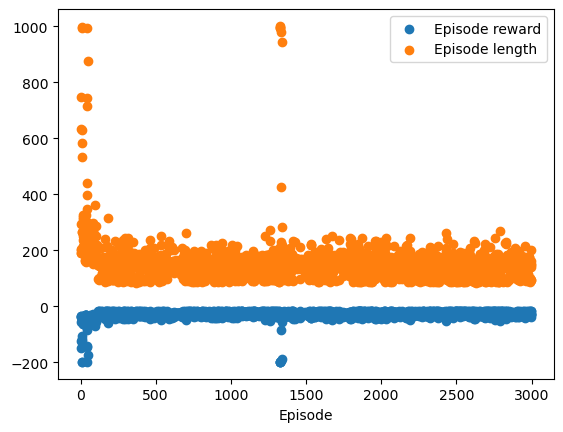

In [173]:
plt.figure()
plt.scatter(np.arange(len(list_rewards)),list_rewards, label="Episode reward")
plt.scatter(np.arange(len(list_lengths)),list_lengths, label="Episode length")
plt.xlabel("Episode") 
plt.legend()
plt.show()

# 4. Dyna